# Summary Notebook
This notebook details all steps taken throughout the project, such as preprocessing and modelling steps. The final goal is to create a robust ranking system that helps the BNPL firm identify the top 100 merchants.

<div class="alert alert-block alert-warning">
Run ETL script first before running this notebook for reproducible results
</div>

## Table of Contents
1. Datasets
2. Preprocessing Steps 
3. Ranking System
     * Revenue and Fraud Metric
     * Demographic Metric
     * Brand Growth and Exposure Metric
     * Final Ranking System
4. Merchant Segmentation
5. Ranking Results
6. Interesting Merchant Insights
7. Assumptions & Limitations
8. Discontinued Ideas
9. Conclusion

In [1]:
# import required libraries
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from IPython import display
import ipywidgets as widgets

# import constants
import sys
sys.path.append('../scripts/utils')
from constants import *

# create a spark session
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/19 10:52:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 1.  Datasets 📚 

Below are the datasets we worked with in order to achieve the project's goals. The size outlined below are the size of the raw data before we perform any preprocessing steps.

  * Internal Datasets - located in `data/tables` folder   
    * Consumer Data (`tbl_consumer.csv`) - 499,999 rows × 1 columns
    * Merchant Data (`tbl_merchants.parquet`) - 4026 rows x 3 columns
    * Transactions Data (inside folders that begin with `transactions`) - 14,195,505 rows x 5 columns
    * Consumer Fraud Probability (`consumer_fraud_probability.csv`) - 34,864 rows × 3 columns
    * Merchant Fraud Probability (`merchant_fraud_probability.csv`) - 114 rows x 3 columns
    * User ID to Consumer ID Mapping Table (`consumer_user_details.parquet`) - 499,999 rows x 2 columns   
    
  * External Datasets - located in `data/landing` folder
    * Socio-Economic Indexes for Areas (SEIFA) Data from ABS (`table_1_SA2.csv`) - 2373 rows × 11 columns
    * Taxation Statistics Data from ATO (`table_6b_ato.csv`) - 2664 rows × 158 columns
    * Postcode-SA2 Mapping Data (`abs_sa2_lookup.csv`) - 18,513 rows × 37 columns
    * SA2 2016 and SA2 2021 Correspondence Data (`sa2_correspondence.csv`) - 2504 rows x 8 columns

## 2. Preprocessing 🧹✨

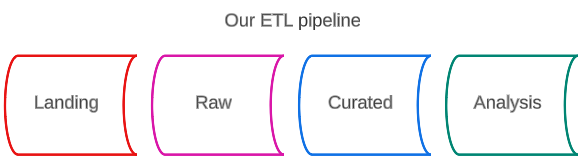

In [2]:
display.Image(f'{PLOTS}/ETL.png', width=500)

In [3]:
# reading data for visualizing 
tbl_consumer_landing = pd.read_csv(f"{TABLE_DATA}tbl_consumer.csv")
tbl_consumer_raw = pd.read_pickle(f"{RAW_DATA}tbl_consumer.pkl")

postcode_ABS = pd.read_pickle(f"{RAW_DATA}abs_table_1_postcode.pkl")
sa2_postcode_map = (pd.read_pickle(f"{RAW_DATA}SA2_code.pkl")).drop("state", axis=1)
sa2_correspondence = pd.read_csv(f"{LANDING_DATA}sa2_correspondence.csv")
abs_data = pd.read_pickle(f'{RAW_DATA}abs_table_1_SA2.pkl')

tbl_consumer = pd.read_pickle(f"{CURATED_DATA}tbl_consumer.pkl")
transaction_data = spark.read.parquet(f'{TRANSACTION_DATA}')

#### 1. Cleaning Data

Some of the data was not in a structured and organized format. For instance, a single column in the consumer and merchant data may contain multiple features. The external ABS data was also quite unorganized and require some cleaning effort.

Before Cleaning:

In [4]:
tbl_consumer_landing.head(1)

name|address|state|postcode|gender|consumer_id
0  Yolanda Williams|413 Haney Gardens Apt. 742|WA...

After Cleaning:

In [5]:
tbl_consumer_raw.head(1)

name                     address state postcode  gender  \
0  Yolanda Williams  413 Haney Gardens Apt. 742    WA     6935  Female   

   consumer_id  
0      1195503

#### 2. Outlier Removal

We observe that certain transactions exhibit unusually high purchase amounts in dollars. We note that BNPL platforms have purchases capped at $30,000, with many firms offering caps substantially lower than this (https://www.savings.com.au/buy-now-pay-later/every-buy-now-pay-later-provider-in-australia). 


There is a notably low count of transactions (278) exceeding the $30,000 threshold within the dataset. The working assumption here is that since these transactions surpass the maximum purchase limit typically offered by BNPL providers, they are likely genuine outliers that may stem from erroneous data. Therefore, we remove them from our dataset.

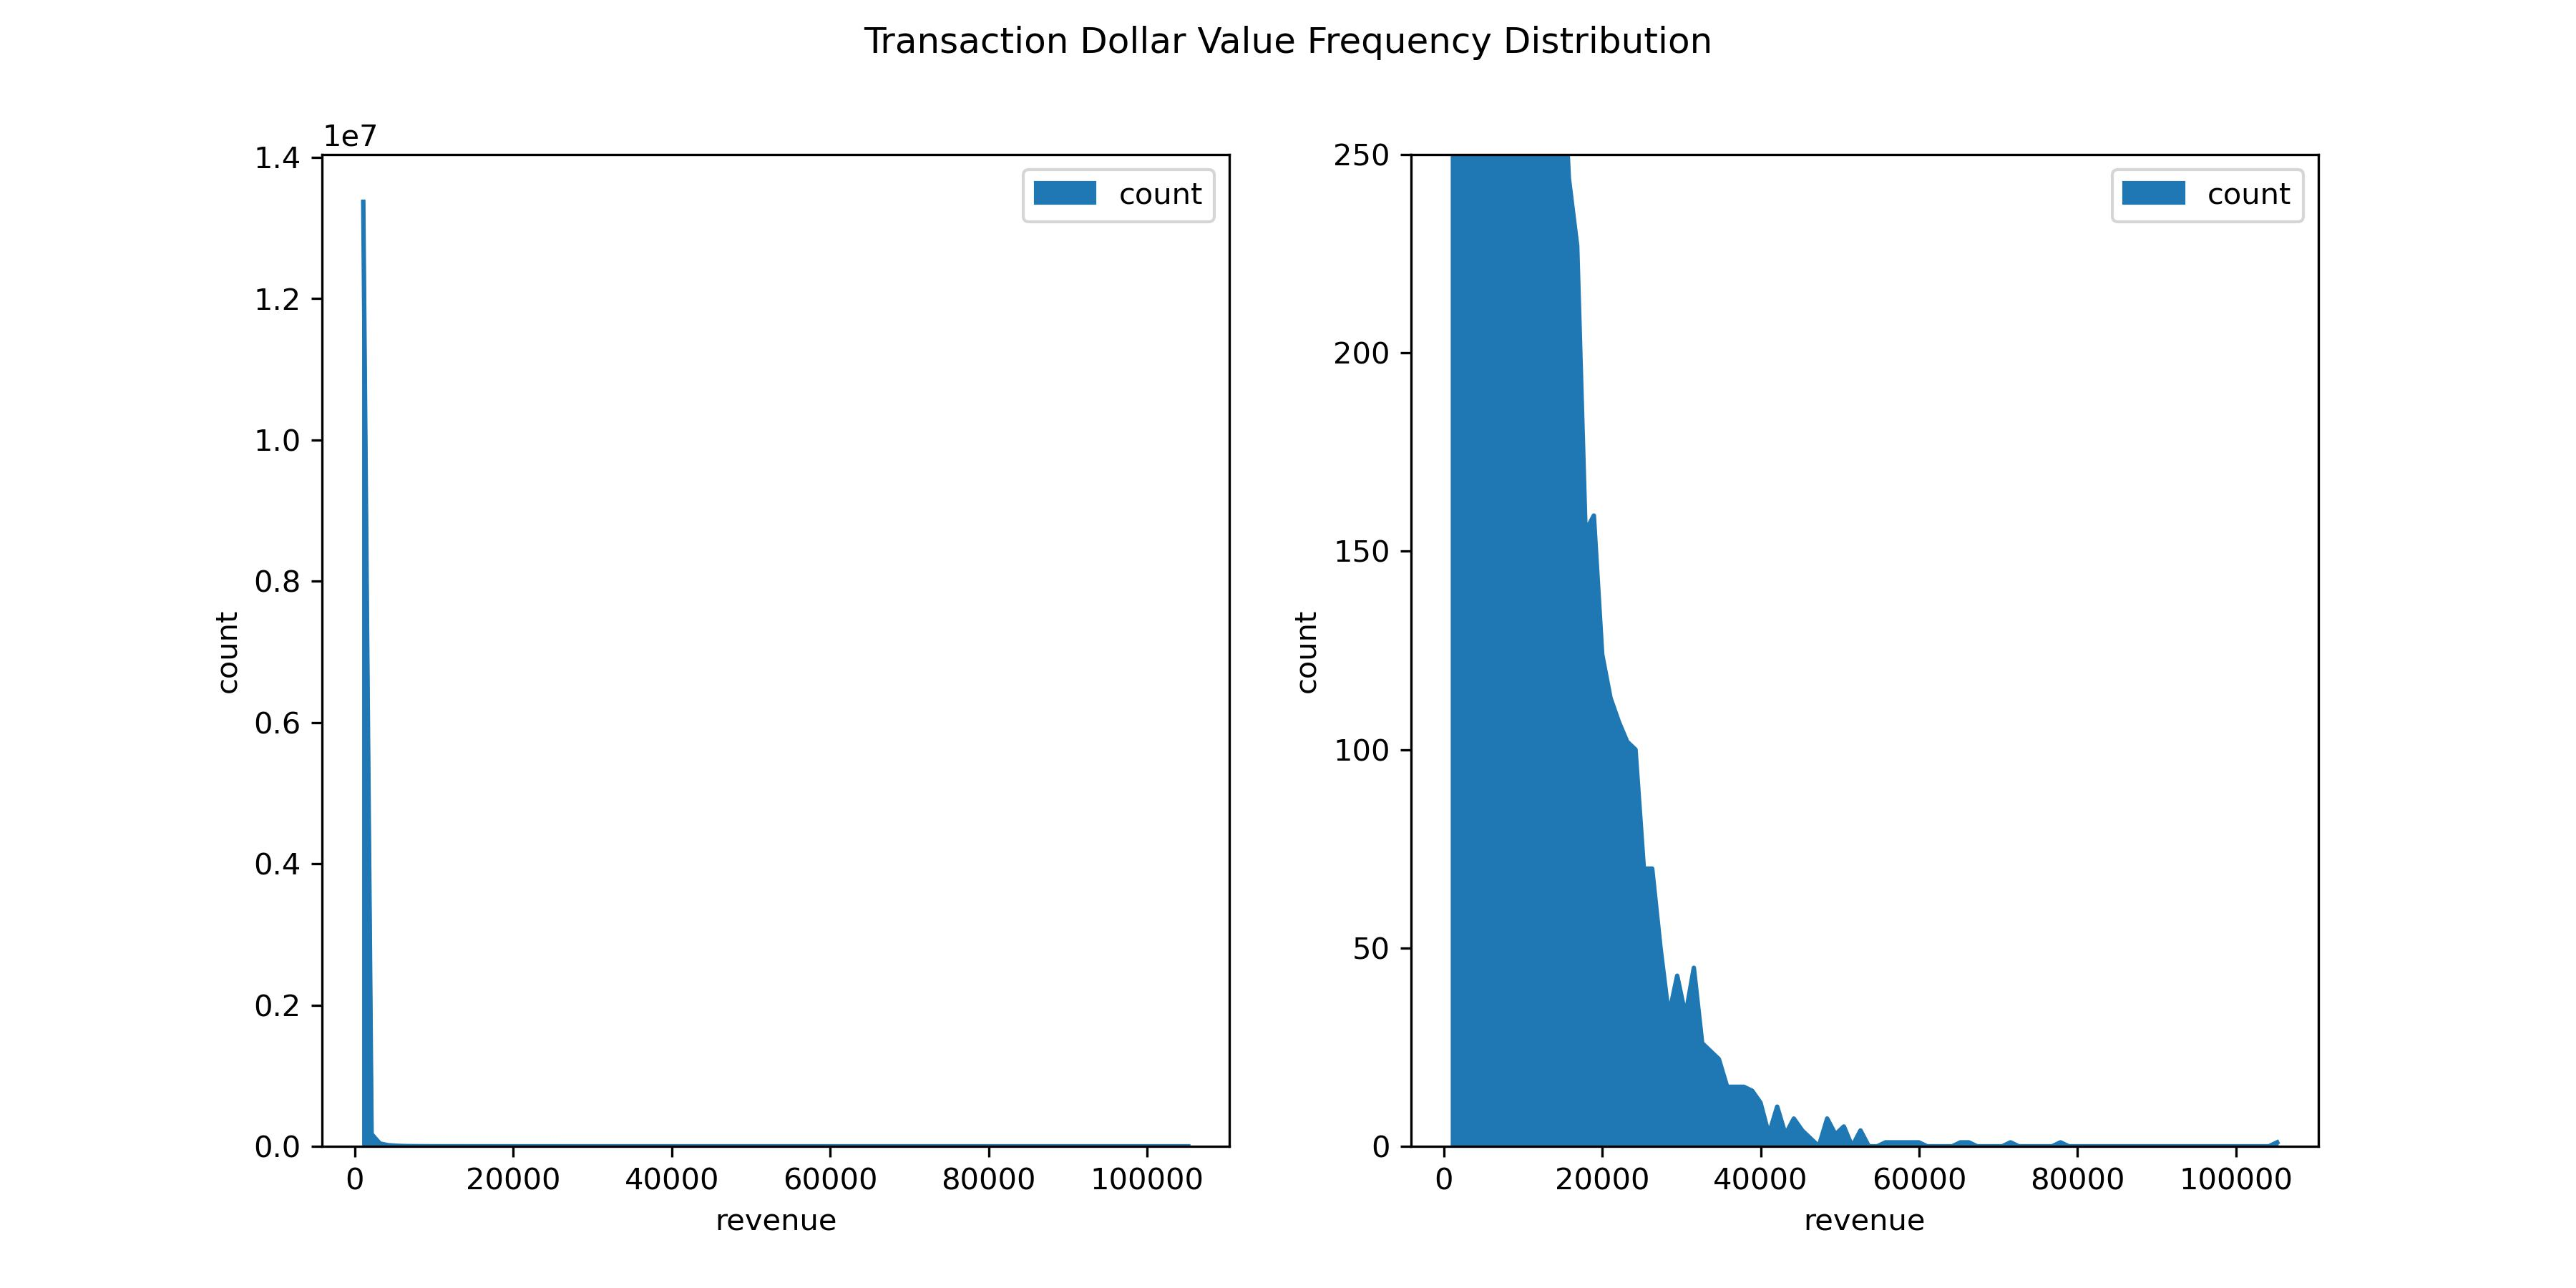

In [6]:
display.Image(f'{APPENDIX}/extreme_dollar.jpg', width=800)

#### 3. Missing Values

<b> Missing Merchant ABNs in Transactions Data: </b>

Some merchant ABNs in the transactions data do not have a corresponding entry in our merchants data.

We check the distribution of the extracted merchant data (merchant with missing data) against the main (kept) dataset. It can be seen that 396 merchants have been extracted (have missing values), compared to 4,422 merchants kept in the main dataset. By calculating the total revenue associated with these 396 merchants, and comparing to the main dataset (on a percentile basis) it can be seen that the extracted merchants have a reasonably similar revenue distribution to the main dataset.

Given that around 10% of the merchants have been extracted from the original transactions dataset, in reality it would be a priority to update the merchant dataset such that these transactions could be brought back in. Within the constraints of the project, however, it makes sense to take these transactions out.

Solution: <b> remove rows with missing merchant data. </b>

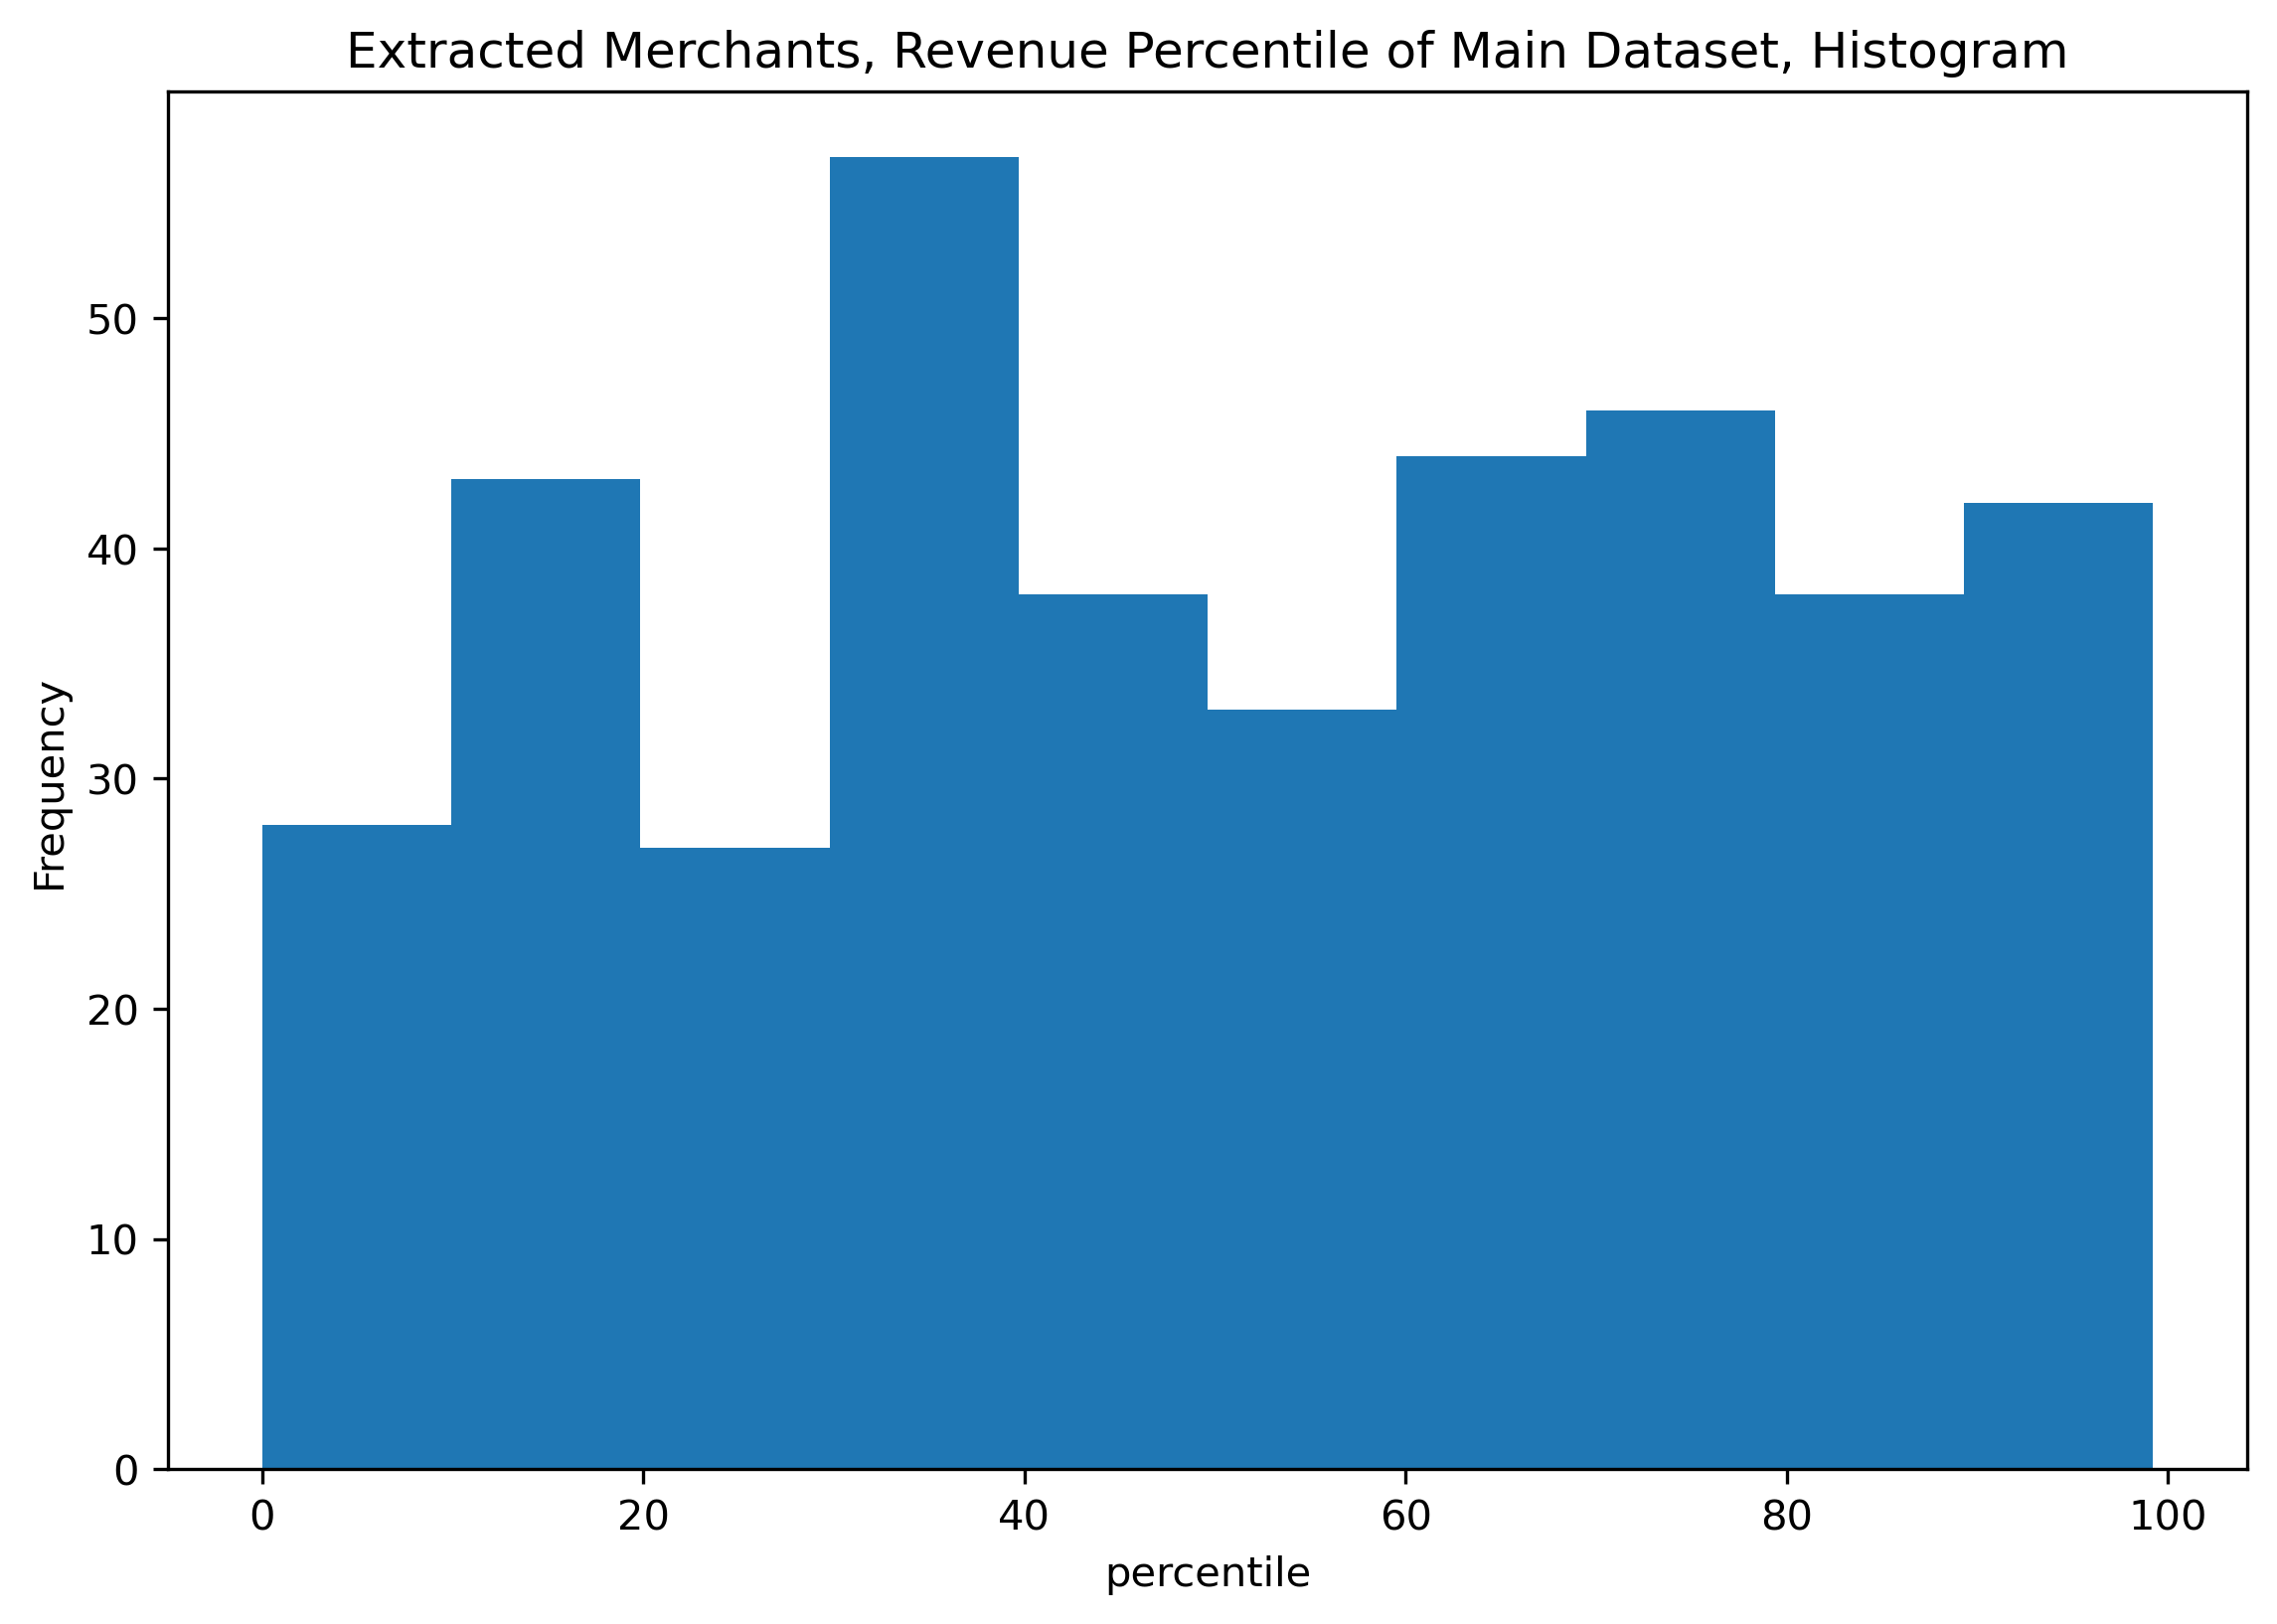

In [7]:
display.Image(f'{APPENDIX}/missing_ABNs.png', width=500)

<b> Missing ABS data for Multiple Postcodes: </b>

For more details, please visit the `missing_value_analysis.ipynb` notebook. This notebook contains the justification on how we deal with missing values.

When joining our external and internal datasets, we observed that multiple postcodes in our transaction data do not have corresponding entries in the ABS dataset. It can be seen that a substantial number of postcodes (~17.1%) have missing ABS data.

In [8]:
# get all postcodes from the ABS dataset
all_postcodes_abs = postcode_ABS['POA_code'].values.tolist()

# get all the postcodes connected to transactions
transaction_grouped = transaction_data.groupBy("user_id").sum("dollar_value")
consumer_data = spark.createDataFrame(tbl_consumer[["user_id", "postcode"]])
transaction_consumer = transaction_grouped.join(consumer_data, on="user_id", how="inner").toPandas()
transaction_consumer = transaction_consumer[['postcode', 'sum(dollar_value)']].groupby('postcode', as_index=False).agg('sum')
all_postcodes_transactions = transaction_consumer['postcode'].values.tolist()

# find the postcodes referenced in the transactions dataset, not present in the abs dataset
missing_postcodes = list(set(all_postcodes_transactions)-set(all_postcodes_abs))

print(f'number of postcodes in transactions dataset: {len(all_postcodes_transactions)}')
print(f'number of postcodes in ABS dataset: {len(all_postcodes_abs)}')
print(f'number of missing postcodes: {len(missing_postcodes)}')
print(f'% of missing postcodes: {len(missing_postcodes) / len(all_postcodes_transactions) * 100 :.2f}')

number of postcodes in transactions dataset: 3165
number of postcodes in ABS dataset: 2626
number of missing postcodes: 542
% of missing postcodes: 17.12


Since the number of missing data is quite significant, we avoid removing them.

Solution: <b> reduce granularity from postcode to Statistical Areas 2 (SA2). That is, use SA2 ABS data instead of postcode ABS data. </b>

With SA2 ABS data, although missing values still persist, there are substantially much less missing values (~2.79% missing values).

In [9]:
tbl_consumer_sa2 = pd.merge(tbl_consumer, sa2_postcode_map, on='postcode', how='left')
tbl_consumer_sa2 = tbl_consumer_sa2.rename(columns={'SA2_code': 'SA2_code_2016'})
consumer_sa2 = tbl_consumer_sa2['SA2_code_2016'].unique()

sa2_correspondence = sa2_correspondence[["SA2_MAINCODE_2016", "SA2_CODE_2021"]]
abs_new = pd.merge(abs_data, sa2_correspondence, left_on='SA2_code', right_on='SA2_CODE_2021', how='left')
abs_new = abs_new.drop('SA2_CODE_2021', axis=1)
abs_new = abs_new.rename(columns={'SA2_code': 'SA2_code_2021', 'SA2_MAINCODE_2016': 'SA2_code_2016'})

abs_sa2 = abs_new['SA2_code_2016'].unique()
print(f"Missing values with SA2: {len(set(consumer_sa2) - set(abs_sa2))/len(consumer_sa2)*100:.2f}%")

Missing values with SA2: 2.79%


  * Some SA2 areas have missing ABS scores. In this case, we imputed the missing scores with the median scores of the SA3 area the SA2 area belong to (SA3 are wider areas and consist of multiple SA2 areas).
  * In other cases, the SA2 area itself is missing from the ABS data. Hence, we decided to remove these records. 
  * Furthermore, there is also the case where three postcodes in the consumer data do not have corresponding entries in our postcode-SA2 mapping file. We also removed the records associated with this postcode.
  * In total, we removed only ~1.67 % of data

<b> Missing ATO data for Multiple Postcodes: </b>  


We also encounter a similar missing values scenario with the ATO data. In this case, we imputed the missing scores by the average of the 3 nearest postcodes' scores. Here, we assume that postcodes which are close to each other numerically will have similar demographics.

## 3. Ranking System 📊

### 1. Revenue + Fraud

We use expected profit per merchant as our first ranking metric, and assume that all transactions are put through the BNPL firm. This is calculated as the take rate on all transactions from that merchant, minus the expected losses due to fraud, which is estimated using the fraud probability


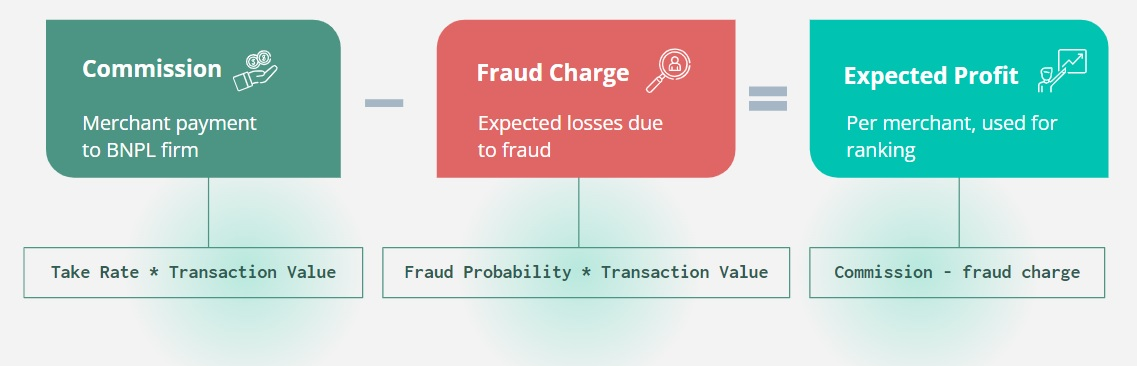

In [10]:
display.Image(f'{PLOTS}/expected_profit.jpg', width=800)

As no fraud probability was provided for Feb 22 onwards, we used the comparable regime of Feb to Aug 21 to estimate these missing values. 

There is a clear distinction between the three periods provided in the dataset, with Black Friday and the Christmas period in 2021 exhibiting extreme volatility in transaction value.
To model fraud probability for Feb 2022 to Aug 2022, we use the Feb 2021 to Aug 2021 dataset.


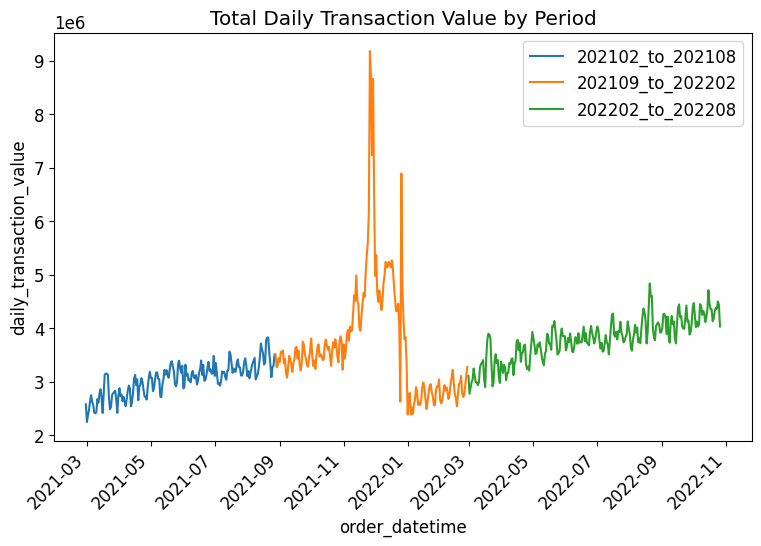

In [11]:
display.Image(f'{PLOTS}/rev_segments.png', width=700)

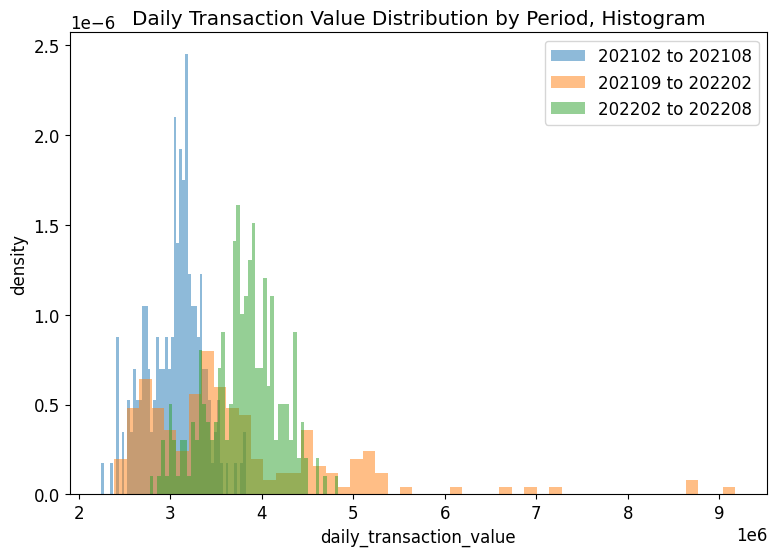

In [12]:
display.Image(f'{PLOTS}/rev_data.png', width=700)

The Feb 2021 to Aug 2021 dataset demonstrates a distinctly positive linear relationship between fraud probability and daily spending (per user), but only for larger spending amounts (>$1500). This can be modelled with a linear regression.
For smaller spending amounts the relationship requires investigation.


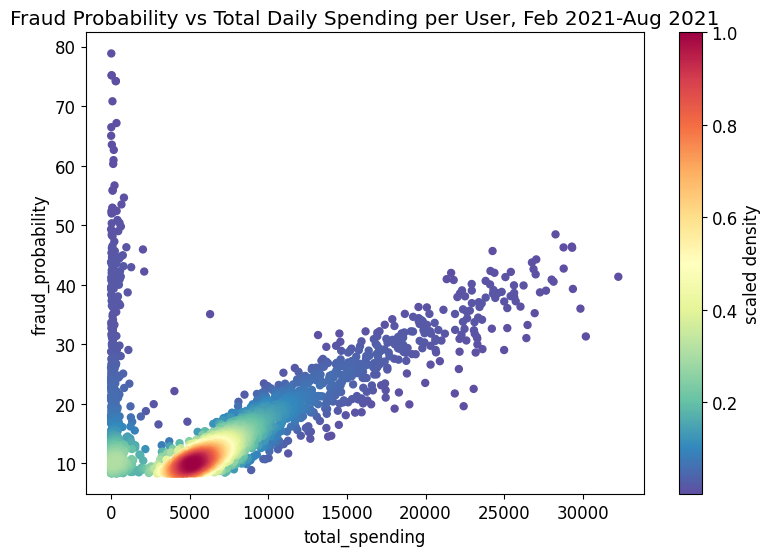

In [13]:
display.Image(f'{PLOTS}/fraud_scatter1.png', width=700)

The distribution of fraud probability for small daily spend (<$1500) exhibits a classic power law shape, with the vast major of transactions showing low or no fraud probability, and a small number showing very high probability. It appears that all fraud probabilities below a certain level (~8.3%) are discarded as non-meaningful. We will take the same approach when estimating the missing data. 

Using a power law model to simulate fraud probability in the period Feb 2021 to Aug 2021, the resulting distribution is very similar to the original one.

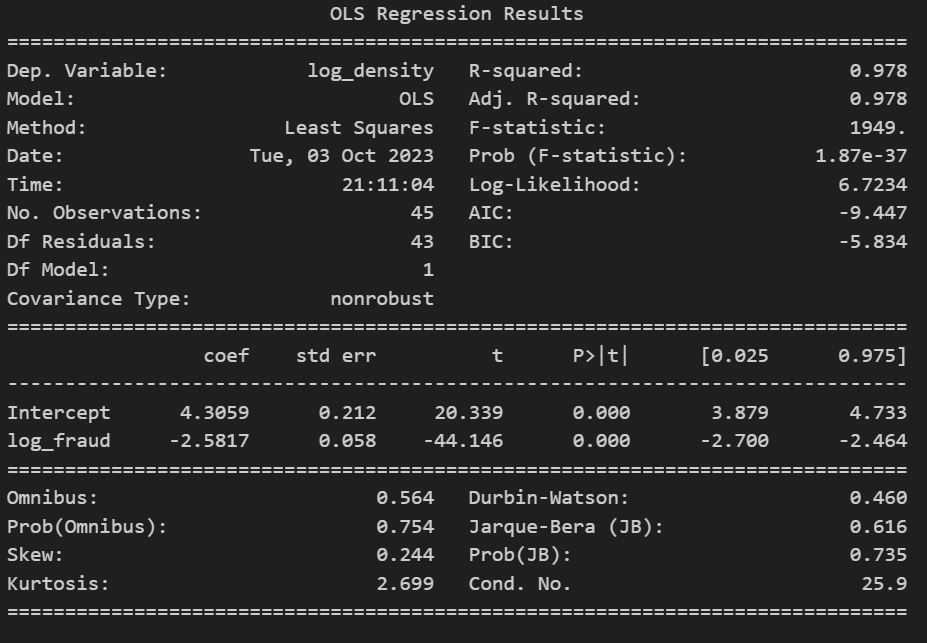

In [14]:
display.Image(f'{PLOTS}/reg1_results.png', width=500)

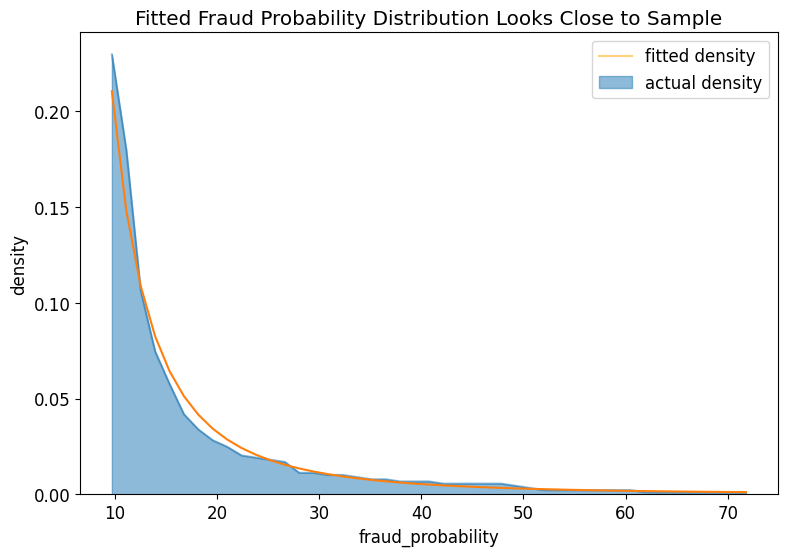

In [15]:
display.Image(f'{PLOTS}/fraud_density.png', width=700)

Now we want to run a sampling process on this regression to check that it matches the original distribution. To do that we need to convert the log-linear regression back into the original space, and find the normalising constant and CDF function, and then invert it. Once inverted we can run a random uniform sample to generate a random sample from the fraud probability distribution. We assume the fraud probability minimum is 0.15%, and maximum is 80%, given the observed data from Feb-Aug 2021 

$$
\begin{aligned}
let~x&=fraud~probability\in{(0.15,80)}\\
\alpha&=regression~slope~coefficient\\
\beta&=regression~intercept~coefficient\\
\xi&=normalisation~constant\\
then~f_x(x)&=x^{\alpha}e^{\beta}\\
\xi&=\int_{0.15}^{80}x^{\alpha}e^{\beta}dx\\
&=\frac{e^{\beta}}{\alpha+1}[x^{\alpha+1}]_{0.15}^{80}\\
&=\frac{e^{\beta}}{\alpha+1}[80^{\alpha+1}-0.15^{\alpha+1}]\\
\Rightarrow F_x(x)=y&=\int_{0.15}^{x}\frac{u^{\alpha}e^{\beta}}{\xi}du\\
&=\frac{e^{\beta}}{\xi(\alpha+1)}[u^{\alpha+1}]_{0.15}^{x}\\
&=\frac{e^{\beta}}{\xi(\alpha+1)}[x^{\alpha+1}-0.15^{\alpha+1}]\\
\Rightarrow x&=\biggl[\frac{y(\alpha+1)\xi}{e^{\beta}}+0.15^{\alpha+1}\biggl]^{1/\alpha+1}\\
\end{aligned}
$$

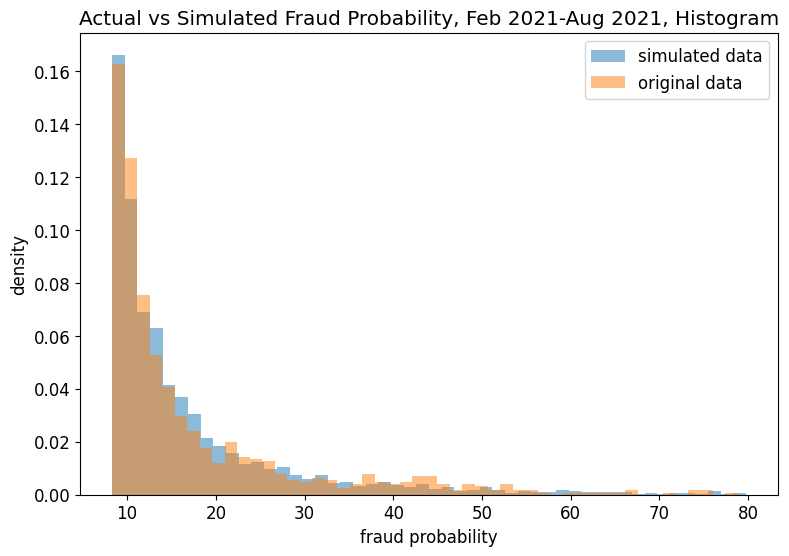

In [16]:
display.Image(f'{PLOTS}/simulation.png', width=700)

We have successfully modelled the <1500 transaction value data, and now run a linear regression on the >1500 transaction value data. The R^2 value looks good. Now we can estimate fraud probability data for the Feb 2022 to Aug 2022 transaction dataset, where no fraud probability is currently assigned.

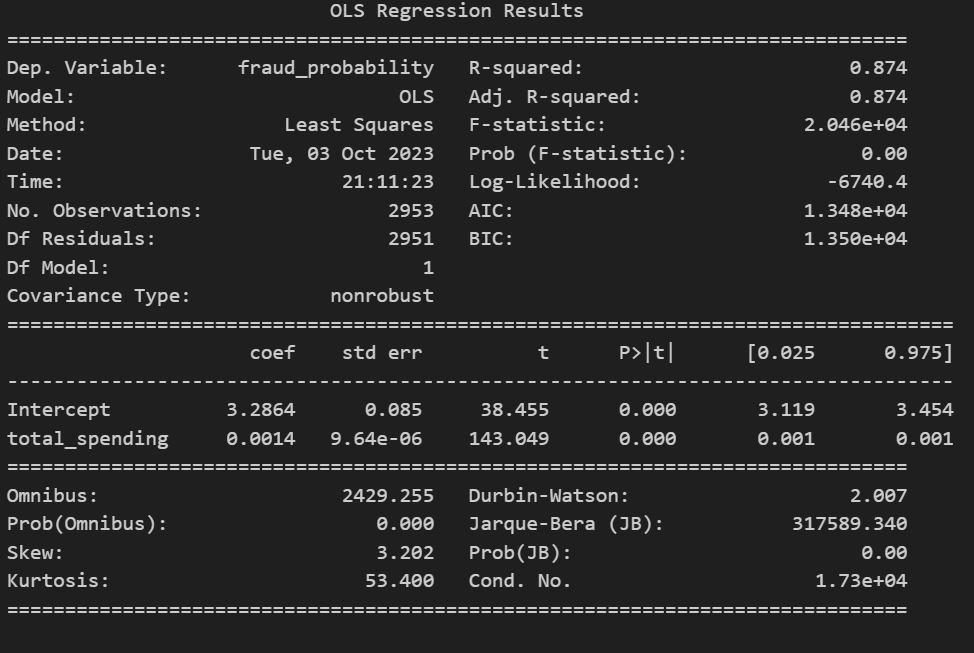

In [17]:
display.Image(f'{PLOTS}/reg2_results.png', width=500)

It can be seen that some merchants have negative expected profitability after adjusting for fraud, however there are still a number of merchants that have high expected profitability, and many merchants did not suffer greatly from expected fraud. 

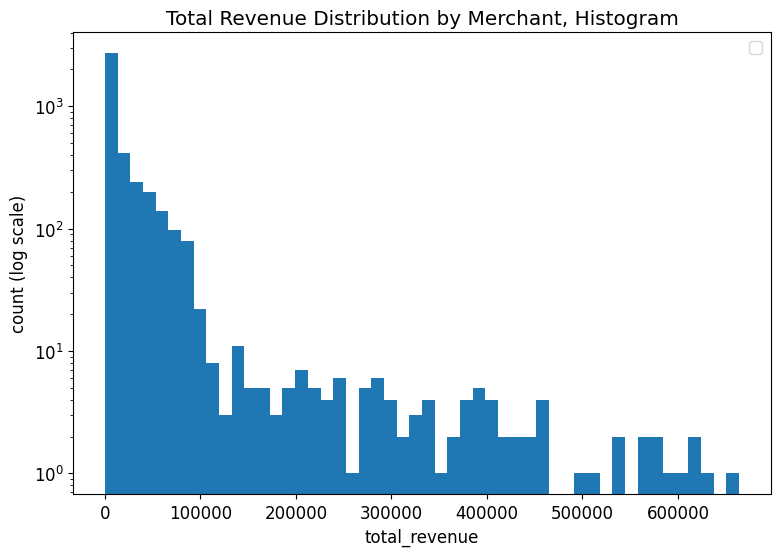

In [18]:
display.Image(f'{PLOTS}/merchant_rev1_log.png', width=700)

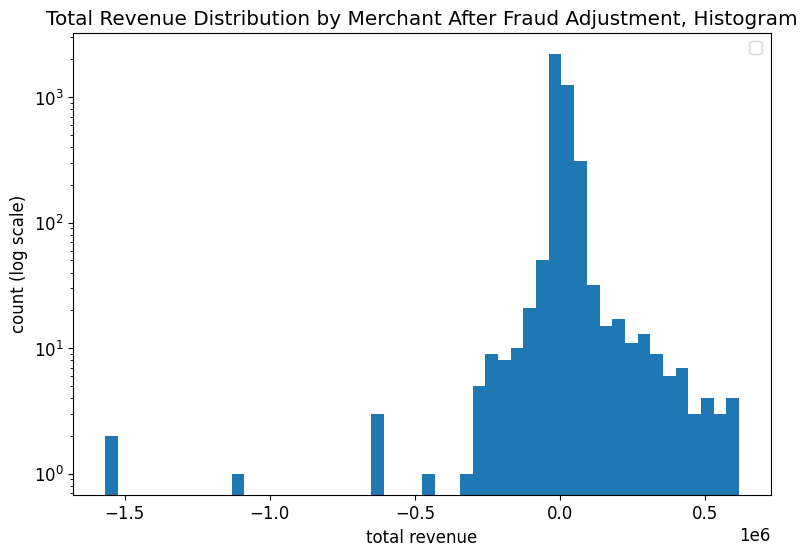

In [19]:
display.Image(f'{PLOTS}/merchant_rev2_log.png', width=700)

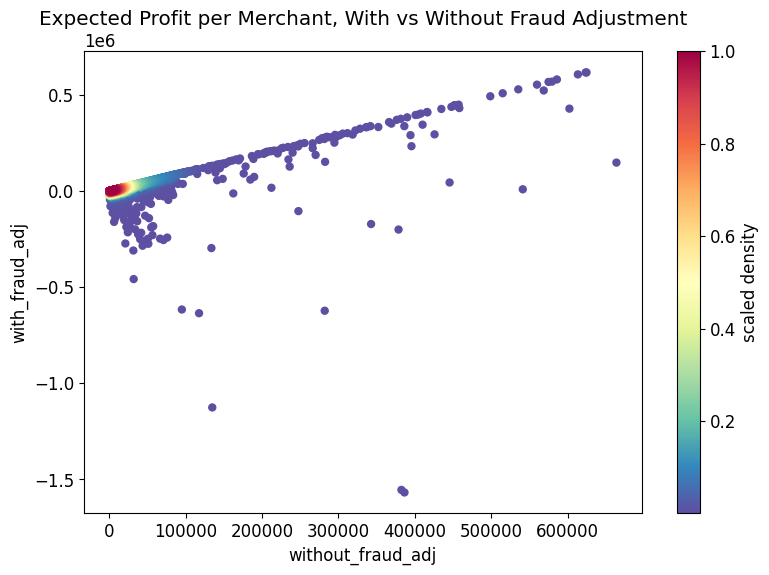

In [20]:
display.Image(f'{PLOTS}/fraud_scatter2.png', width=700)

The scatter plots below show the highly ranked merchants in red, and lower ranked merchants in blue, both with average daily revenue on the x-axis. Clearly higher daily revenue is good, but only if variability in daily revenue is low, as seen in the top chart. The chart on the bottom shows that merchants which generated nearly all their revenue from small transactions were also generally favoured. Fraud probability is key to this finding, and it should be reiterated that the majority of small transactions attract zero fraud probability


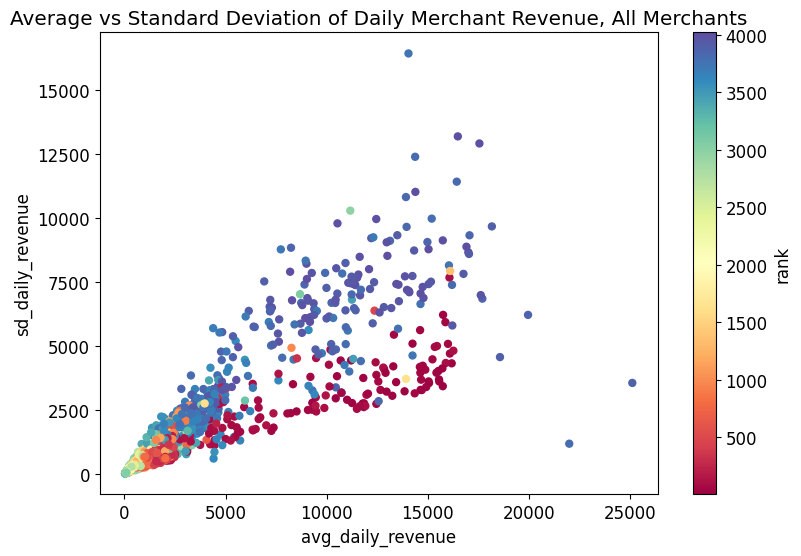

In [21]:
display.Image(f'{PLOTS}/merch_rev1.png', width=700)

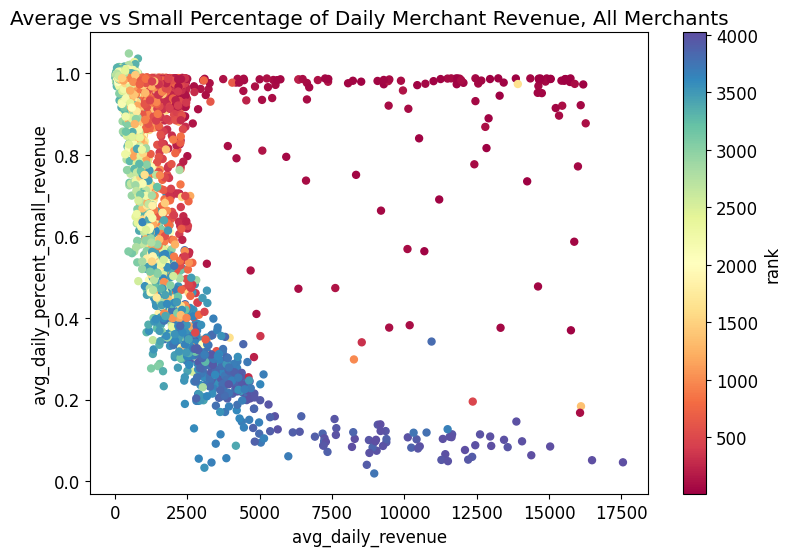

In [22]:
display.Image(f'{PLOTS}/merch_rev2.png', width=700)

### 2. Demographics (+ External Data Analysis)

We used the following external data:
1. ABS Socio-Economic Indexes for Areas Dataset 2021: ranks areas according to their relative socio-economic scores in 2021
2. Taxation Statistics (Australian Taxation Office Dataset 2020-2021): shows statistics from tax returns and income information related schedules for the 2020–21 income year

Particularly, we used these specific features:
  * Education occupation score
    * Measures the educational and occupational characteristics of communities, including educational attainment and ongoing education pursuits, as well as occupation categories based on the Australian and New Zealand Standard Classification of Occupations (ANZSCO)
  * Relative socioeconomic disadvantage score 
    * A comprehensive socio-economic indicator that condenses various data concerning the economic and social circumstances of individuals and households residing in a specific area
  * Per Capita income = Total taxable income/ number of tax payers

#### Transaction Consumer ABS Data
##### ABS SEIFA Data vs User revenue 

Below codes are visualization (scatter plot) between user revenue and ABS SEIFA scores Data.

It is hard to find a relationship between user revenue and ABS SEIFA Score.

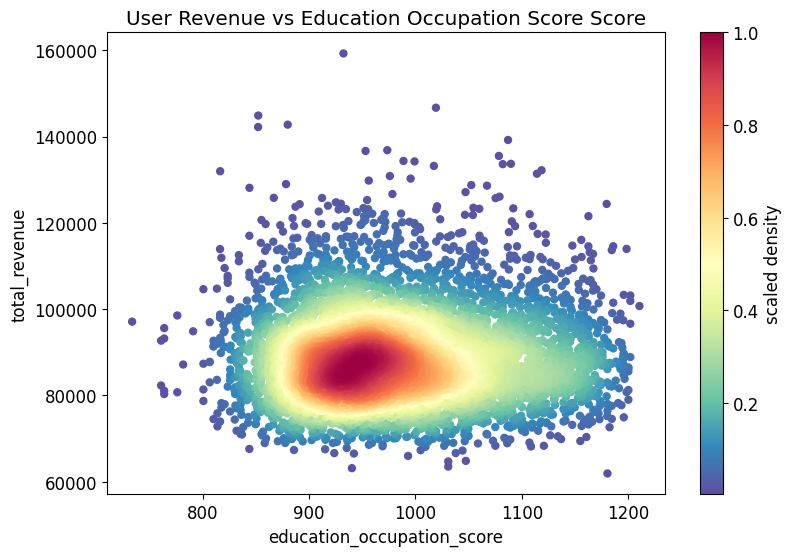

In [23]:
display.Image(f'{PLOTS}demographics_3.png', width=700)

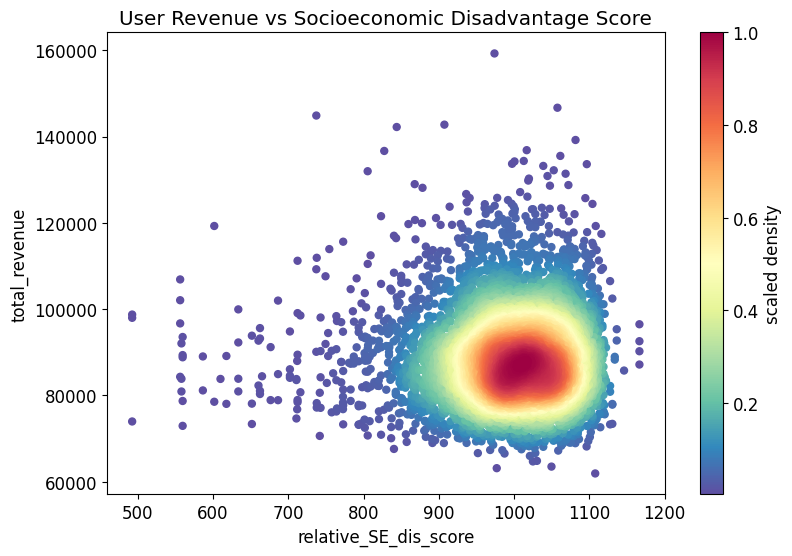

In [24]:
display.Image(f'{PLOTS}demographics_2.png', width=700)

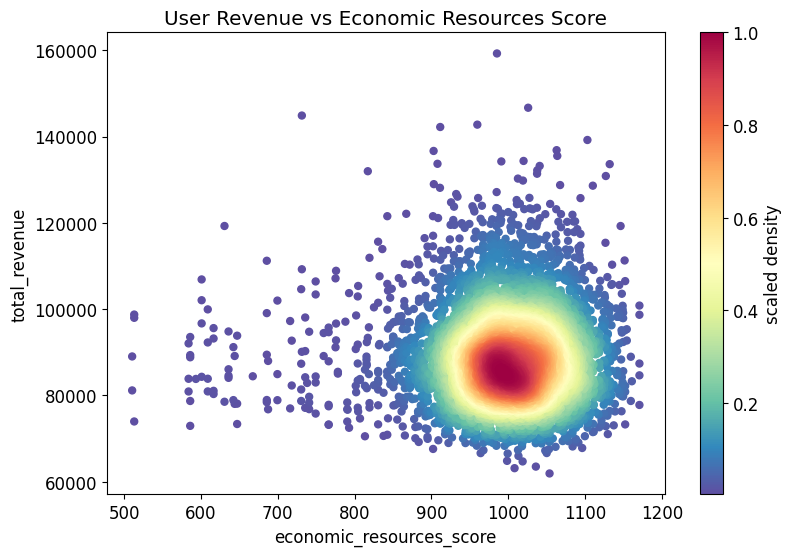

In [25]:
display.Image(f'{PLOTS}demographics_1.png', width=700)

##### ABS data vs Revenue Level
We calculated Pearson correlation coefficients to check if there's a relationship between categorical merchant ranking (a, b, c, d, and e) and socioeconomic disadvantage score. Since socioeconomic disadvantage score is a general socioeconomic index that summarizes a range of information about the economic and social condition of people and households within an area, we chose this as a representative attribute.

However, with the correlation coefficient ranging from -0.01 to -0.03, we concluded that we cannot say merchant ranking levels are strongly associated with the disadvantage socioeconomic score based on a linear correlation analysis. 

##### Linearity between ABS Data
We then visualized whether there is a linear relationship between the ABS data. While economic resource score and relative SE disadvantage score have a strong linear relationship, education occupation score and relative SE disadvantage score do not.

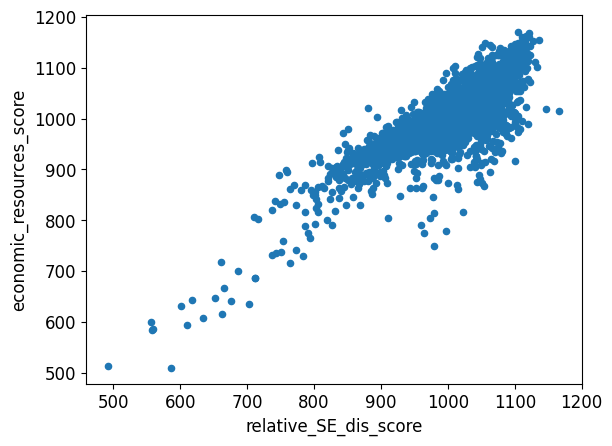

In [26]:
display.Image(f'{PLOTS}se_dis_vs_econ_resources.png', width=600)

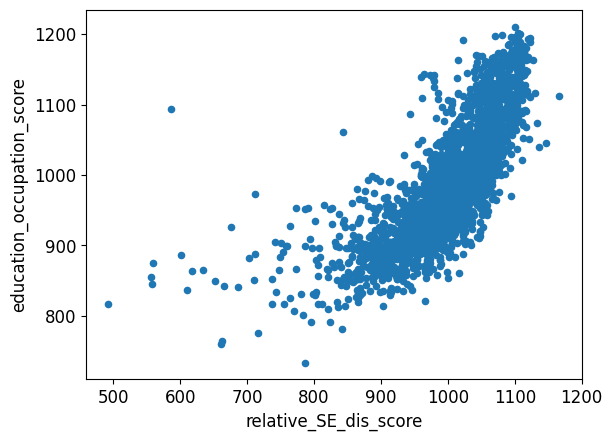

In [27]:
display.Image(f'{PLOTS}se_dis_vs_edupng.png', width=600)

Hence, we came up with a demographic information weighted average ranking system with the following metrics:
  * Education occupation score (weight = 0.3)
  * Relative socioeconomic disadvantage score (weight = 0.35)
  * Per Capita income = Total taxable income/ number of tax payers (weight = 0.35)

The Relative Socioeconomic Disadvantage score serves as a general socio-economic index, encapsulating various factors including education, occupation, and income. We include the more granular education occupation score, and the per capita income score, as we believe these metrics provide further / targeted information on the socioeconomic metrics that we think are most important for a merchant to target within their customer base. 

### 3. Brand Growth and Exposure

Now that we have considered the financial aspect of maximizing revenue as well as the demographic aspect of customers, we also want to incorportate a marketing aspect into our ranking system. In this section, we will focus on metrics that will help promote our BNPL firm's brand growth and exposure. We believe that onboarding merchants who maximize the metrics below will help our firm to expand and grow.

1. <b>Sales Region Count </b>

    *  We would like to onboard merchants who sells to as many postcodes as possible.
    * We believe this reflects the geographical reach of each merchant.
    * <b>Market Expansion</b>: Onboarding merchants with a broad geographical reach allows our BNPL firm to expand its market coverage. This means reaching more potential customers in different areas, including urban and rural locations. By partnering with merchants in various postcodes, the BNPL firm can tap into previously untapped markets and increase its customer base.
    * <b>Diversification</b>: Working with merchants from diverse locations can help the BNPL firm diversify its risk. Different regions may have varying economic conditions and customer behavior. By having a presence in multiple postcodes, the BNPL firm can spread its risk and reduce its exposure to economic fluctuations or market-specific challenges in a single area.
    * <b>Enhanced Customer Base</b>: A wide geographical reach helps in acquiring a diverse customer base. People in different postcodes have different purchasing habits and preferences. Onboarding merchants from various regions ensures that the BNPL firm can cater to a wide range of customer needs and preferences.

2. <b>Returning Customers Count</b>
    * We would like to onboard merchants with a high number of returning customers.
    * We define returning customers as customers who have made >1 transactions with the particular merchant.
    * <b>Brand Credibility</b>: Merchants with a strong base of returning customers have likely built a reputation for quality, trustworthiness, and customer satisfaction. By aligning with such merchants, the BNPL firm can benefit from the positive image and credibility associated with these businesses. This can help the enhance our brand image.
    * <b>Market Presence</b>: Merchants with high returning customer numbers often have a strong market presence and reach. Partnering with these merchants allows the BNPL firm to tap into the existing customer base of these businesses. This can lead to an immediate and broad market penetration, reaching a wide audience with established purchasing habits.
    * <b> Stable Revenue Streams </b>: Returning customers are more likely to make frequent purchases, creating a stable and predictable revenue stream for both the merchant and the BNPL firm. This stability can be beneficial in terms of financial planning and risk management.

3. <b>Consumer Base</b>
     * We would like to onboard merchants with a large consumer base.
     * That is, onboarding merchants with a large number of unique customers.
     * <b> Market Expansion </b>: Merchants with a large and diverse customer base can help the BNPL firm expand into new markets and demographics. By serving a wide range of unique customers, the BNPL firm can reach customers with varying preferences, purchasing habits, and needs.
     * <b> Customer Acquisition </b>: Partnering with high-customer-traffic merchants allows the BNPL firm to acquire new customers. Unique customers who haven't used the BNPL service before represent an opportunity for the firm to introduce its payment option and potentially convert them into long-term users.
     * <b>Brand Exposure</b>: Collaborating with high-traffic merchants can enhance the visibility and credibility of the BNPL service. These merchants may have strong brand recognition, and associating with them can build trust and awareness among consumers who may not have previously been familiar with the BNPL service.

### Final Ranking System

We distributed appropriate weight to each metrics to produce final ranking as below.
1. Revenue (including Fraud) Metric - 50%
2. Demographic Metric - 25%
3. Brand Exposure and Growth Metric - 25%

The weights were chosen to reflect both backward and forward-looking insights. We consider the transaction history of the merchant as indicative of their baseline potential as a BNPL client, with demographic exposure and customer engagement a key indicator of their ability to grow the business, and provide a stable revenue line. Catering to a diverse and growing customer base, with favourable demographic background, means the merchant is likely well positioned to capitalize on future opportunities. 

## 4. Merchant Segmentation 🛒 
This section will go through the process of how we segmented merchants into five categories based on their product description. For more details, please visit the `segmentation_merchant.ipynb` notebook. Might also need to run the notebook to get reproducible results for this section.

In [28]:
tbl_merchant_raw = pd.read_pickle(f"{RAW_DATA}tbl_merchants.pkl")
tbl_merchants_cluster = pd.read_pickle(f"{CURATED_DATA}tbl_merchants_cluster.pkl")

#### 1. Preprocessing

Each merchant's dataset includes brief descriptions of the products they offer. These descriptions are somewhat inconsistent and require preprocessing. Hence, the following preprocessing steps were applied:
  * convert to lowercase
  * remove punctuations and extra whitespaces
  * lemmatization
  * remove stop words
  * remove duplicate words

After cleaning, we managed to narrow down over 4000 merchant product descriptions to just 25 distinct product tags. 

Before preprocessing:

In [29]:
tbl_merchant_raw.iloc[0]["products"]

'furniture, home furnishings and equipment shops, and manufacturers, except appliances'

After preprocessing:

In [30]:
tbl_merchants_cluster.iloc[0]["preprocessed_products"]

'furniture home furnishing equipment manufacturer appliance'

#### 2. Specify Categories/Labels

Next, we will specify the labels we wish to segment the merchants into. We believe that the following labels nicely reflect the major sectors within a Buy Now, Pay Later (BNPL) ecosystem.

  1. Technology
  2. Leisure, Luxury, Art
  3. Health and Wellness
  4. Repair Services
  5. Appliances

It is worth noting that our merchant segmentation process/model is quite flexible and customizable. Should there be a need to modify the industry categories (or the quantity of categories), we can effortlessly adjust the labels within a single line of code, and the entire process will continue to function automatically.

#### 3. Model for Automated Labeling

Given that we only have 25 unique product tags, it is reasonable for us to manually segment the merchants ourselves. However, we took into consideration applying our project to real-world data where the number of unique tags is expected to significantly exceed 25. Hence, we think it is practical to develop a model for segmenting these merchants. By creating this model, we aim to automate the process of segmenting merchants, making it sensible for our system to handle real-world data.

##### KNN Model with `en_core_web_lg`

The idea behind our model is that for every product tag, we will compute its semantic proximity to each of the label. Then, we will assign it to the label it is closest to. 

In order to determine the semantic proximity, we utilized `en_core_web_lg`, which is a pre-trained language model for the English language provided by spaCy, a popular natural language processing library in Python. This model is part of spaCy's "large" category of models and is built on a substantial text corpus. It includes word vectors and various linguistic annotations, making it suitable for a wide range of NLP tasks such as text classification.

Next, we borrow the K-Nearest Neighbour (KNN) algorithm with K=1 to assign the product tag to the label it is semantically closest to.

In [31]:
# example merchants and the category they get assigned to
tbl_merchants_cluster[["merchant_abn", "preprocessed_products", "cluster"]][27:30]

merchant_abn                   preprocessed_products             cluster
27   10648956813  computer peripheral equipment software          technology
28   10651113986                             tent awning          appliances
29   10702078694              gift card novelty souvenir  leisure luxury art

#### 4. Segmentation Results and Analysis
  * Based on the visualizations provided below, we can observe that the appliances sector comprises the largest share of merchants, accounting for 50.6% of the total, followed by the leisure sector at 28.7%, the technology sector at 9.2%, repair services at 7.4%, and the health and wellness sector having the smallest representation at 4.1%.
  * Likewise, in terms of revenue distribution, more than half (52.2%) of the total revenue is generated by the appliances sector, followed by leisure (28.1%), technology (10.2%), repair services (6%), and health and wellness (3.4%).
  * However, even though the repair and health and wellness sectors contribute less to total revenue, they exhibit comparatively higher average and median revenue figures than the other sectors.


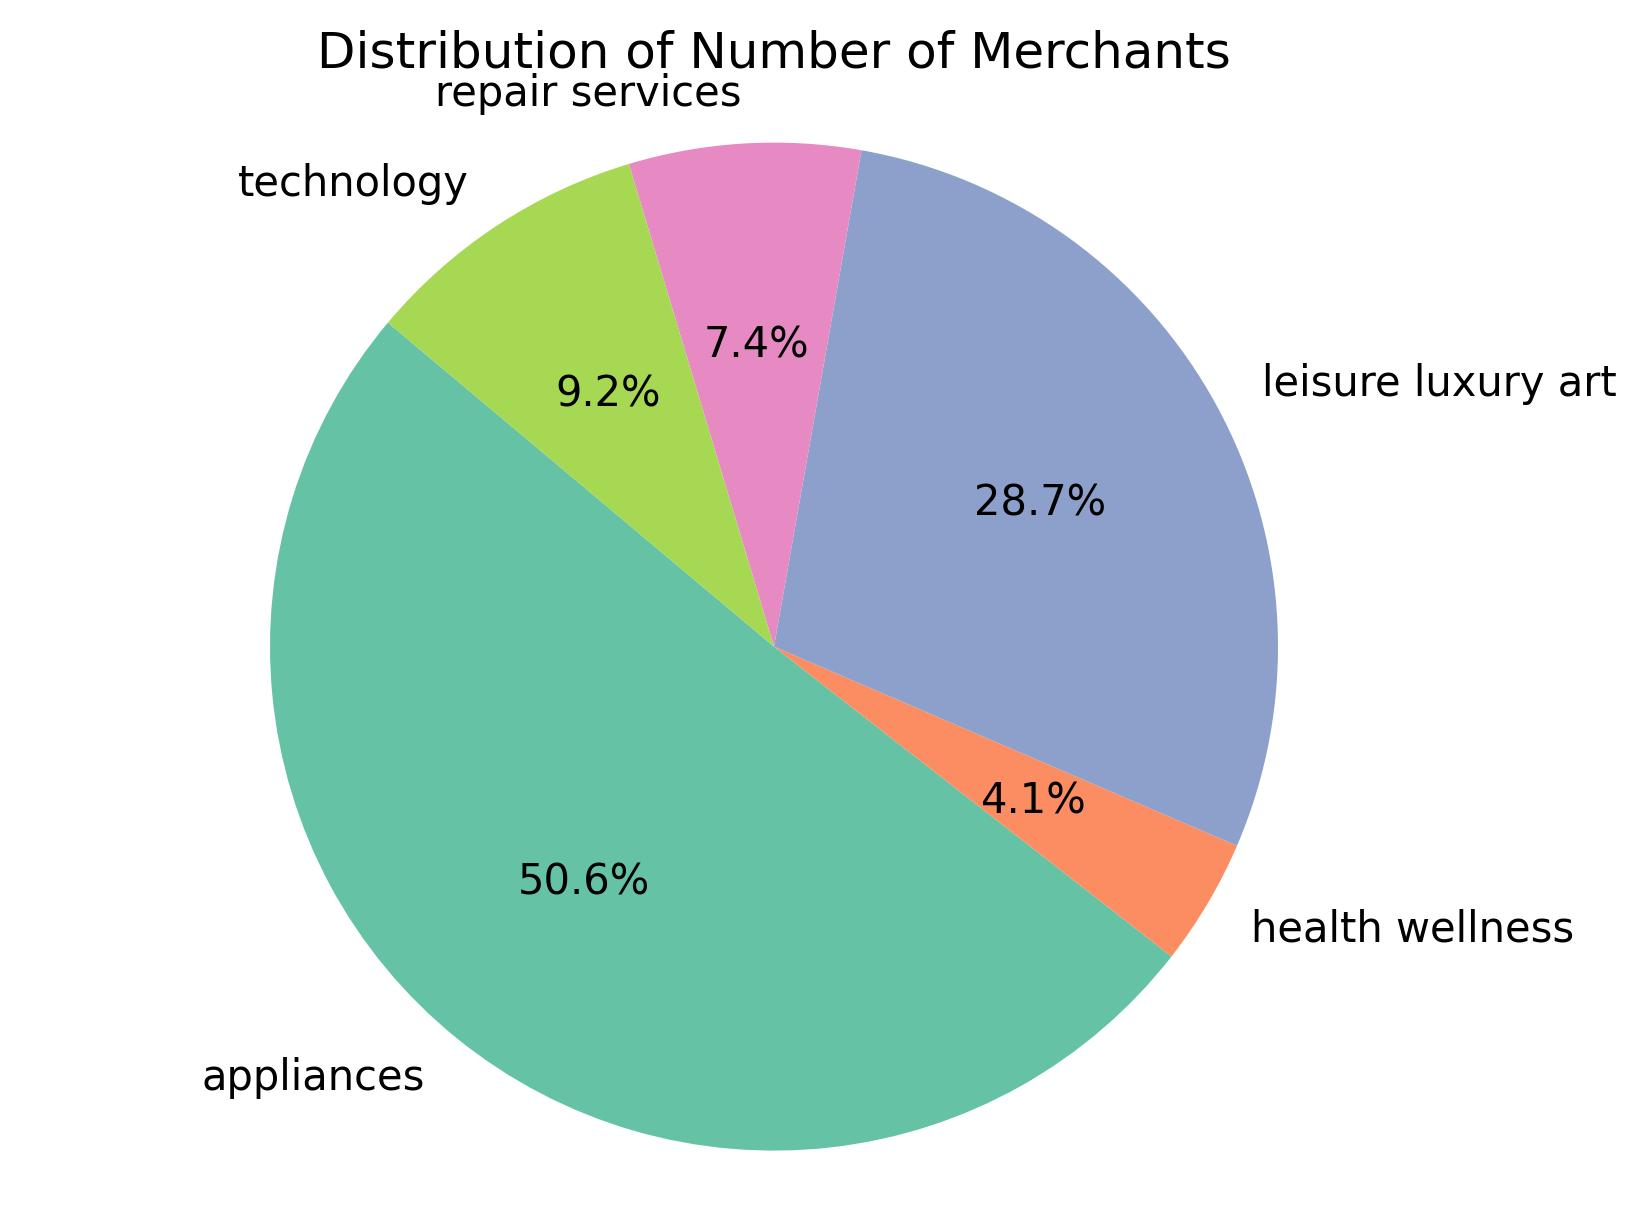

In [32]:
display.Image(f'{MERCHANT_SEGMENT_PLOT}/num_merchants.jpg', width=400)

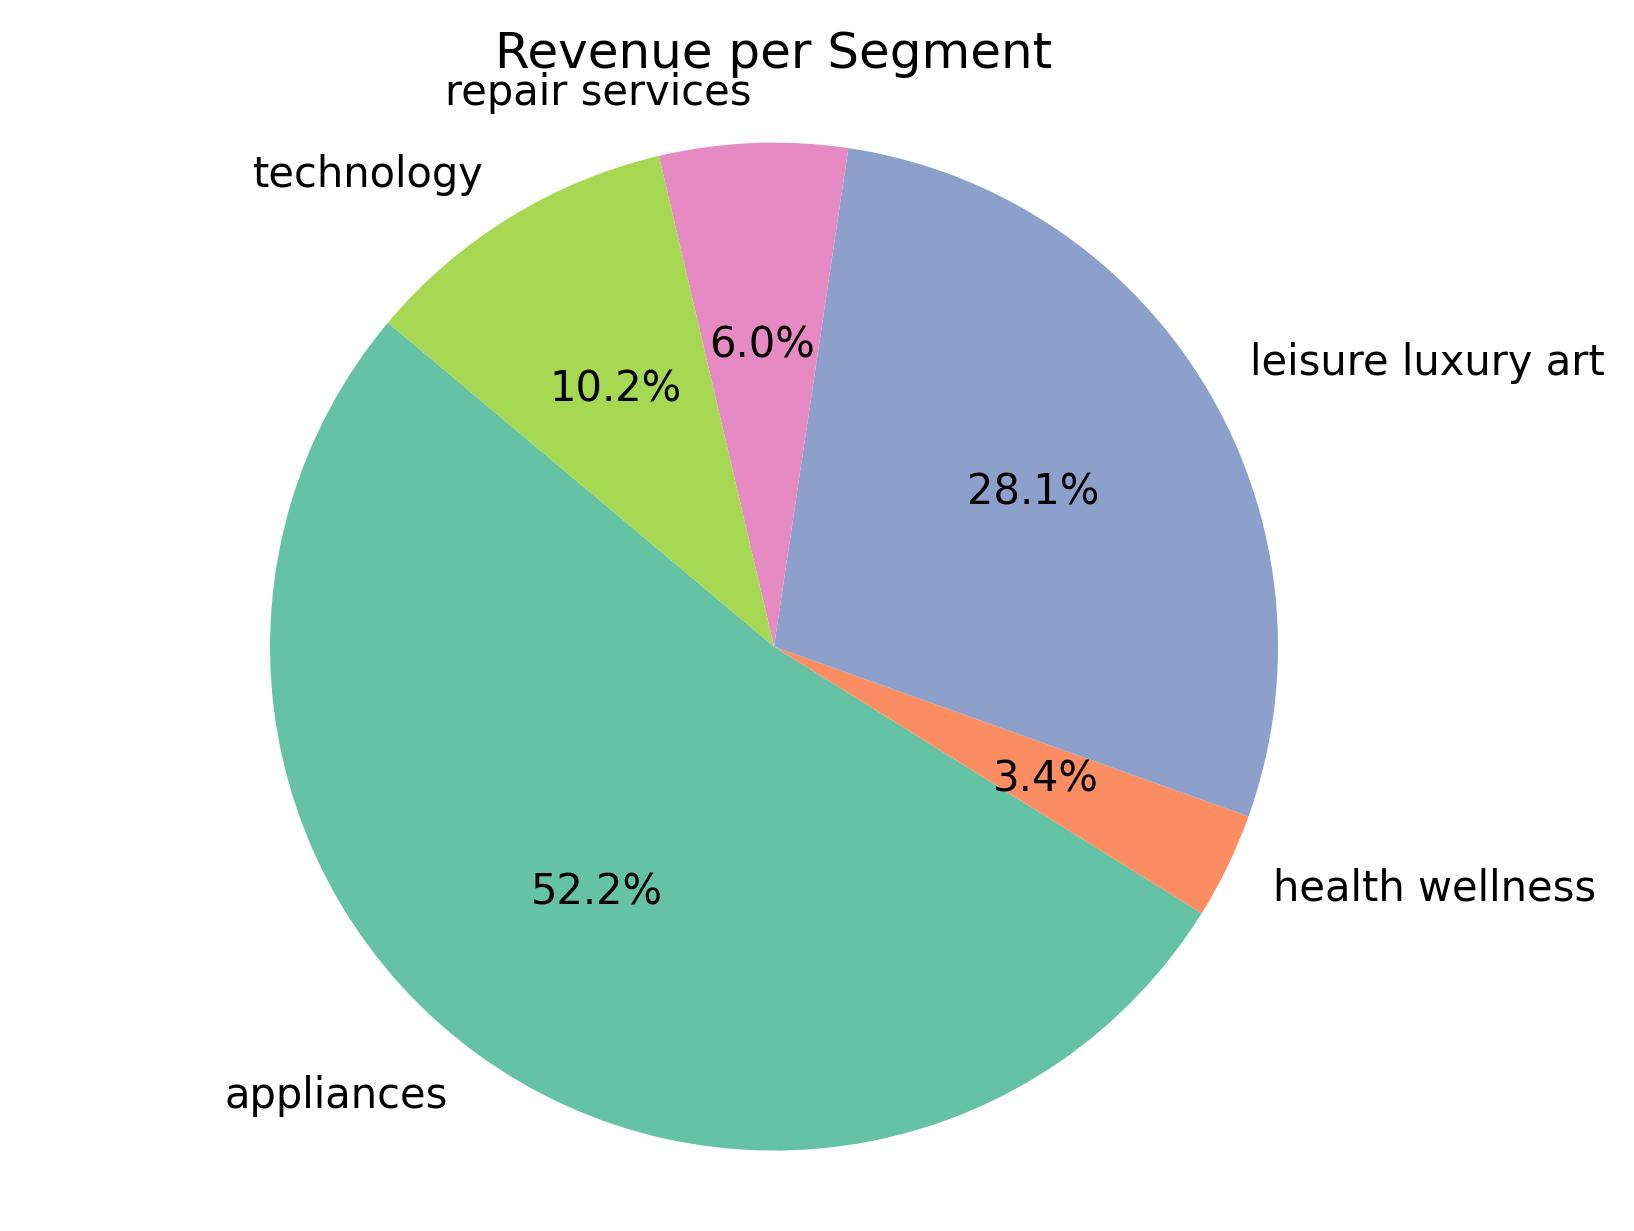

In [33]:
display.Image(f'{MERCHANT_SEGMENT_PLOT}/revenue_merchants.jpg', width=400)

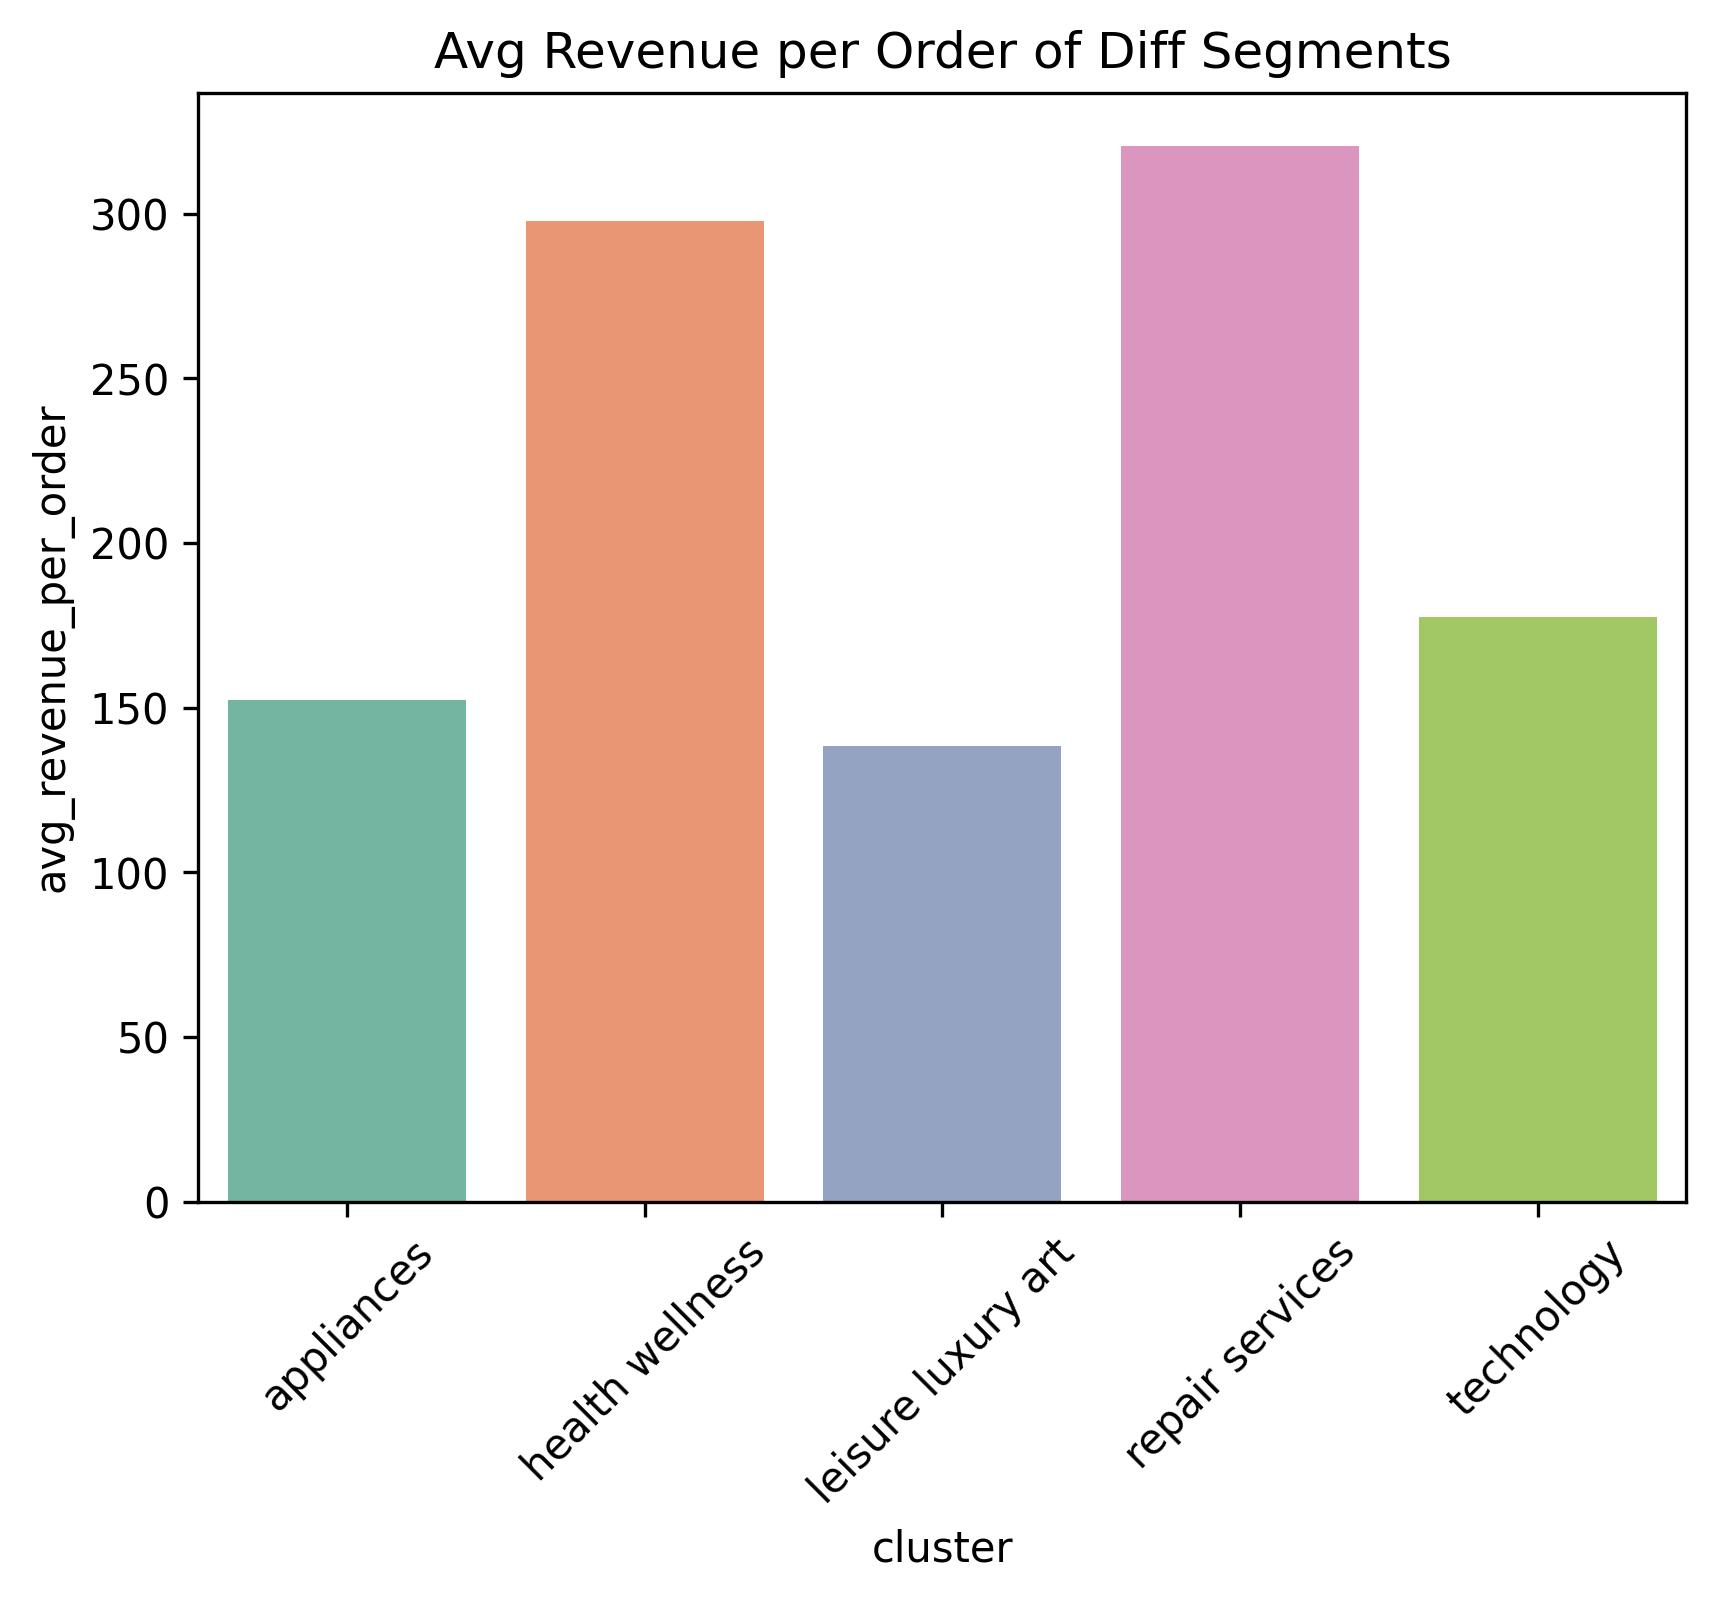

In [34]:
display.Image(f'{MERCHANT_SEGMENT_PLOT}/avg_revenue.jpg', width=400)

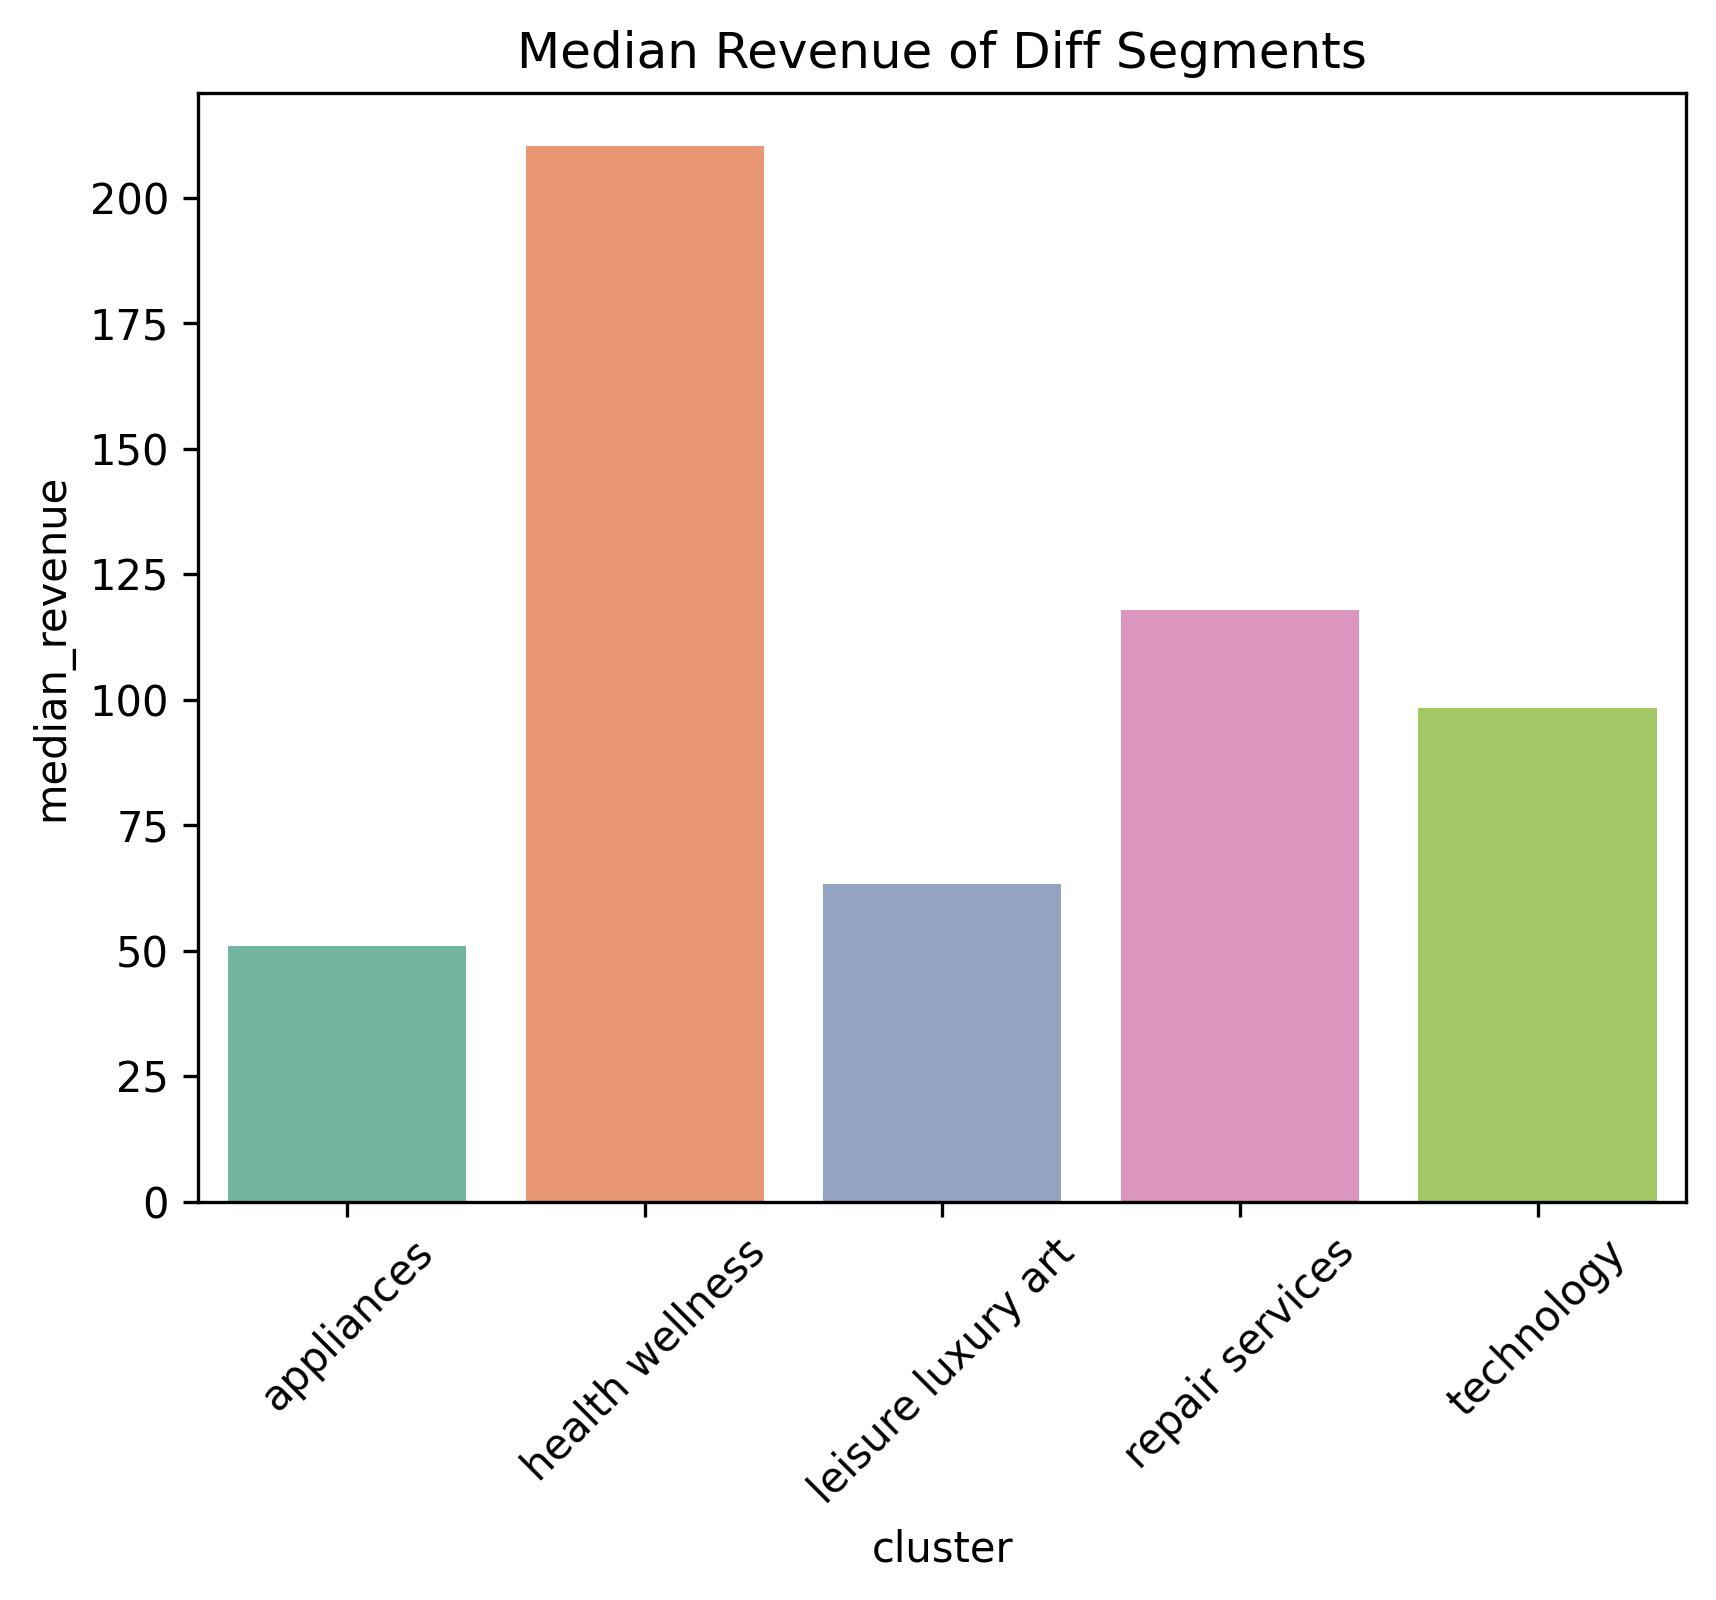

In [35]:
display.Image(f'{MERCHANT_SEGMENT_PLOT}/median_revenue.jpg', width=400)

## 5. Ranking Results 📈

In this section, we will show the final ranking of merchants based on our ranking system.

#### Top 10 Merchants Overall:

In [36]:
final_rank = (pd.read_pickle(f'{ANALYSIS_DATA}final_rank.pkl')).sort_values(by='rank')
final_rank = final_rank[['rank', 'merchant_abn', 'name', 'cluster', 'revenue_metric', 'external_metric', 'brand_metric', 'final_metric']]
final_rank.head(10)

rank  merchant_abn                           name             cluster  \
1399     1   40515428545  Elit Sed Consequat Associates  leisure luxury art   
1300     2   38090089066      Interdum Feugiat Sed Inc.          appliances   
1937     3   52594457116     Vel Turpis Aliquam Company     repair services   
1328     4   38700038932      Etiam Bibendum Industries          appliances   
3943     5   98072939449         Mattis Velit Justo Ltd  leisure luxury art   
2918     6   74589998324                       Nec Inc.          appliances   
3979     7   98973094975              Ornare Fusce Inc.  leisure luxury art   
3612     8   90578415511       A Scelerisque Foundation          appliances   
2443     9   64403598239      Lobortis Ultrices Company  leisure luxury art   
535     10   21772962346     Purus Gravida Sagittis Ltd          appliances   

      revenue_metric  external_metric  brand_metric  final_metric  
1399            15.0             1253           219        375.50  
1300            54.0             1558            31        424.25  
1937            78.0             1203           362        430.25  
1328             5.0             1317           394        430.25  
3943            68.0             1121           465        430.50  
2918           179.0              620           750        432.00  
3979            26.0             1705            28        446.25  
3612           176.0             1287           155        448.50  
2443            10.0             1762            13        448.75  
535             42.0             1661            58        450.75

#### Top 10 Merchants in Technology:  
(rank columns show the overall rank) 

In [37]:
top_10_tech = (pd.read_pickle(f'{ANALYSIS_DATA}technology_top_10.pkl')).sort_values(by='rank')
top_10_tech  = top_10_tech[['rank', 'merchant_abn', 'name', 'cluster']]
top_10_tech

rank  merchant_abn                                name     cluster
1609    14   45244796758                     Vitae Dolor LLP  technology
1622    24   45433476494          Adipiscing Elit Foundation  technology
1430    26   41271931352                   Ac Sem Ut Company  technology
2190    31   58454491168                  Diam At Foundation  technology
1119    37   34096466752                     Nullam Enim Ltd  technology
2616    63   68216911708     Placerat Eget Venenatis Limited  technology
1213    67   35909341340            Arcu Sed Eu Incorporated  technology
3798    69   94690988633                     Eu Placerat LLC  technology
3042    71   77338620996                 Fames Ac Turpis LLC  technology
2458    80   64732735902  Imperdiet Non Vestibulum Institute  technology

#### Top 10 Merchants in Leisure, Luxury, Art:

In [38]:
top_10_leisure = (pd.read_pickle(f'{ANALYSIS_DATA}leisure luxury art_top_10.pkl')).sort_values(by='rank')
top_10_leisure  = top_10_leisure[['rank', 'merchant_abn', 'name', 'cluster']]
top_10_leisure

rank  merchant_abn                           name             cluster
1399     1   40515428545  Elit Sed Consequat Associates  leisure luxury art
3943     5   98072939449         Mattis Velit Justo Ltd  leisure luxury art
3979     7   98973094975              Ornare Fusce Inc.  leisure luxury art
2443     9   64403598239      Lobortis Ultrices Company  leisure luxury art
2821    11   72738688428             Donec Tempor Corp.  leisure luxury art
3135    17   79417999332           Phasellus At Company  leisure luxury art
1655    20   46012371285               A Ultricies Inc.  leisure luxury art
3792    32   94493496784  Dictum Phasellus In Institute  leisure luxury art
1033    33   32361057556  Orci In Consequat Corporation  leisure luxury art
2290    35   60956456424        Ultricies Dignissim LLP  leisure luxury art

#### Top 10 Merchants in Health and Wellness:

In [39]:
top_10_health = (pd.read_pickle(f'{ANALYSIS_DATA}health wellness_top_10.pkl')).sort_values(by='rank')
top_10_health  = top_10_health[['rank', 'merchant_abn', 'name', 'cluster']]
top_10_health

rank  merchant_abn                             name          cluster
2846    52   73256306726                           Id LLP  health wellness
1547   108   43650058736             Malesuada Consulting  health wellness
383    115   18303734841            Sollicitudin Orci Ltd  health wellness
3541   174   88699453206                     Sed Nec Inc.  health wellness
378    176   18158387243                   Nec Tellus Ltd  health wellness
645    184   24043105437        Enim Nec Tempus Institute  health wellness
1471   204   41980722395                   Aliquet Nec PC  health wellness
1698   208   46953117138           Eu Accumsan Foundation  health wellness
1946   215   52794670013             Semper Pretium Corp.  health wellness
2909   221   74391255526  Vitae Semper Egestas Foundation  health wellness

#### Top 10 Merchants in Repair Services:

In [40]:
top_10_repair = (pd.read_pickle(f'{ANALYSIS_DATA}repair services_top_10.pkl')).sort_values(by='rank')
top_10_repair  = top_10_repair[['rank', 'merchant_abn', 'name', 'cluster']]
top_10_repair

rank  merchant_abn                           name          cluster
1937     3   52594457116     Vel Turpis Aliquam Company  repair services
1309    30   38337815814         Eget Venenatis Limited  repair services
2854    41   73489866331             Eu Dui Cum Company  repair services
2727    85   70620117107        Ante Vivamus Consulting  repair services
2989   120   76078244980                    Nec Quam PC  repair services
3142   127   79633007926              Auctor Vitae Inc.  repair services
2003   132   54272781746            Non Massa Institute  repair services
2358   147   62583219931  Mi Lacinia Mattis Corporation  repair services
3014   157   76626119831    Tristique Pellentesque Inc.  repair services
2634   189   68559320474      Aliquam Auctor Associates  repair services

#### Top 10 Merchants in Appliances:

In [41]:
top_10_appliances = (pd.read_pickle(f'{ANALYSIS_DATA}appliances_top_10.pkl')).sort_values(by='rank')
top_10_appliances = top_10_appliances[['rank', 'merchant_abn', 'name', 'cluster']]
top_10_appliances

rank  merchant_abn                             name     cluster
1300     2   38090089066        Interdum Feugiat Sed Inc.  appliances
1328     4   38700038932        Etiam Bibendum Industries  appliances
2918     6   74589998324                         Nec Inc.  appliances
3612     8   90578415511         A Scelerisque Foundation  appliances
535     10   21772962346       Purus Gravida Sagittis Ltd  appliances
2890    12   74063123996             Nec Eleifend Non Ltd  appliances
65      13   11439466003                   Blandit At LLC  appliances
3833    15   95574756848                     At Pede Inc.  appliances
561     16   22227727512  Malesuada Integer Id Foundation  appliances
3439    18   86578477987                Leo In Consulting  appliances

#### Distribution of Top 100 Merchant Categories

We observe that a large portion of the top 100 merchants belong to the Appliances sector, followed by the Leisure, Luxury and Art sector, Technology sector, Repair Services, and lastly, Health and Wellness sector. The distribution of the Top 100 Merchants is somewhat consistent with the distribution of the number of merchants.

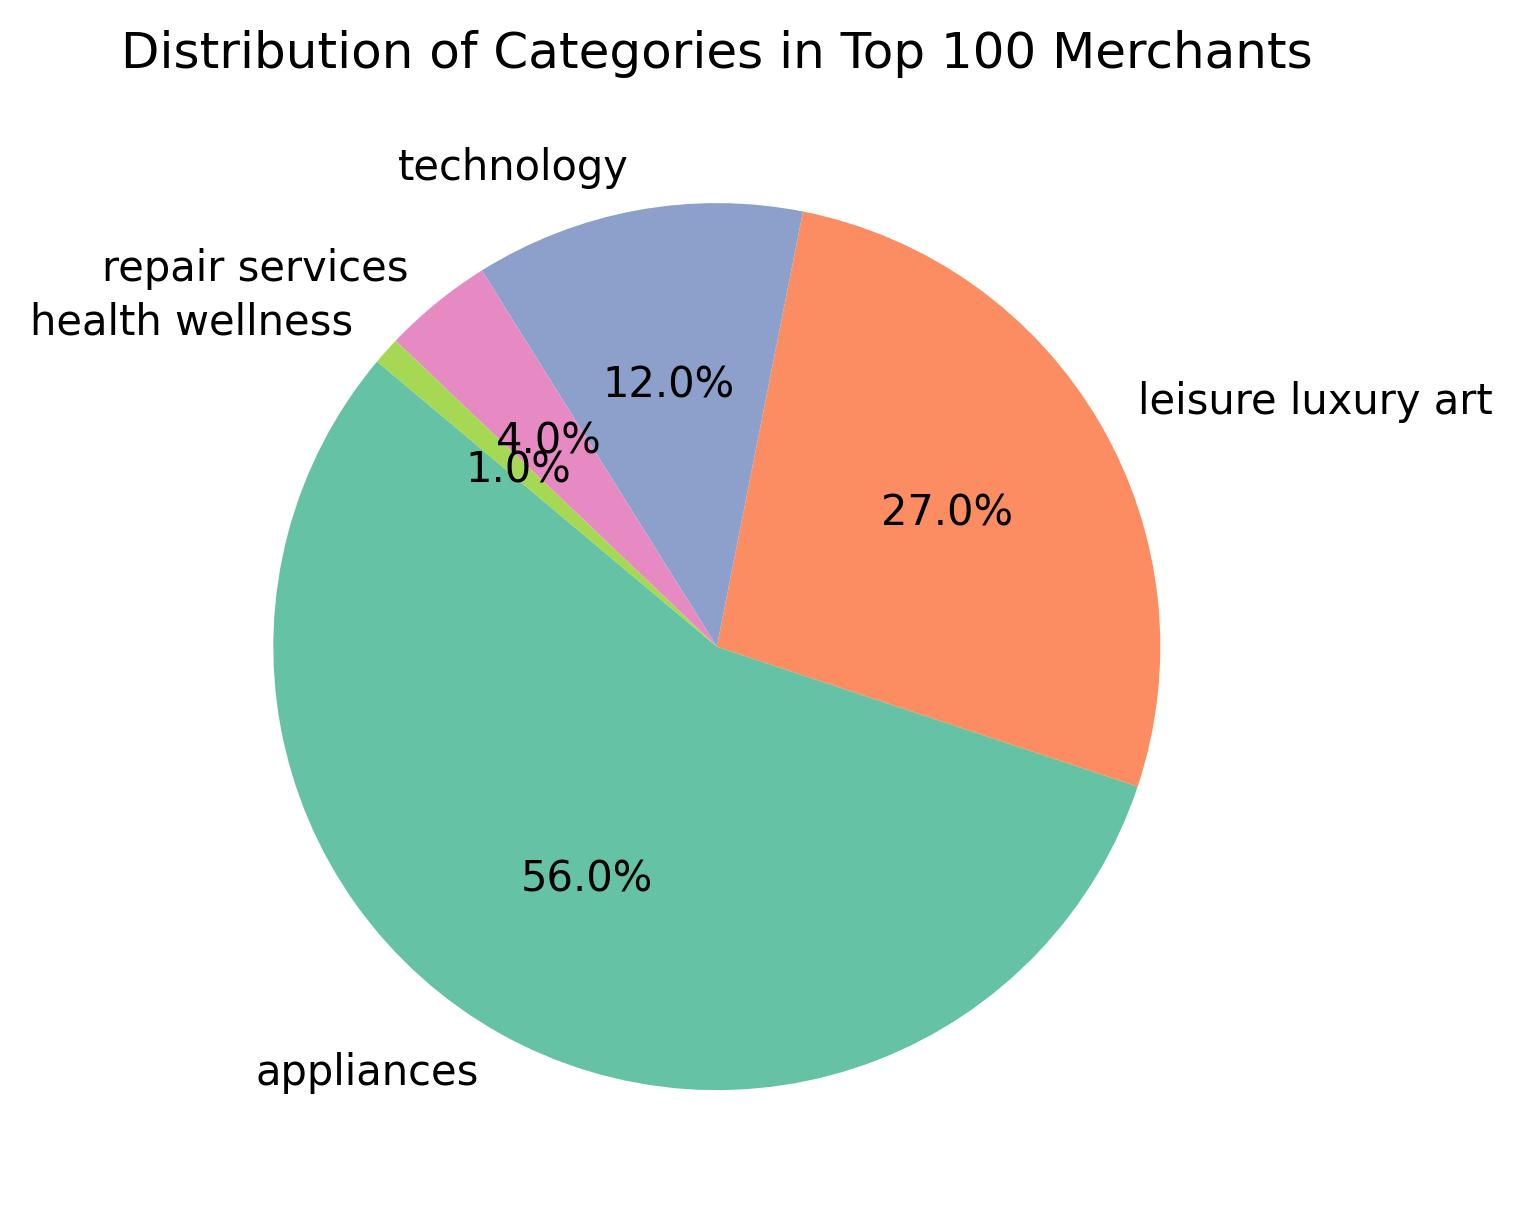

In [42]:
display.Image(f'{RANKING}top100_merchants.jpg', width=500)

#### Ranking Comparisons Between Metrics

The comparison between brand and revenue ranking shows that there is indeed a correlation between these two metrics as revenue is closely tied with the number of customers. However, we still decided to include both metrics as it is reasonable to project growth through both customers and postcode coverage.

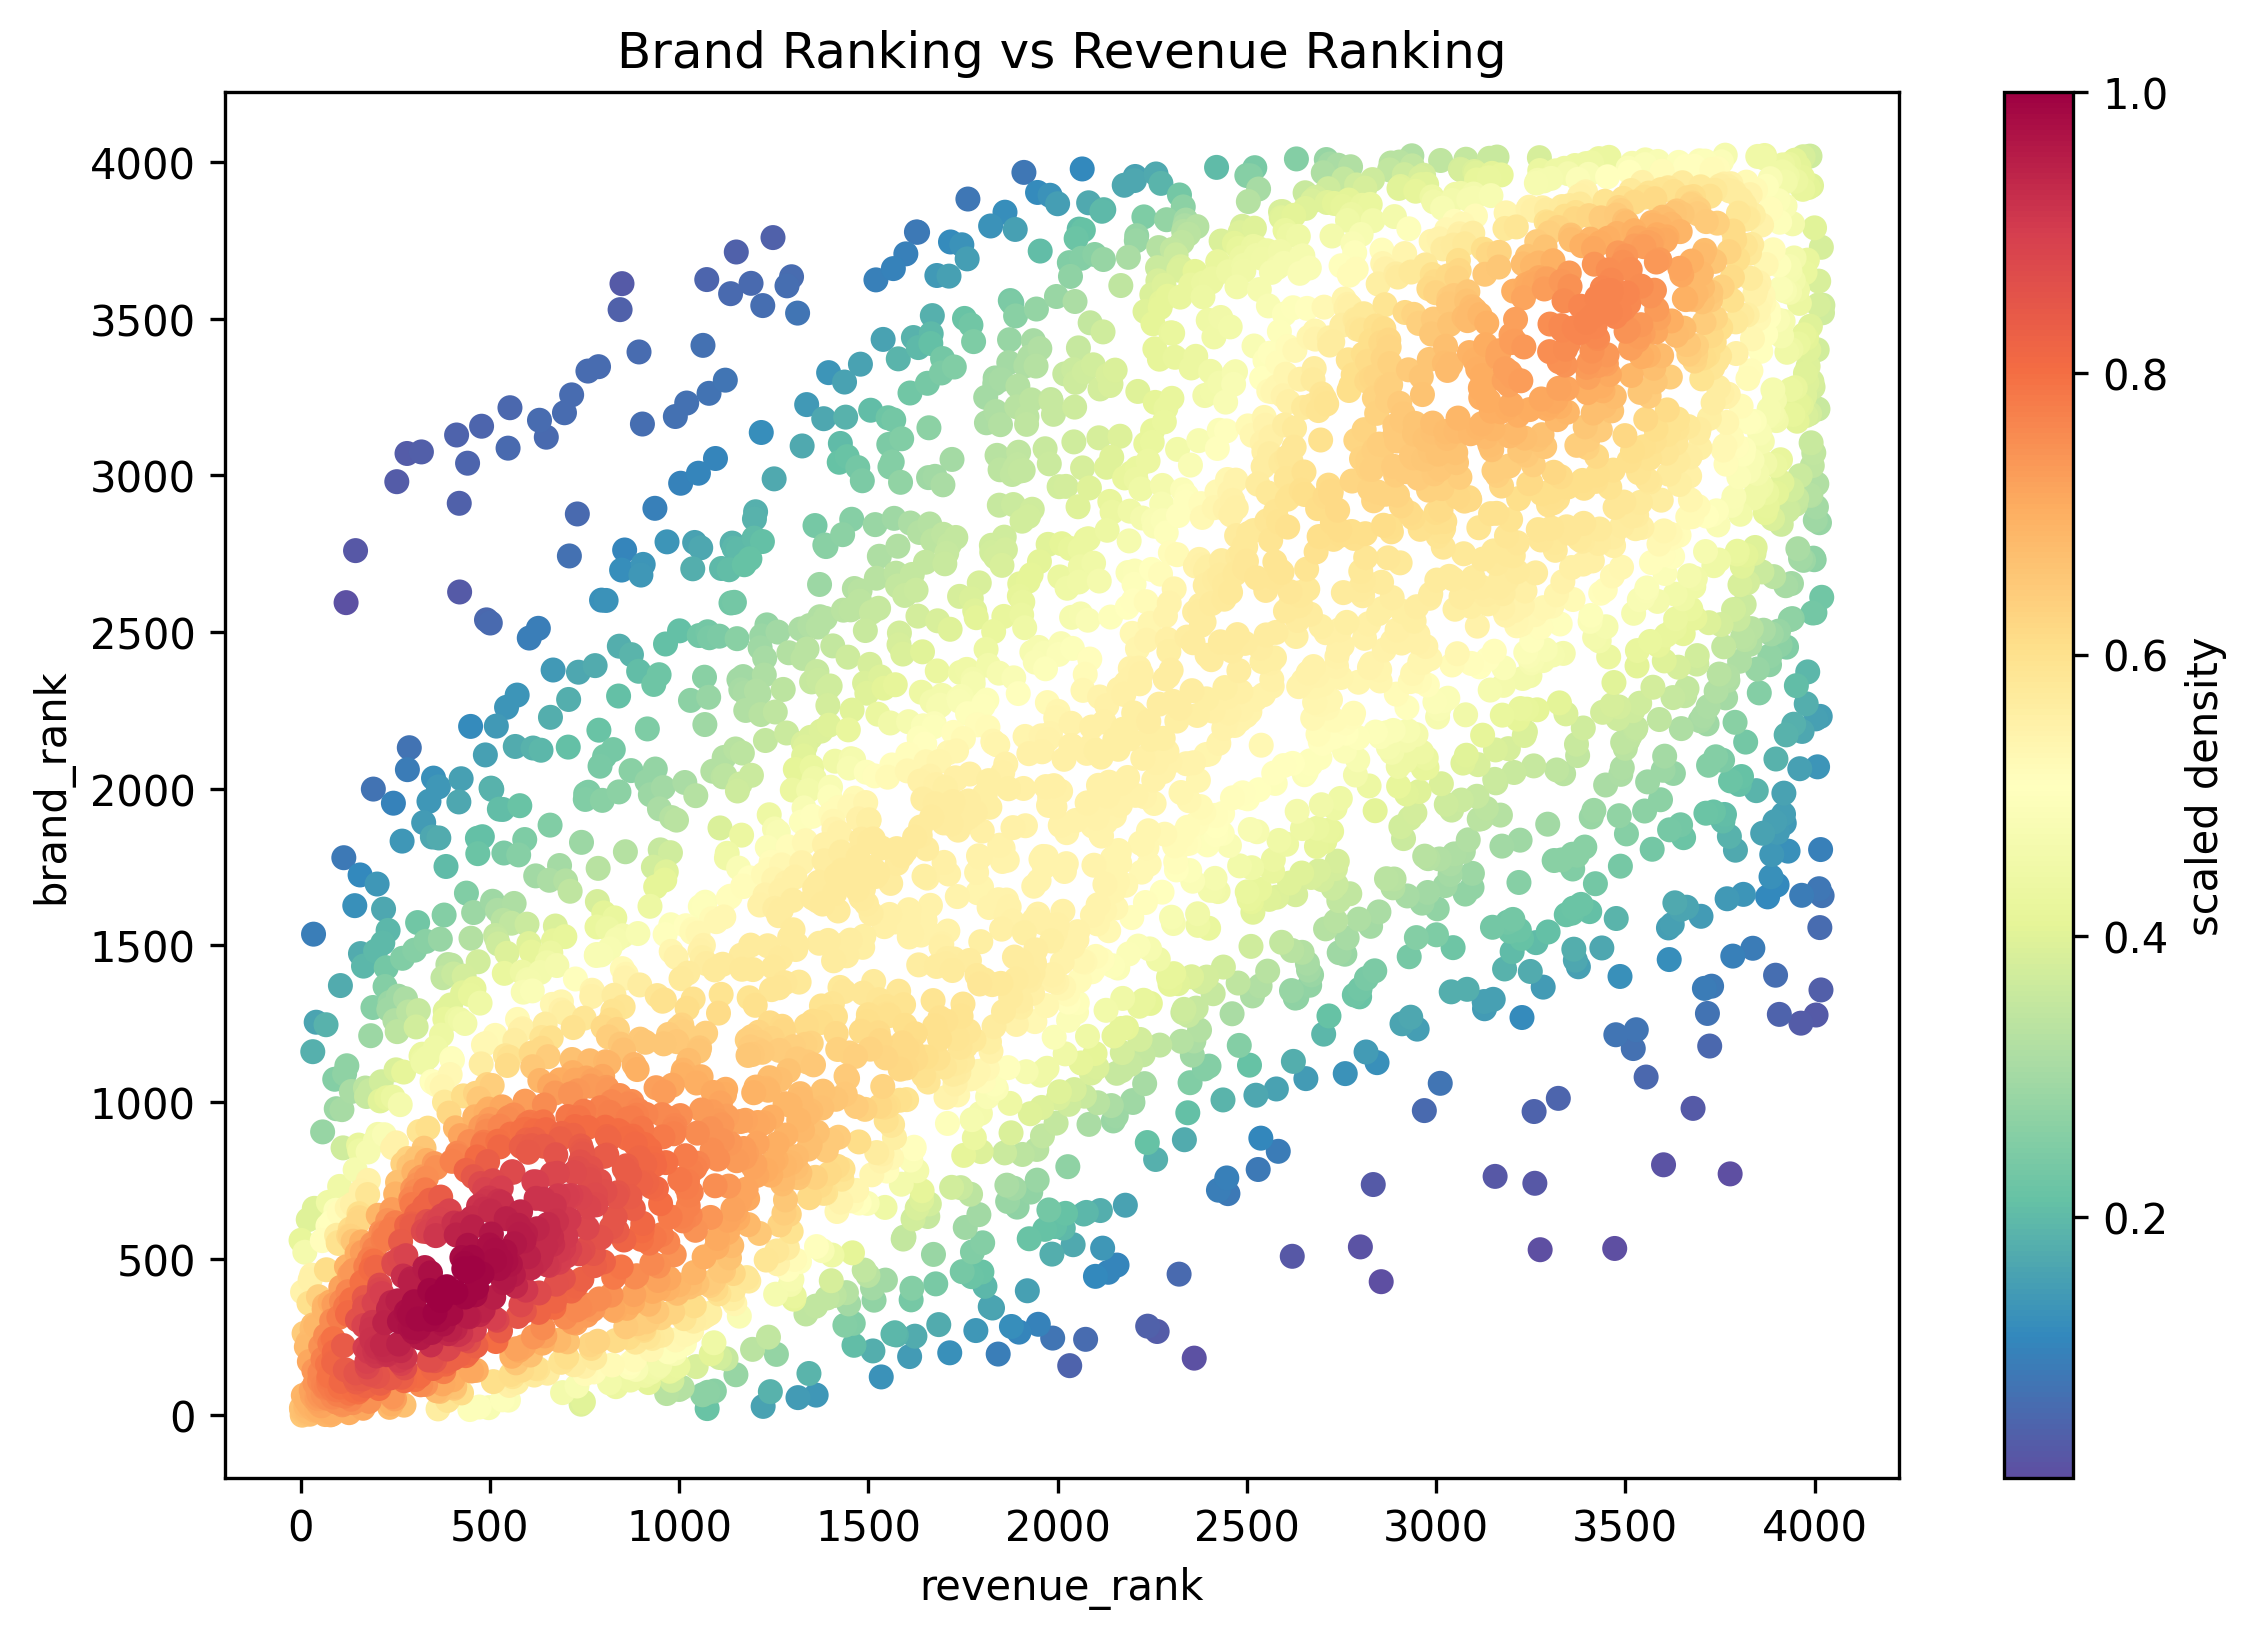

In [43]:
display.Image(f'{RANKING}rank_compare2.png', width=500)

This plot of the demographic metric in relation to revenue reveals that top-ranked merchants are concentrated around mid-range demographics which means that targeting mid-range postcodes can be a useful strategy to maximize our ranking.

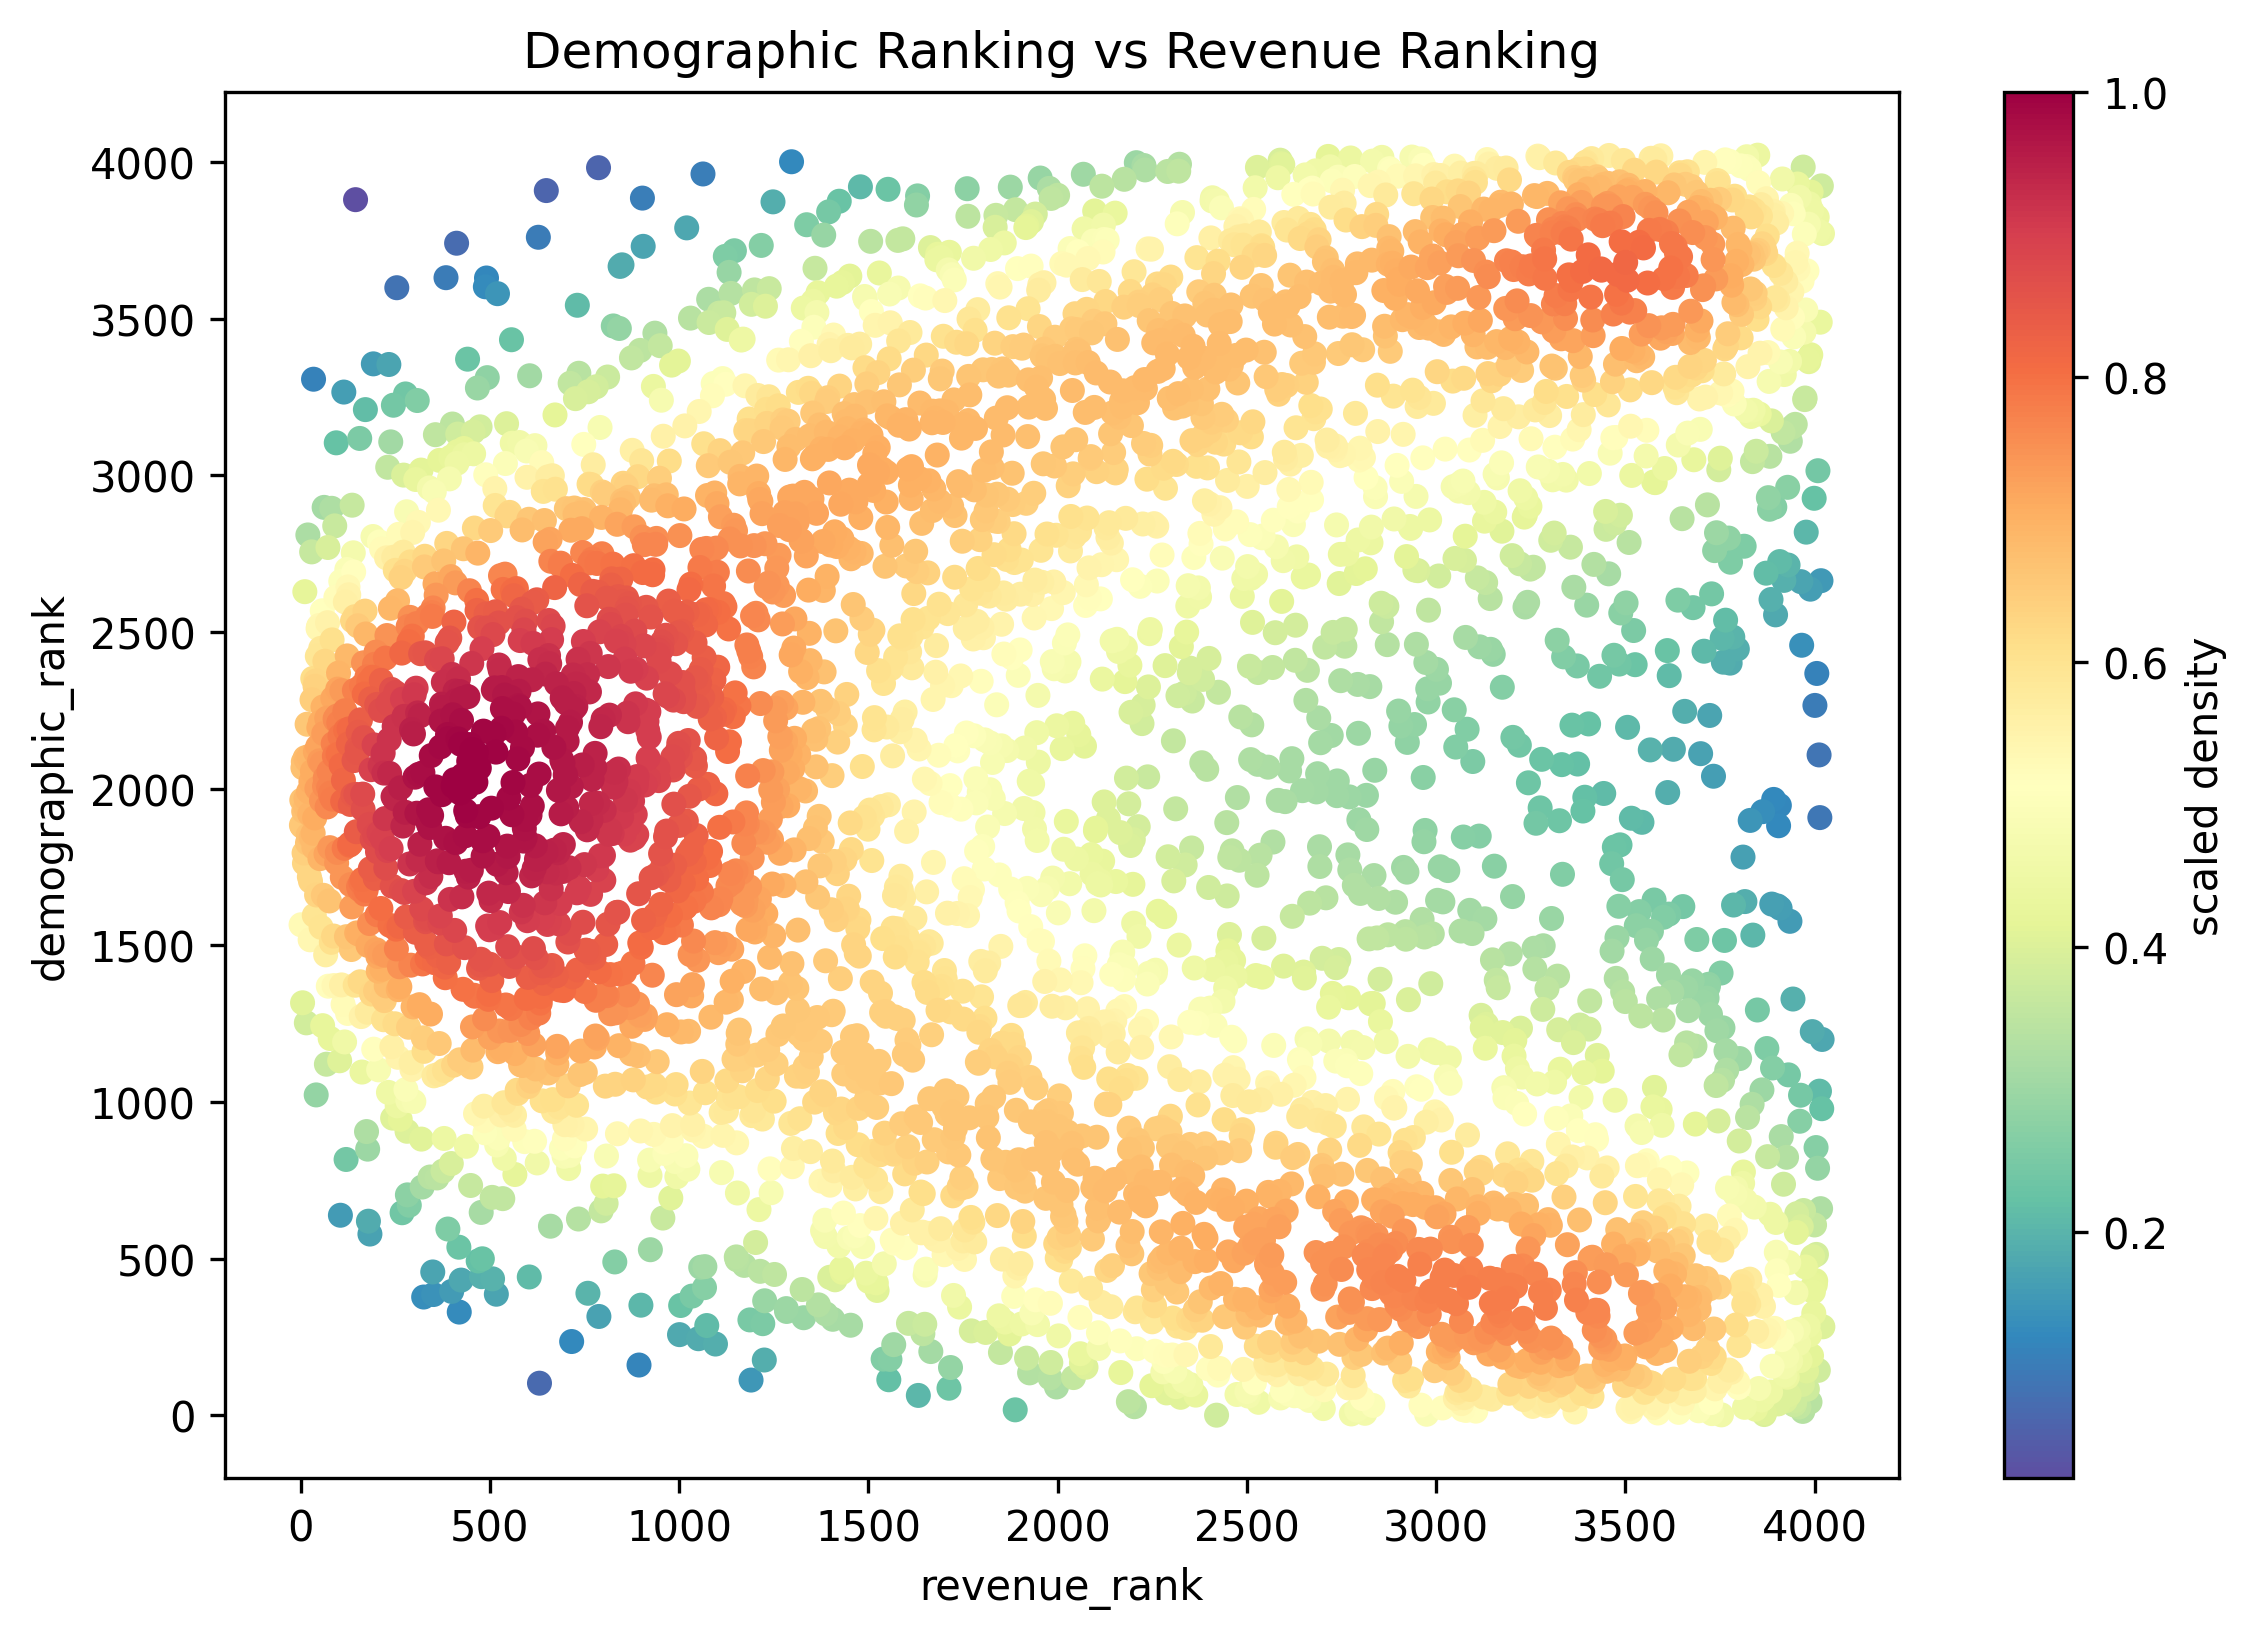

In [44]:
display.Image(f'{RANKING}rank_compare1.png', width=500)

However, the unusual distribution for low-ranked merchants (by revenue) requires further investigation. 

## 6. Merchant Insights 🔍

Although the ranking has provided the top 100 merchants based on our metrics, there are a few "interesting" aspects of merchants that we need to consider before making our final decision which will be explored in this section.

#### 1. Merchants with very small number of consumers but make large purchases
These are the merchant ABNs that may not have a large number of customers, but each customer's spending is significant. They may have high customer loyalty, however relying on a small group of customers can be risky. If one or more of these customers stop purchasing, it can significantly impact the merchant's revenue.

| Merchant ABN | Number of Users | Total Spending | Average Spending per User |
| ------------ | ----------------| -------------- | ------------------------- |
| 42461534060  |        2        |   50232.5563	  |        25116.27815        |
| 10404542215  |        1        |   22773.9753	  |         22773.9753        |
| 28311306642  |        2        |   43994.4543	  |         21997.22715       |
| 62688594508  |        1	     |   21112.5679	  |          21112.5679       |
| 28385291716  |        5        | 	99793.4307	  |    19958.686139999998     |

#### 2. Merchants with Large Consumer Transactions but Low Economic Resources Score

Consumers with low average economic resources score may indicate: they are more likely to have lower incomes, or they are paying lower rent for their housing. High spending by consumers with low economic resources may suggest that they are living beyond their means or relying on credit, which could lead to financial instability and difficulty in repaying debts, and could pose a potential risk for our company if we decide to onboard these merchants.

| Merchant ABN |Average Spending |  Average ERS   | Ratio Spending to ERS     |
| ------------ | ----------------| -------------- | ------------------------- |
| 62688594508  |    21112.5679	 |  749.3676996	  |     28.17384297624455     |  
| 42461534060  |   25116.27815	 |  938.66870912  |     26.75734037576096     |
| 10404542215  |    22773.9753	 |  1006.4571748  |     22.627863231762017    |
| 28311306642  |  21997.22715	 |  1037.5200848  |     21.201736209511882    |
| 64094501963  |   18365.7611    |  932.61770893  |      19.69270036816177    |

#### 3. Some merchants have a high number of returning customers, some have none

Merchants with a substantial number of returning customers signifies a strong customer base and a steady stream of revenue which is highly beneficial for our company. However, 34.54% of merchants have 0 returning customers


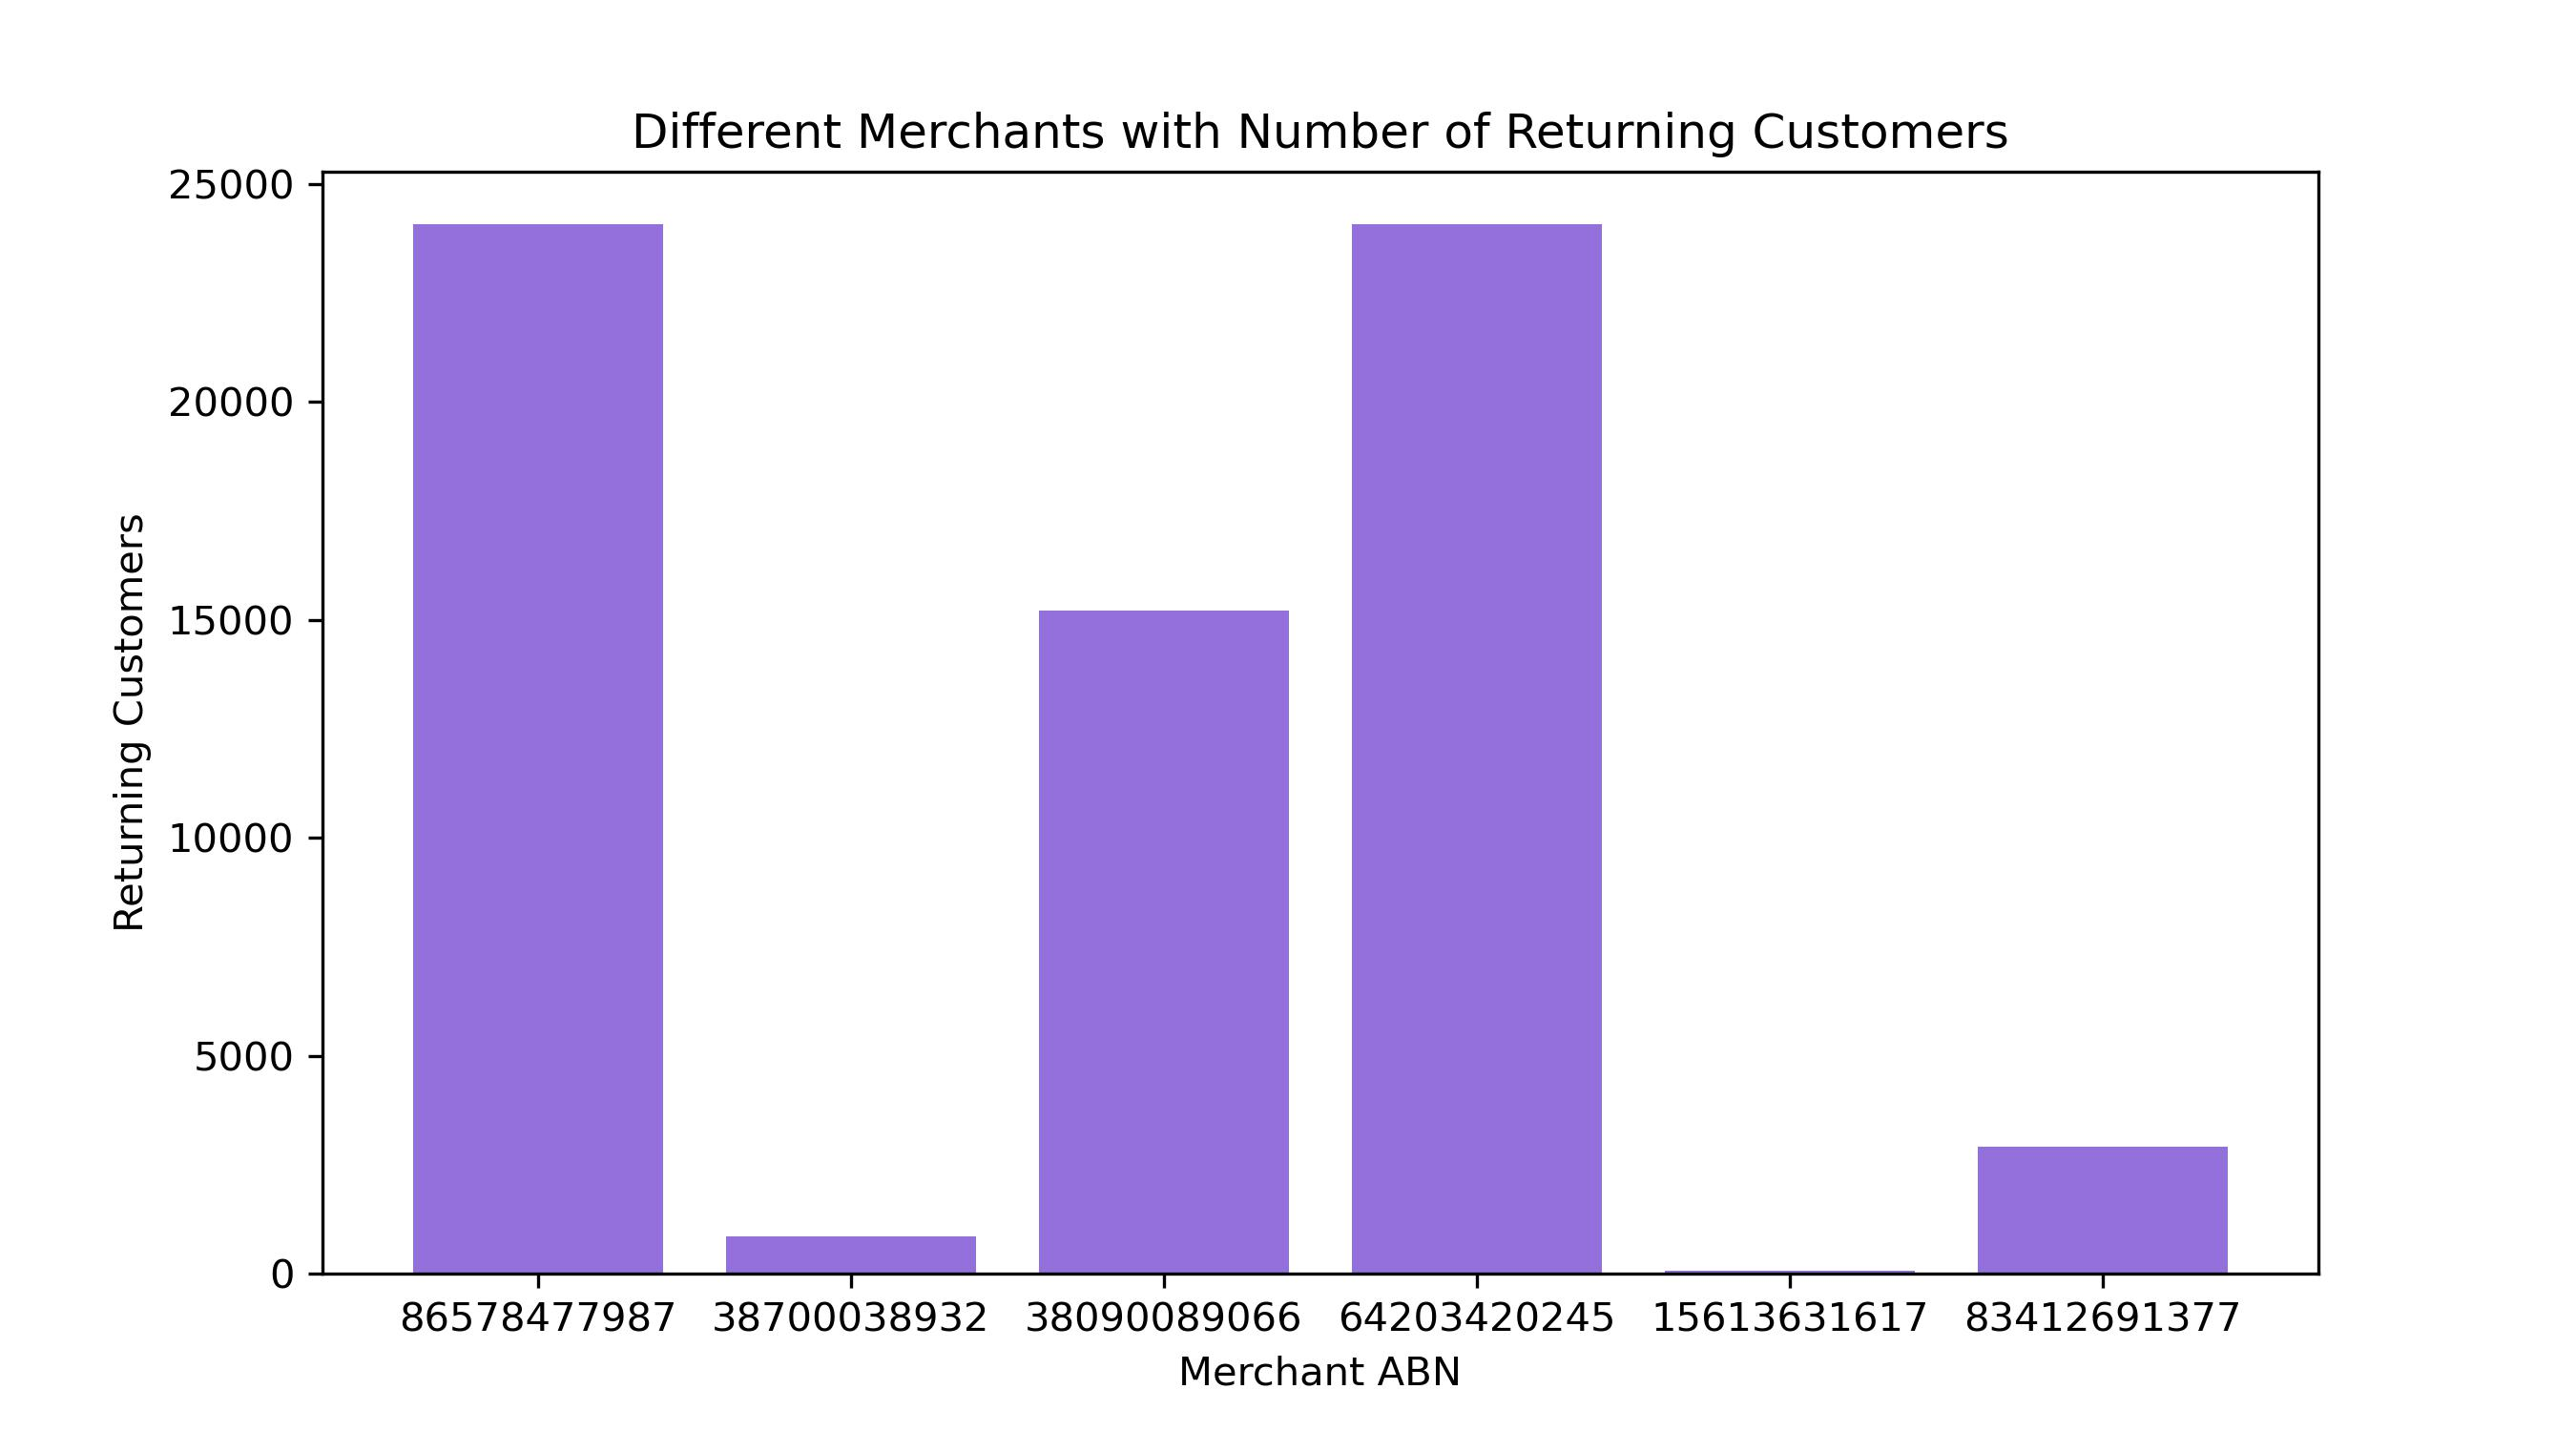

In [45]:
display.Image(f'{MERCHANT_INSIGHTS}returning_customers.jpg', width=700)

#### 4. Merchants that are exposed to most of the regions across Australia

There are nearly 3,333 postal areas in Australia, therefore these merchants have very high exposure and presence of transactions in almost all regions across the country.

| Merchant ABN    | Number of Postcodes Covered |
| ------------    | --------------------------  |
| 45629217853	  | 3165                        |
| 64403598239	  | 3165                        |
| 86578477987	  |3165                         |
| 89726005175	  |3165                         |
| 63290521567	  |3165                         |


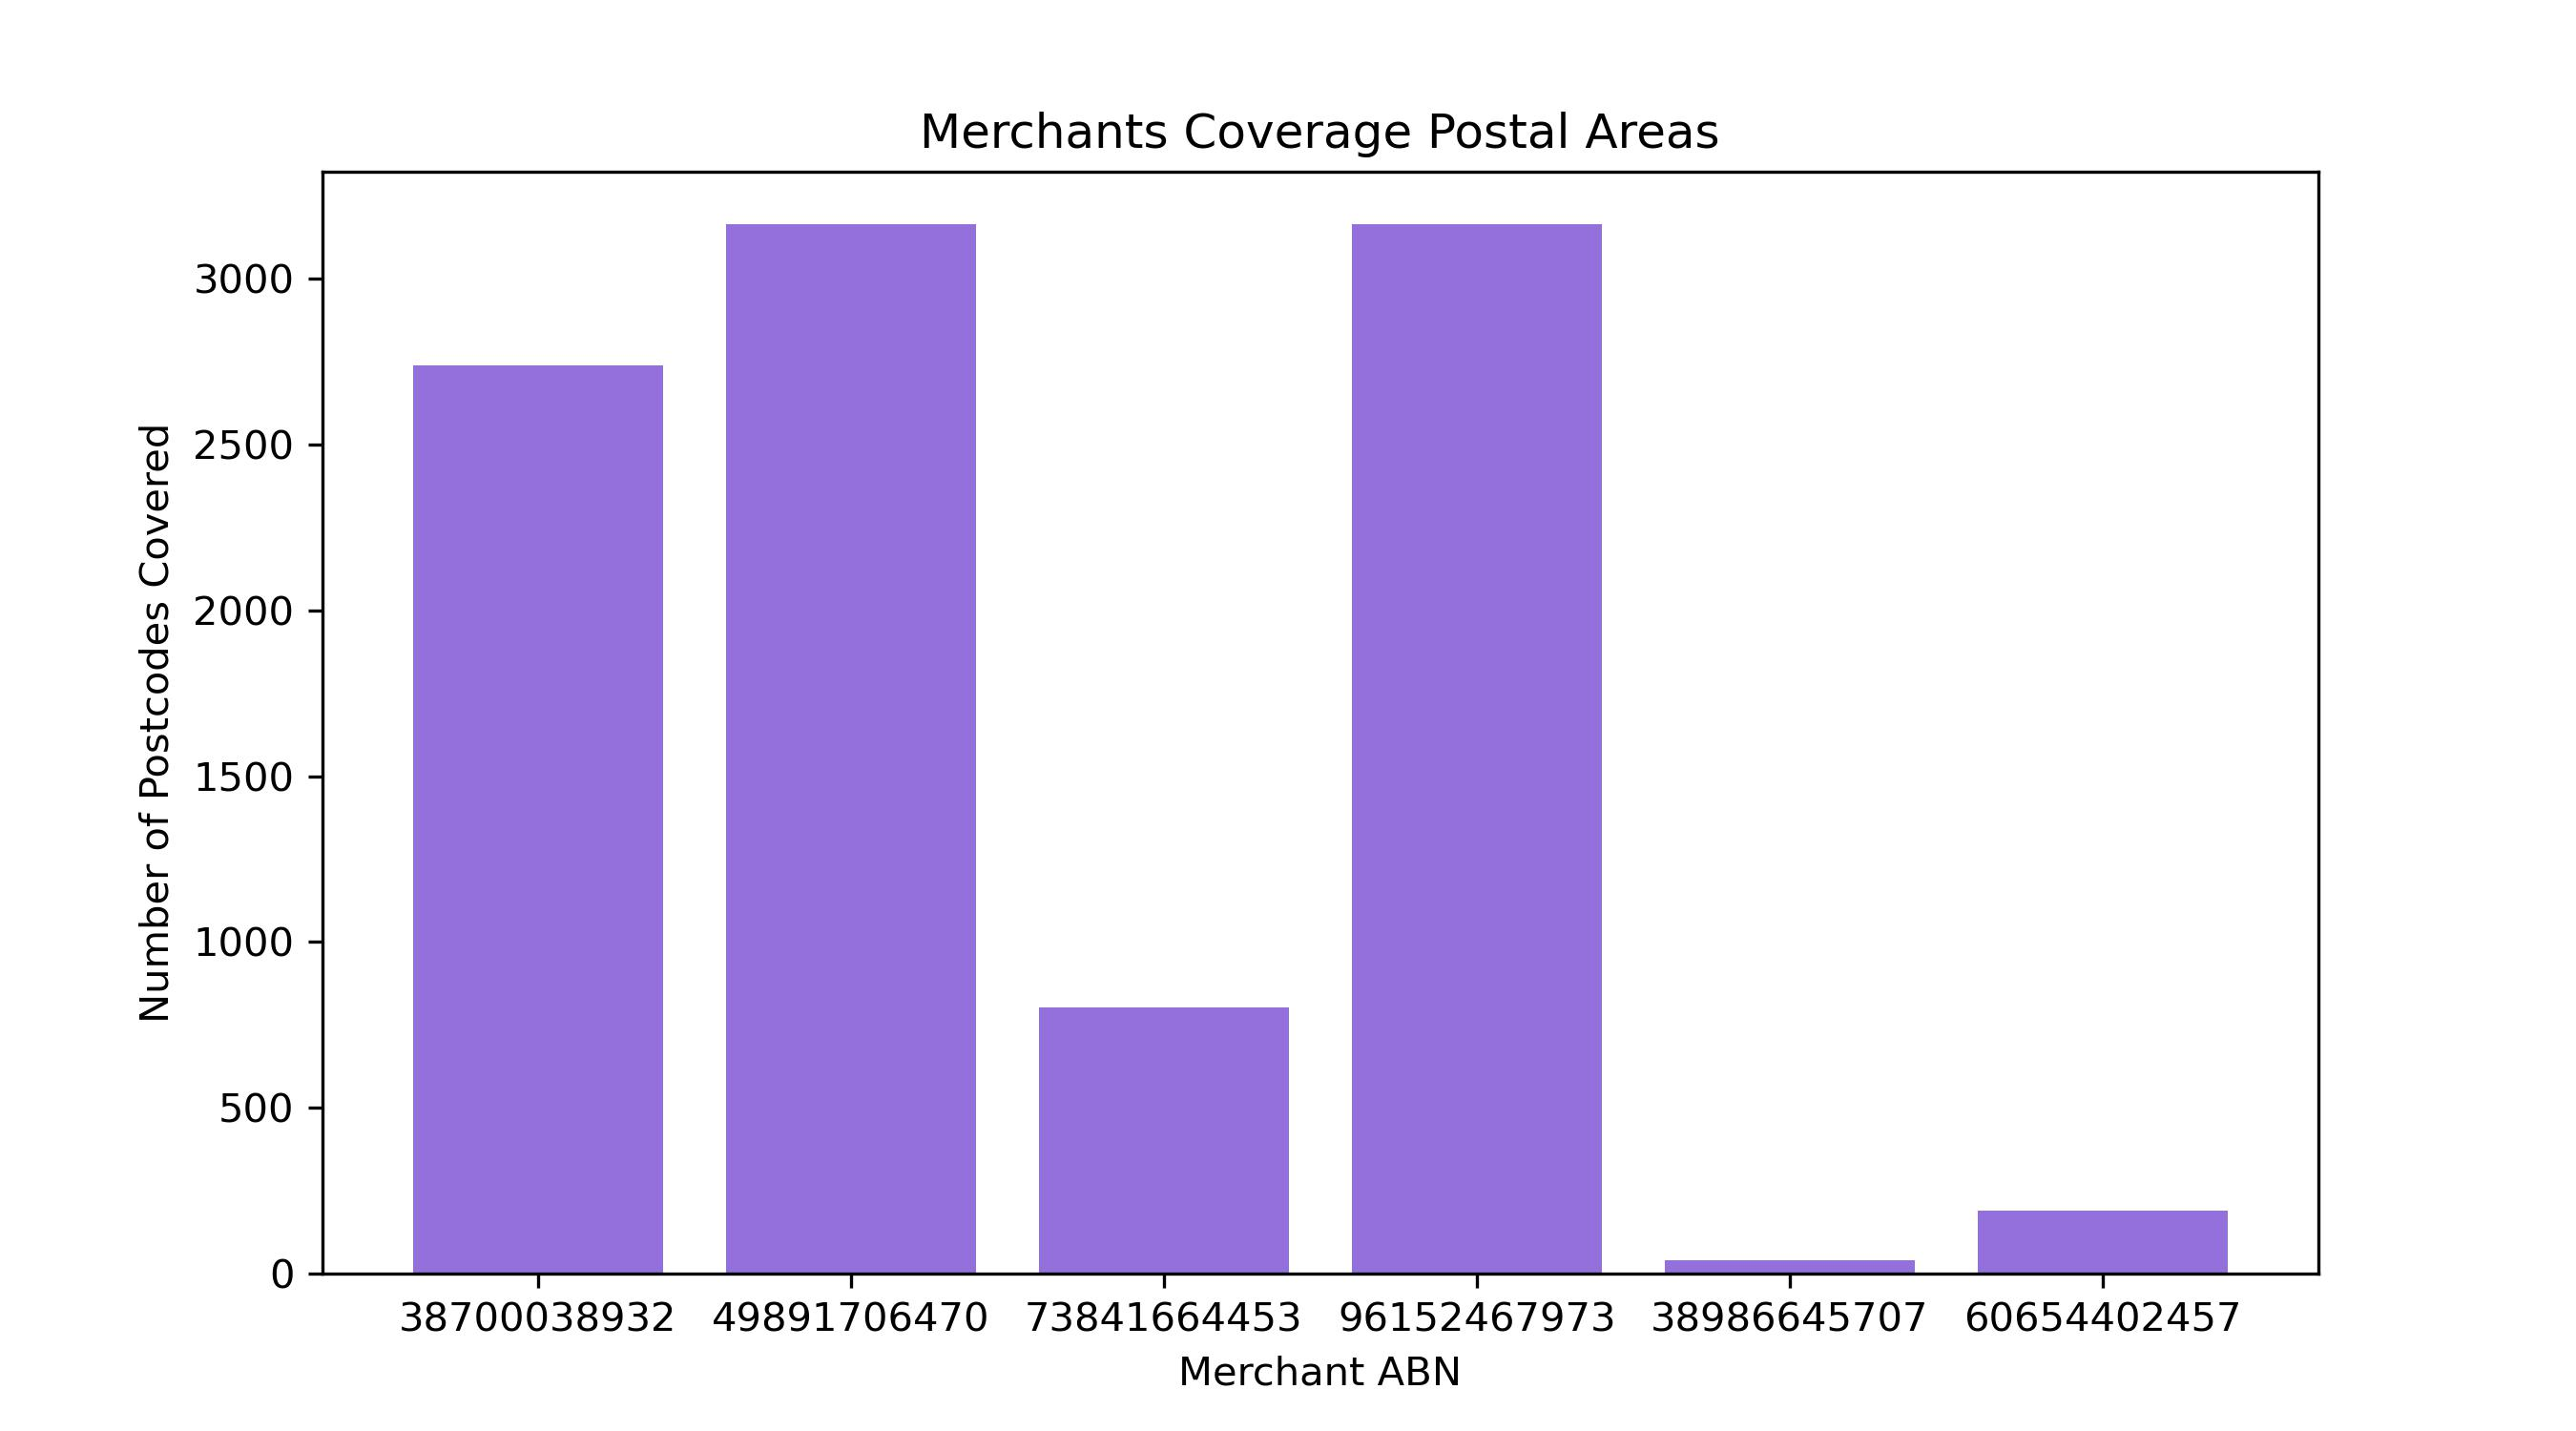

In [46]:
display.Image(f'{MERCHANT_INSIGHTS}coverage_postal_areas.jpg', width=700)

#### 5. Merchants with customers from low populated areas

The following merchants have merchants in areas with minimum population in our data.

| Merchant ABN    | Population |
| ------------    | ---------  |
| 83412691377     | 4          |
| 35344855546	  | 4          |
| 73841664453	  | 4          |
| 73256306726	  | 4          |
| 38700038932	  | 4          |

Onboarding merchants that are exposed to low-populated areas can have both advantages and disadvantages, as it can help expand our market reach but they may have lower transaction volumes, and serving remote areas could including higher delivery costs which can affect our revenue potential.

#### 6. Merchants with large consumer base but high average consumer fraud rates

While a large consumer base can offer significant opportunities, it would be useful to acknowledge that this also comes with increased exposure to potential fraudulent activities and associated risks. 

| Merchant ABN    | Number of Users | Average Consumer Fraud |
| ------------    | --------------  | ---------------------- |
| 38700038932	  |      6170	    |  0.612060173654606     |
| 82368304209	  |      4649	    |  1.6185477573651799    |
| 70009327857	  |      4454	    |  0.7693712327413672	 |
| 79827781481	  |      4314	    |  1.8077180172652763    |
| 75454398468	  |      5320	    |  0.6805023907149388    |
| 87084550311	  |      4366	    | 0.6708320553370156     |

#### 7. Merchants have different revenue growths throughout the year

Revenue growth can exhibit varying patterns across different merchants. Revenue performance highlights the importance of careful merchant selection and ongoing monitoring to ensure they can adapt to changing market dynamics and minimize risks associated with revenue fluctuations.

These merchants have the higest growth rate in 2022 compared to 2021.


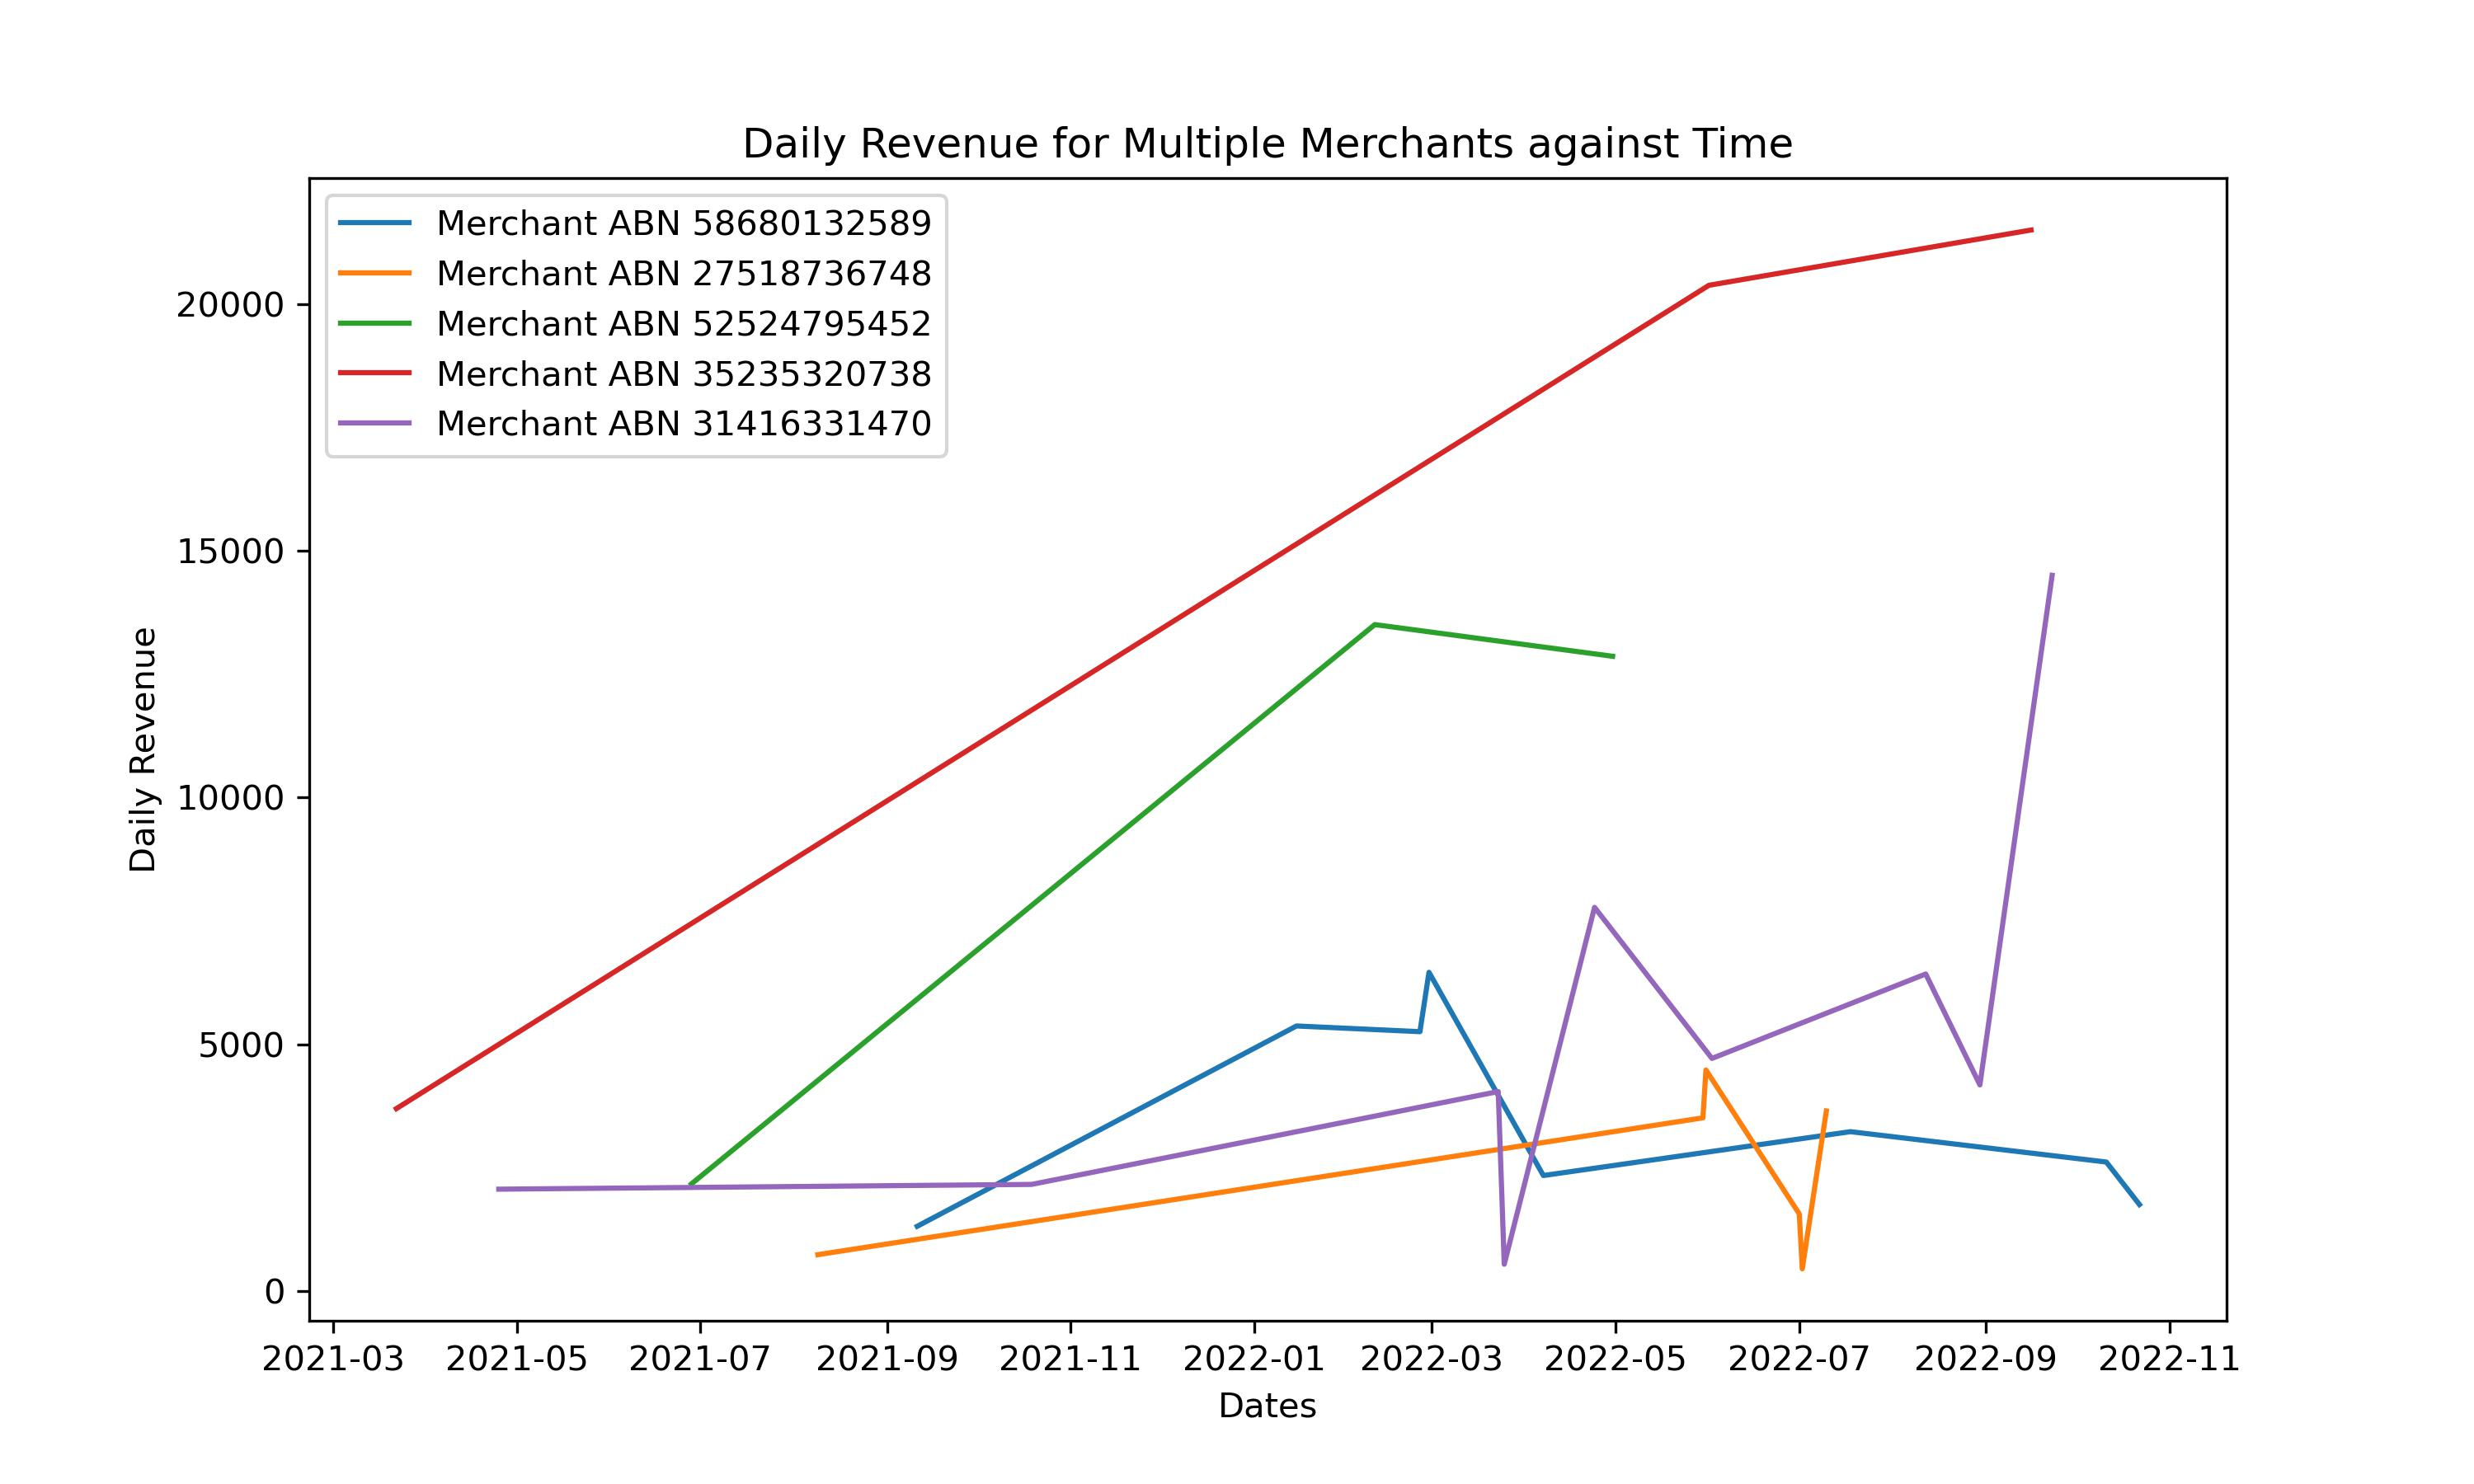

In [47]:
display.Image(f'{MERCHANT_INSIGHTS}daily_revenue_one.jpg', width=700)

Some other merchant's revenue growth rate were plotted and compared.

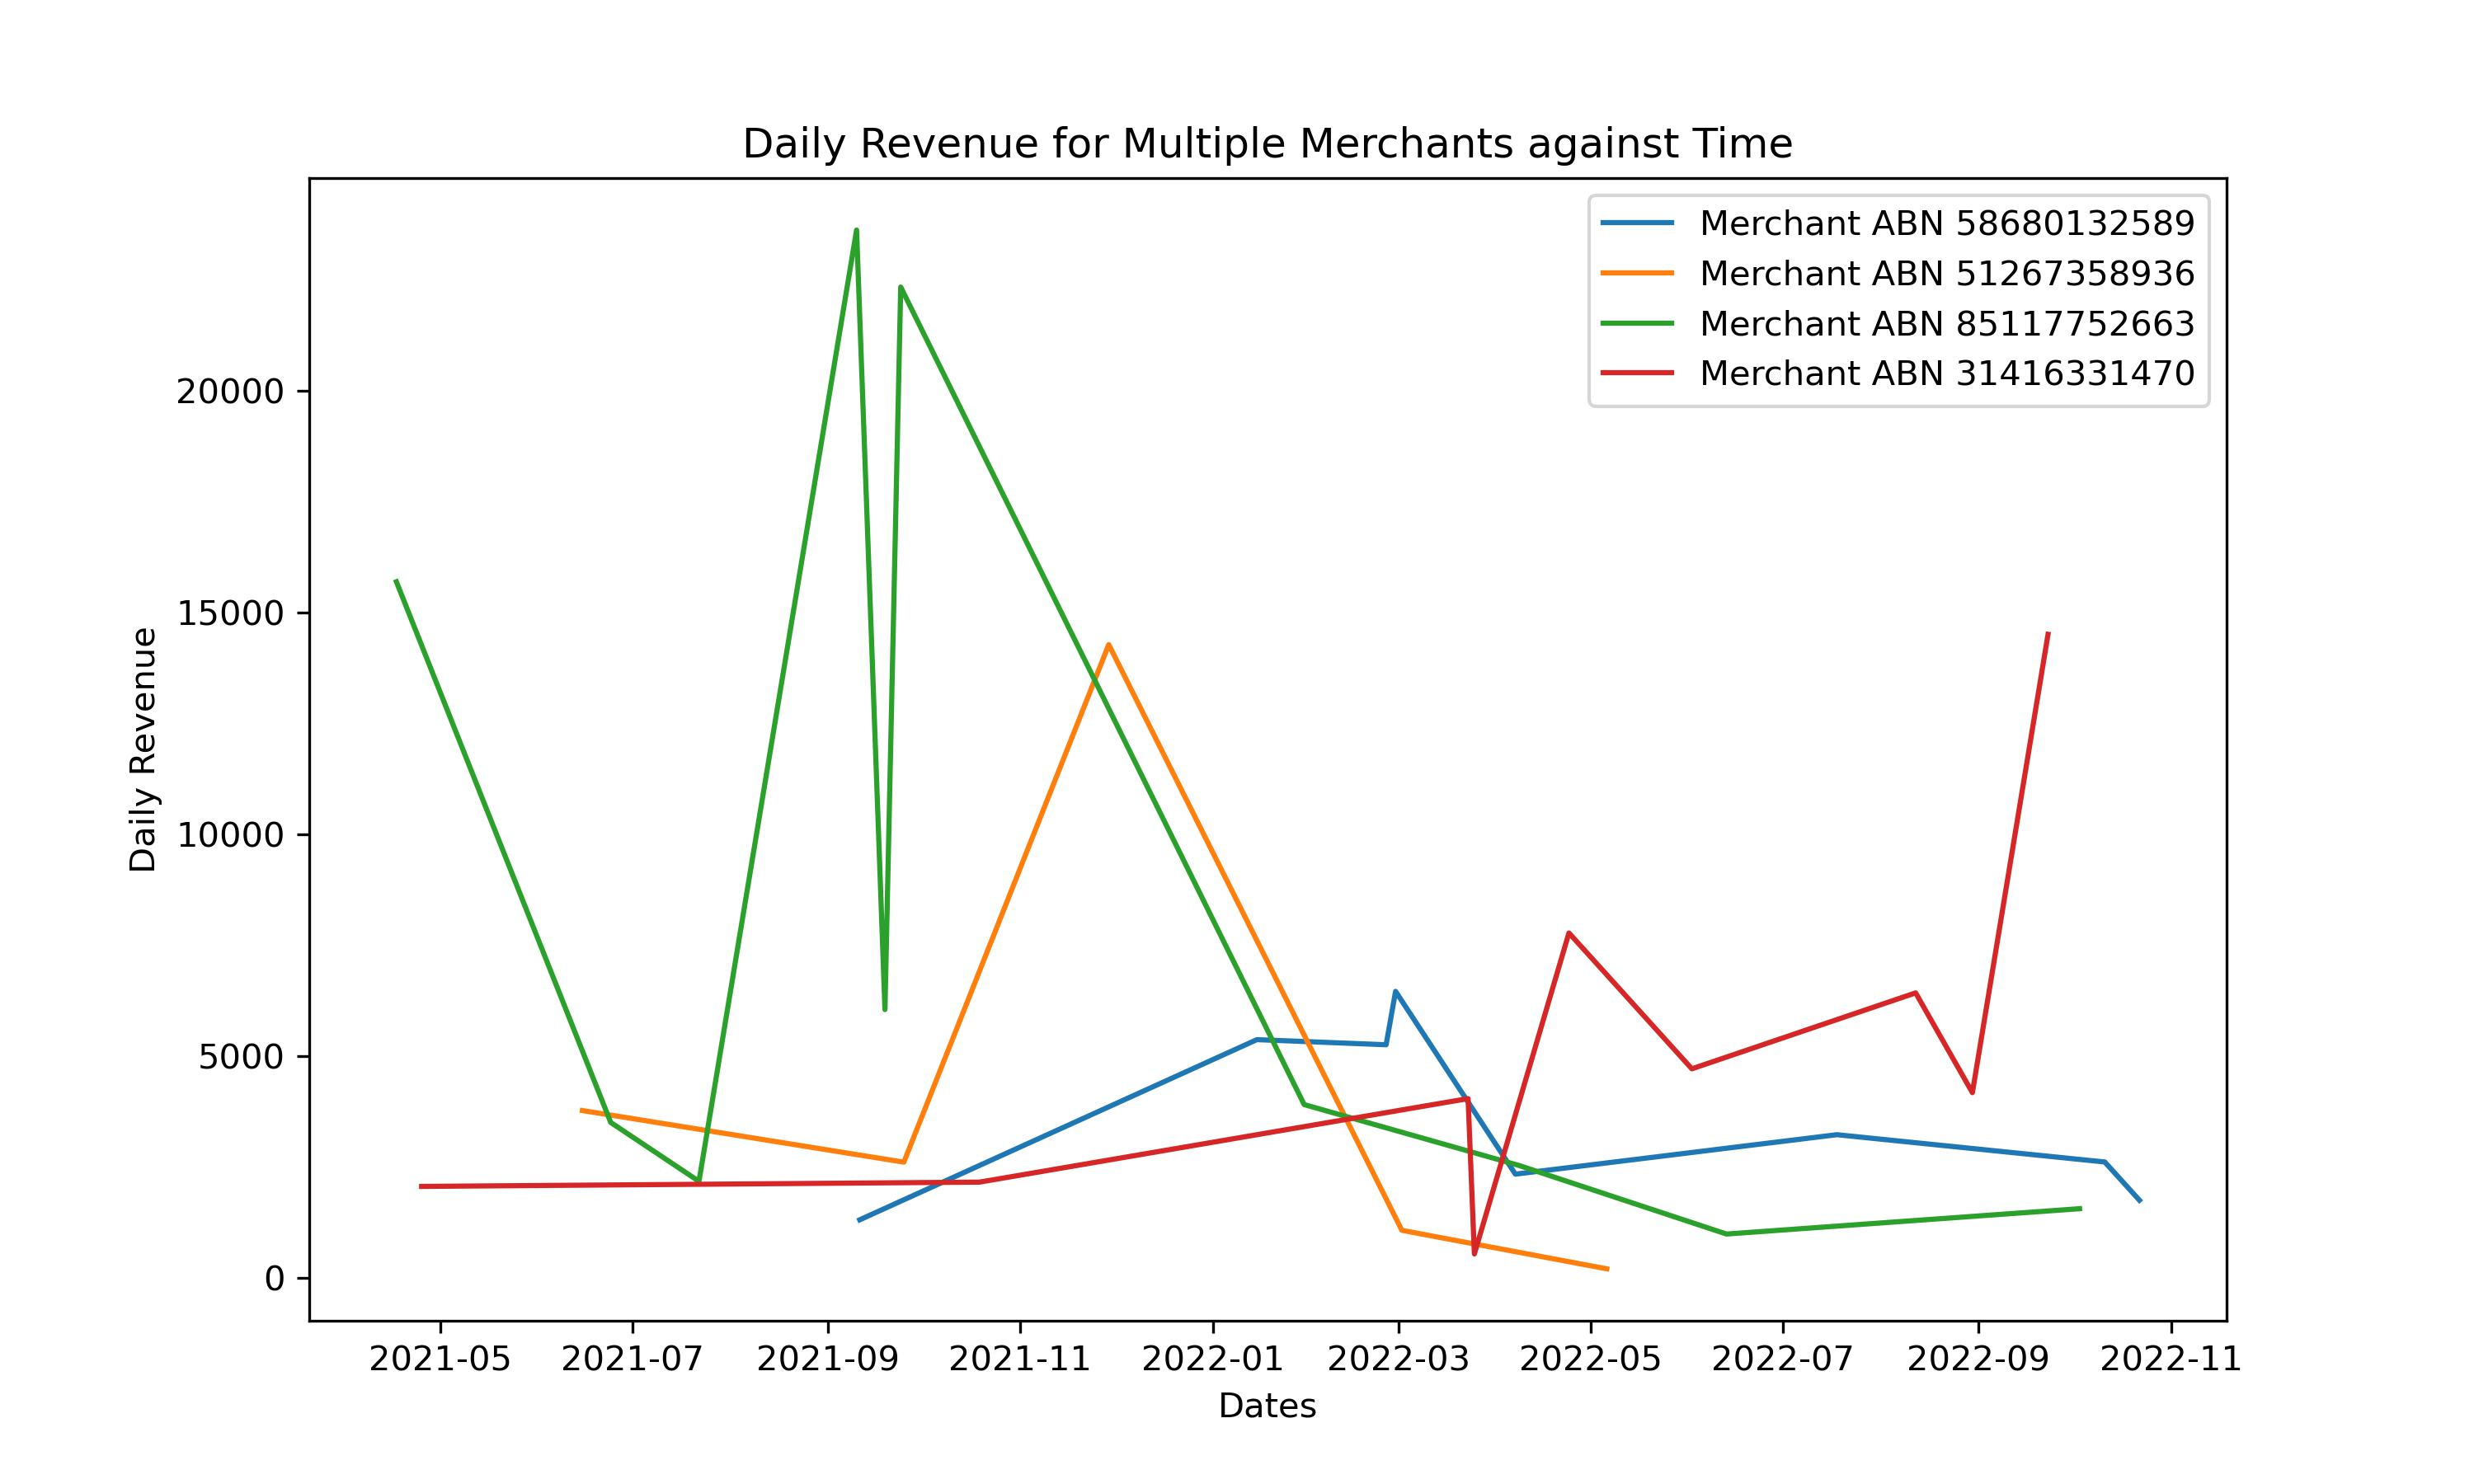

In [48]:
display.Image(f'{MERCHANT_INSIGHTS}daily_revenue_two.jpg', width=700)

Merchant ABN 58680132589 has a quite steady expansion indicating a positive response from customers and potential for long-term collaboration. On the other hand, merchants like ABN 85117752663, which exhibit inconsistent and fluctuating revenue, may require closer monitoring and support to understand the underlying factors causing these fluctuations. Merchants like ABN 31416331470, with low but stable revenue, can be reliable partners, especially if they cater to niche markets or offer products with consistent demand. 

## 7. Assumptions and Limitations 📝

This section explores some difficulties we faced while completing our project and how it led to assumptions we made for our model and the limitations.

### Assumptions

* Many small transaction were assumed to have no fraud probability meaning **ranking is biased** towards merchants with lots of small transactions. This may indeed be a realistic assumption, but future work could implement the full distribution of the power law for fraud probability, rather than discarding any probability < ~8.3%.
* Assumed that the only **inputs affecting profitability** per merchant were the take rate and fraud rate.
* We relied on historical data analysis, **assuming its relevance** to future outcomes and profitability.
* Assumed all transactions use **BNPL system**.

### Limitations

* The dataset used for this project is **synthetically generated**, which may not accurately reflect real-world contexts.
* Imputation of missing postcodes in the external data may introduce **inaccuracies** in scores since it relies on proximity rather than direct information.
* Due to the large size of the dataset, the notebook has a **long runtime**.

## 8. Discontinued Ideas 📉

In this section, we will elaborate on some of the ideas we explored during the development process but ultimately did not incorporate into our final model.

### Revenue Forecasting Models

We initially explored a range of models to forecast merchant revenues over the next 365 days, including Linear Regression, Random Forest Regressor, XGBoost, as well as the time series model SARIMAX. However, we encountered challenges in accurately predicting revenues. Our regressive models obtained a low R2 value and our SARIMAX model struggled to capture the seasonal transaction patterns, leading to less promising predictions. 

One major issue we suspected is the limited amount of data available to train these models, spanning only 1.5 years. Additionally, the lack of merchant-specific features for prediction made it challenging to improve accuracy. Furthermore, we considered the possibility of training a separate model for each merchant, but this approach seemed impractical due to the time and resources it would require in a real-world setting. 

Hence, we decided against using the forecasted revenue as we do not want to risk deviating the ranking and misguiding the firm by including predictions that are suboptimal.

For more details, please visit the `predict_merchant_revenue.ipynb` notebook.

Below are the results of our model predictions on a random merchant's revenue:

#### Linear Regression:

| Evaluation Metric | Scores |
| ----------------- | -------|
| MAE               | 267.62 | 
| RMSE              | 345.67 |  
| R2                | 0.0137 |  



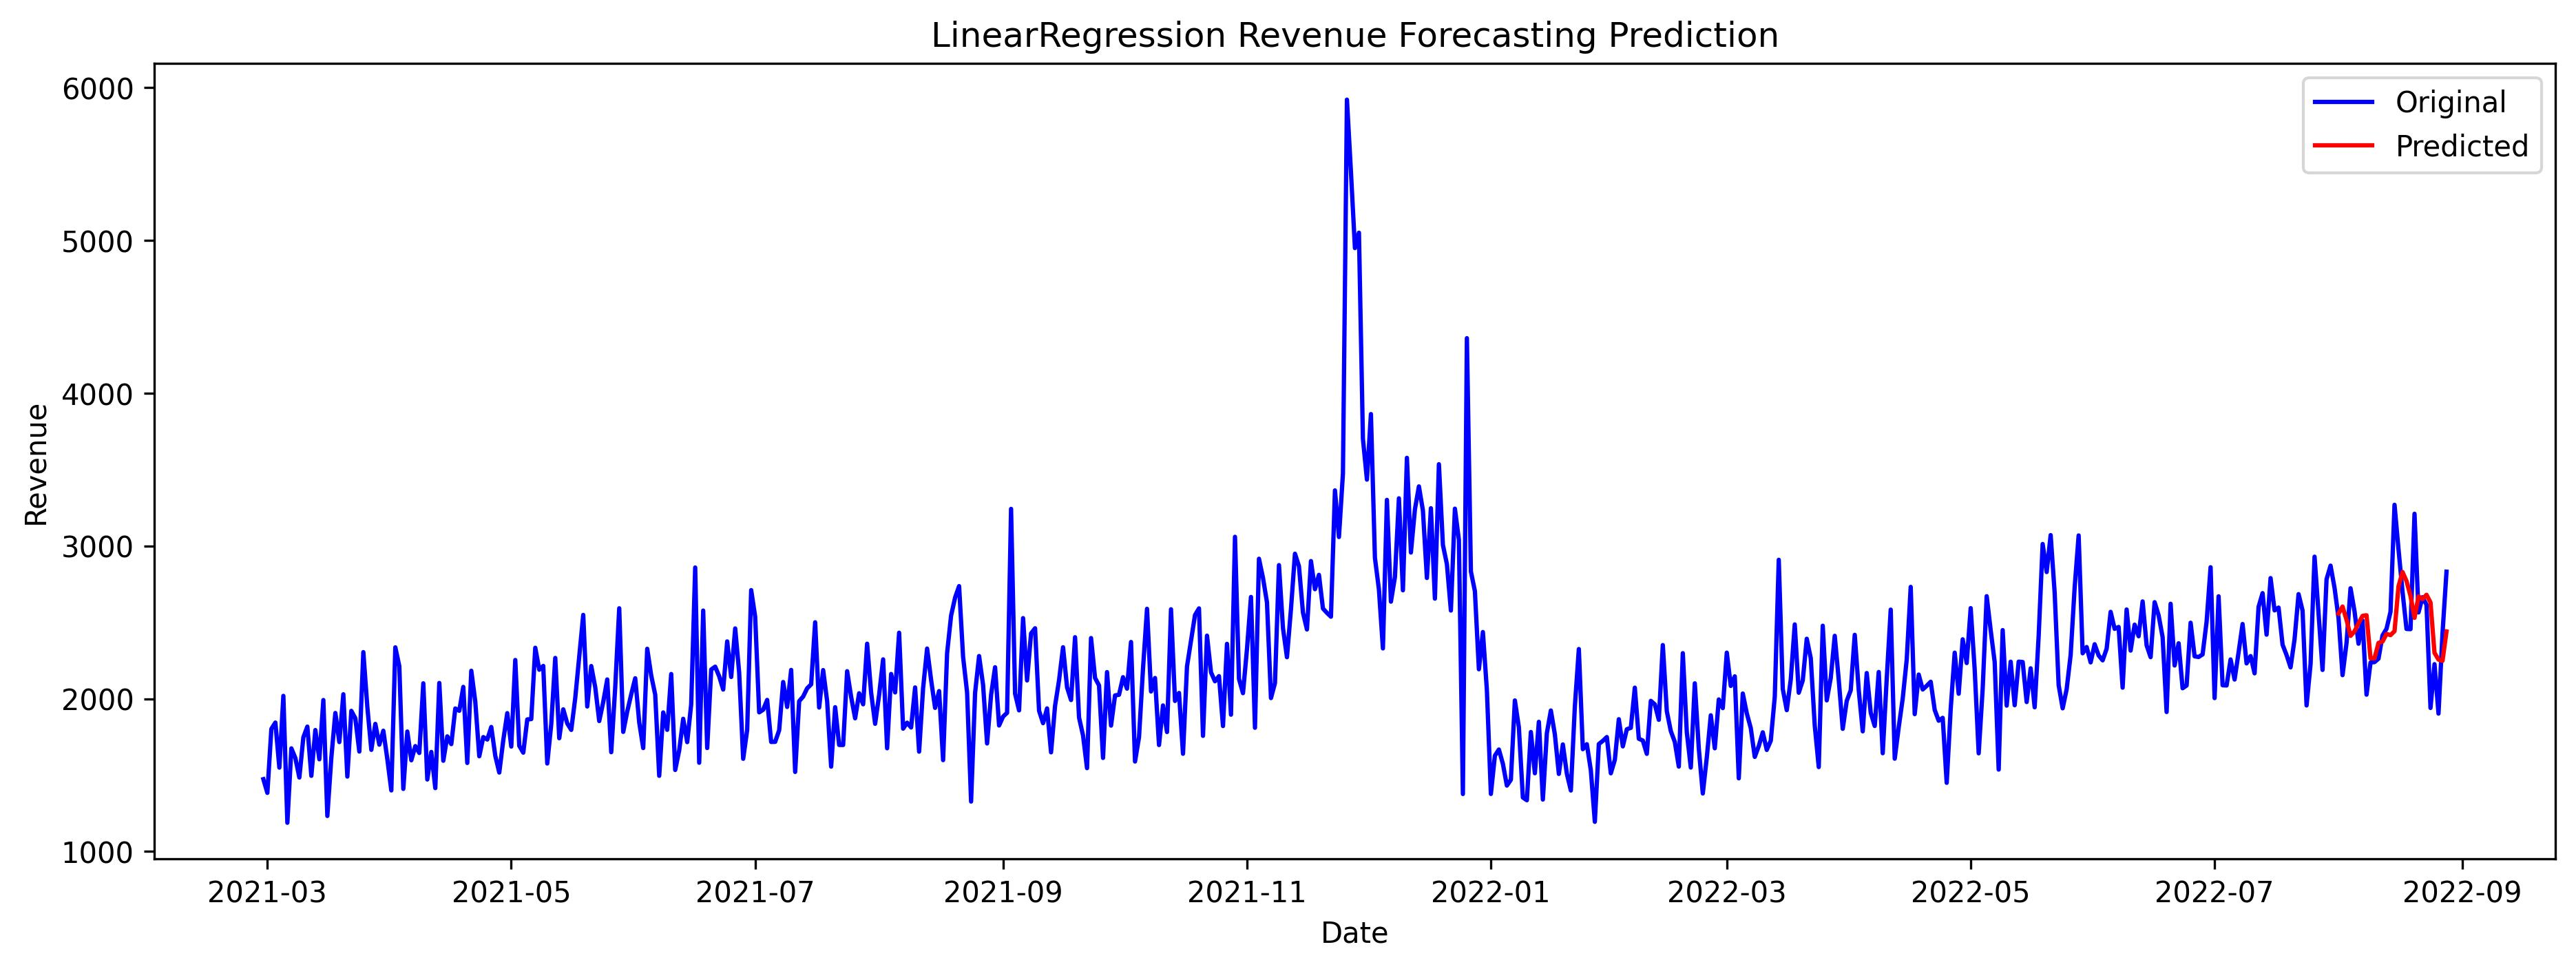

In [49]:
display.Image(f'{APPENDIX}/LinearRegression_pred.jpg', width=700)

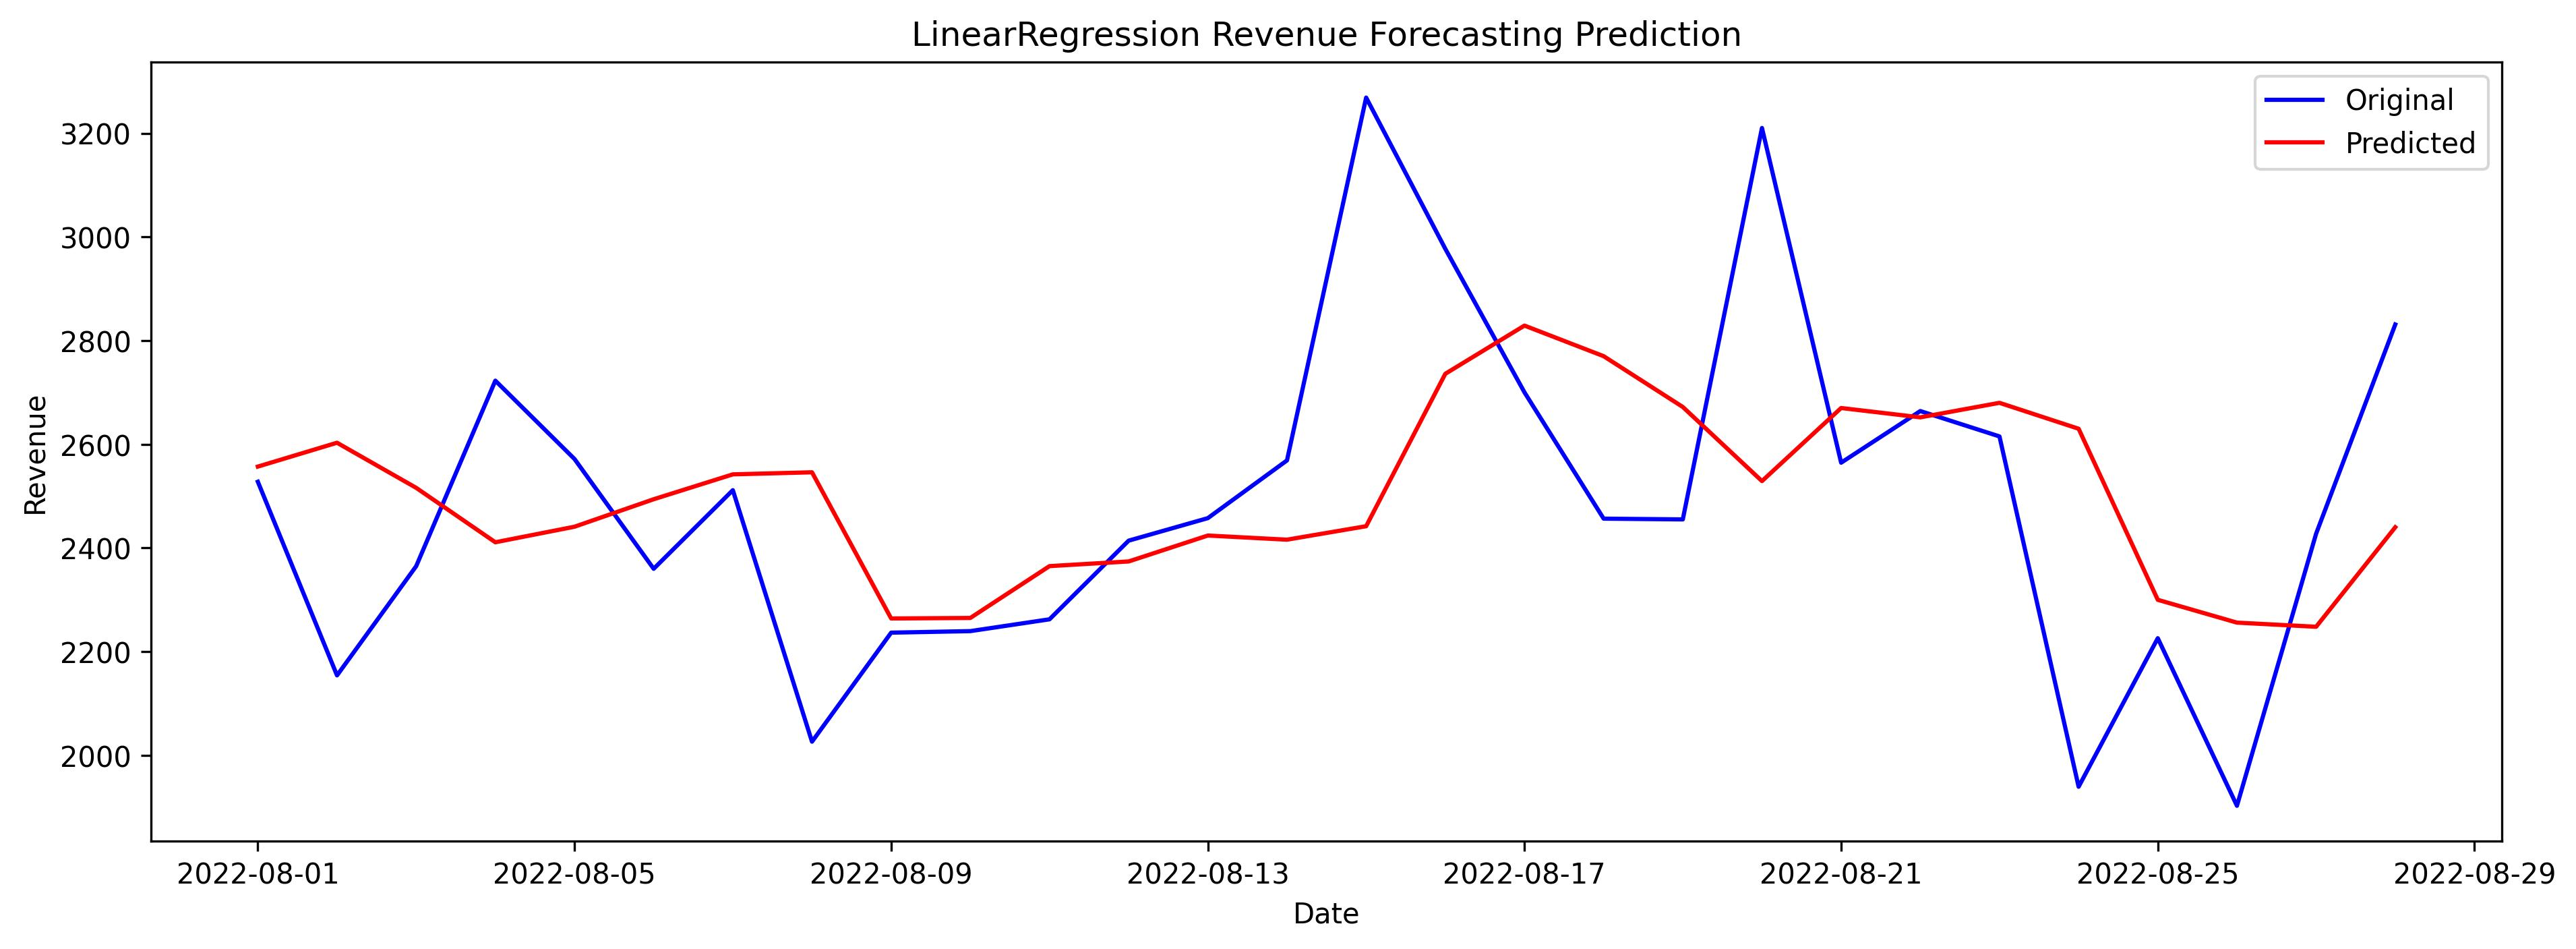

In [50]:
display.Image(f'{APPENDIX}/LinearRegression_pred_zoomed.jpg', width=700)

#### Random Forest Regression


| Evaluation Metric | Scores |
| ----------------- | -------|
| MAE               | 383.34 | 
| RMSE              | 441.23 |  
| R2                |  -0.61 |  

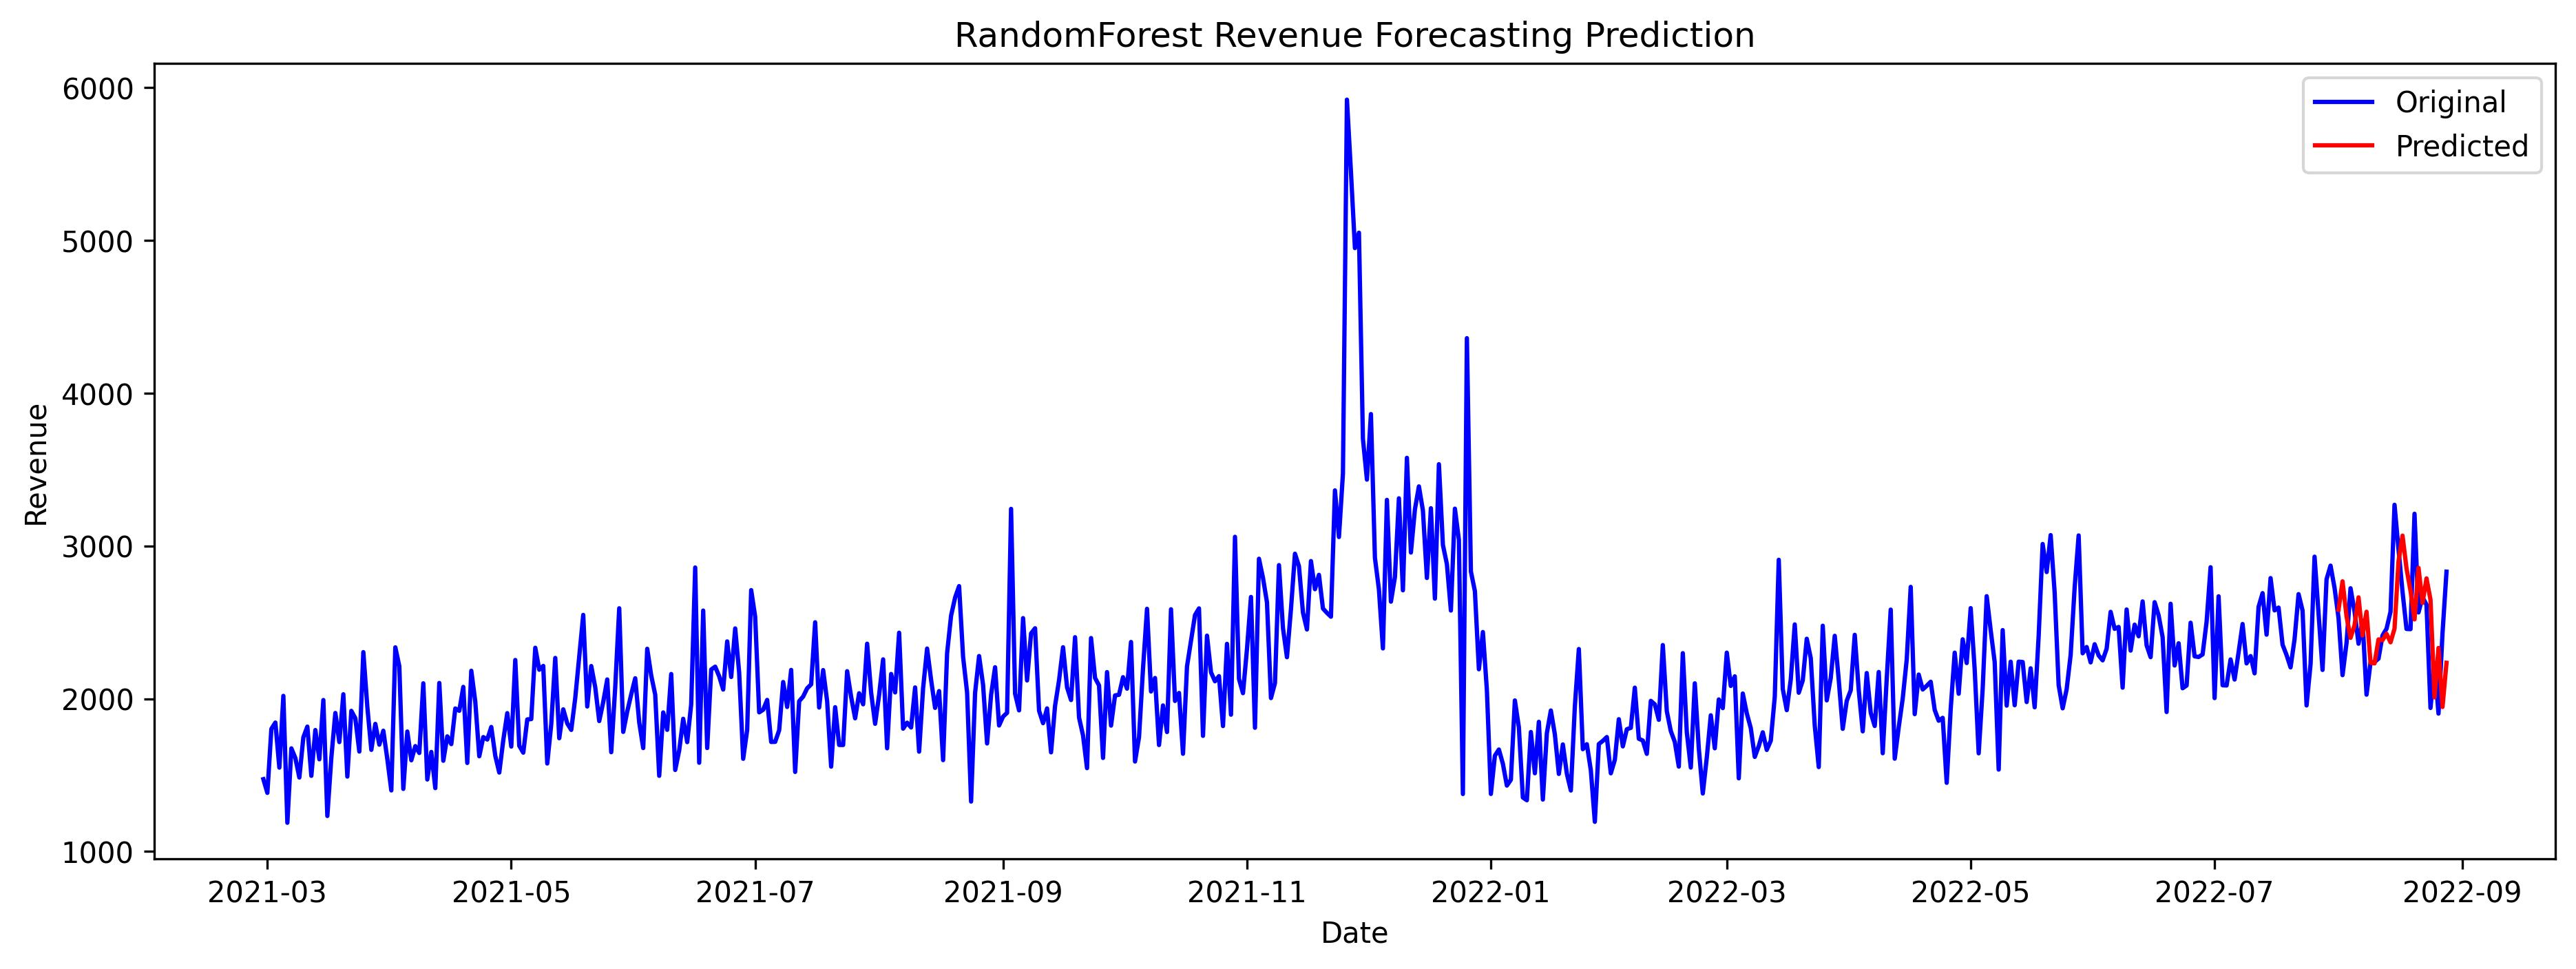

In [51]:
display.Image(f'{APPENDIX}/RandomForest_pred.jpg', width=700)

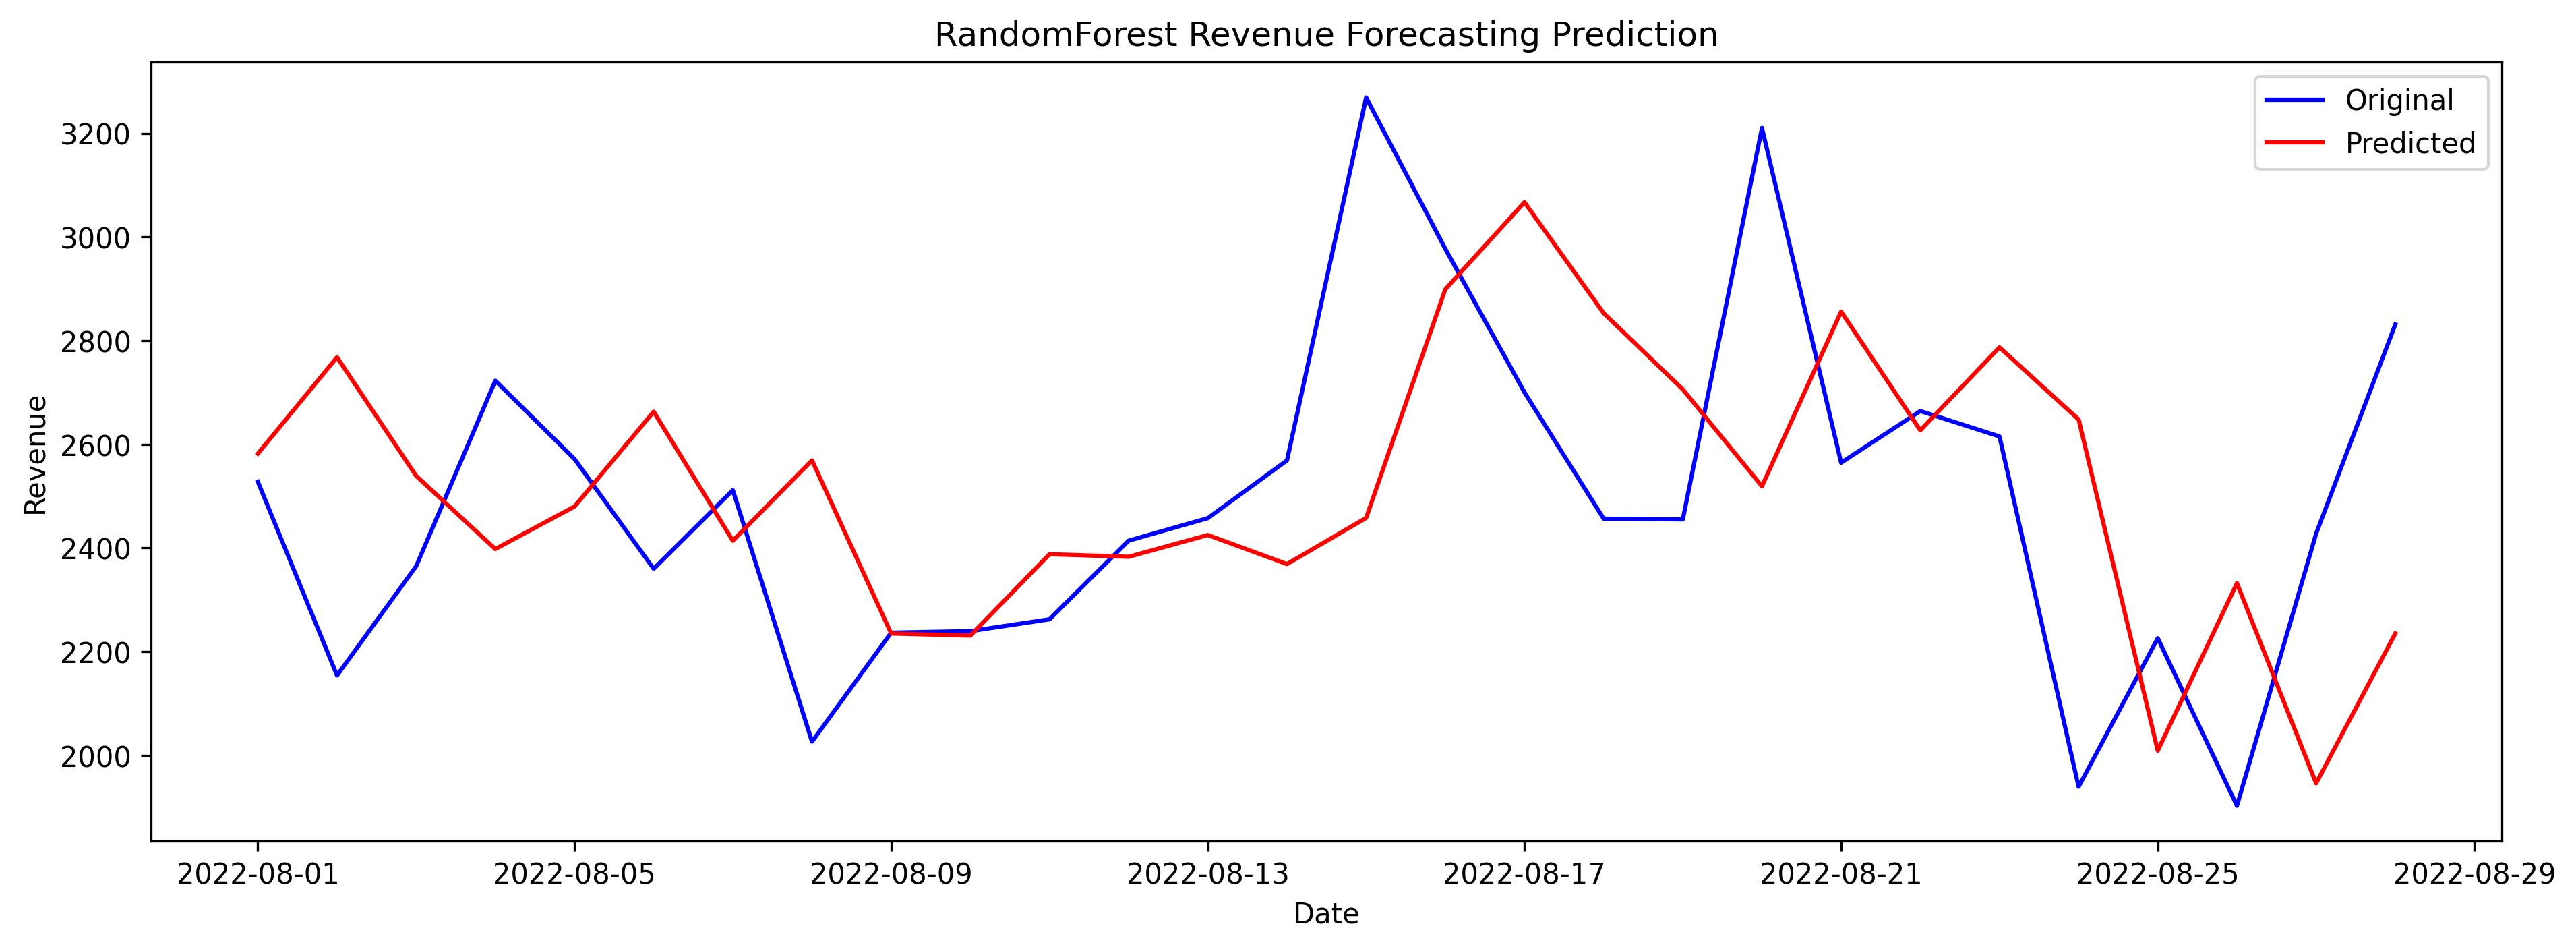

In [52]:
display.Image(f'{APPENDIX}/RandomForest_pred_zoomed.jpg', width=700)

#### XGBoost

| Evaluation Metric | Scores |
| ----------------- | -------|
| MAE               | 358.44 | 
| RMSE              | 435.06 |  
| R2                | -0.562 |  

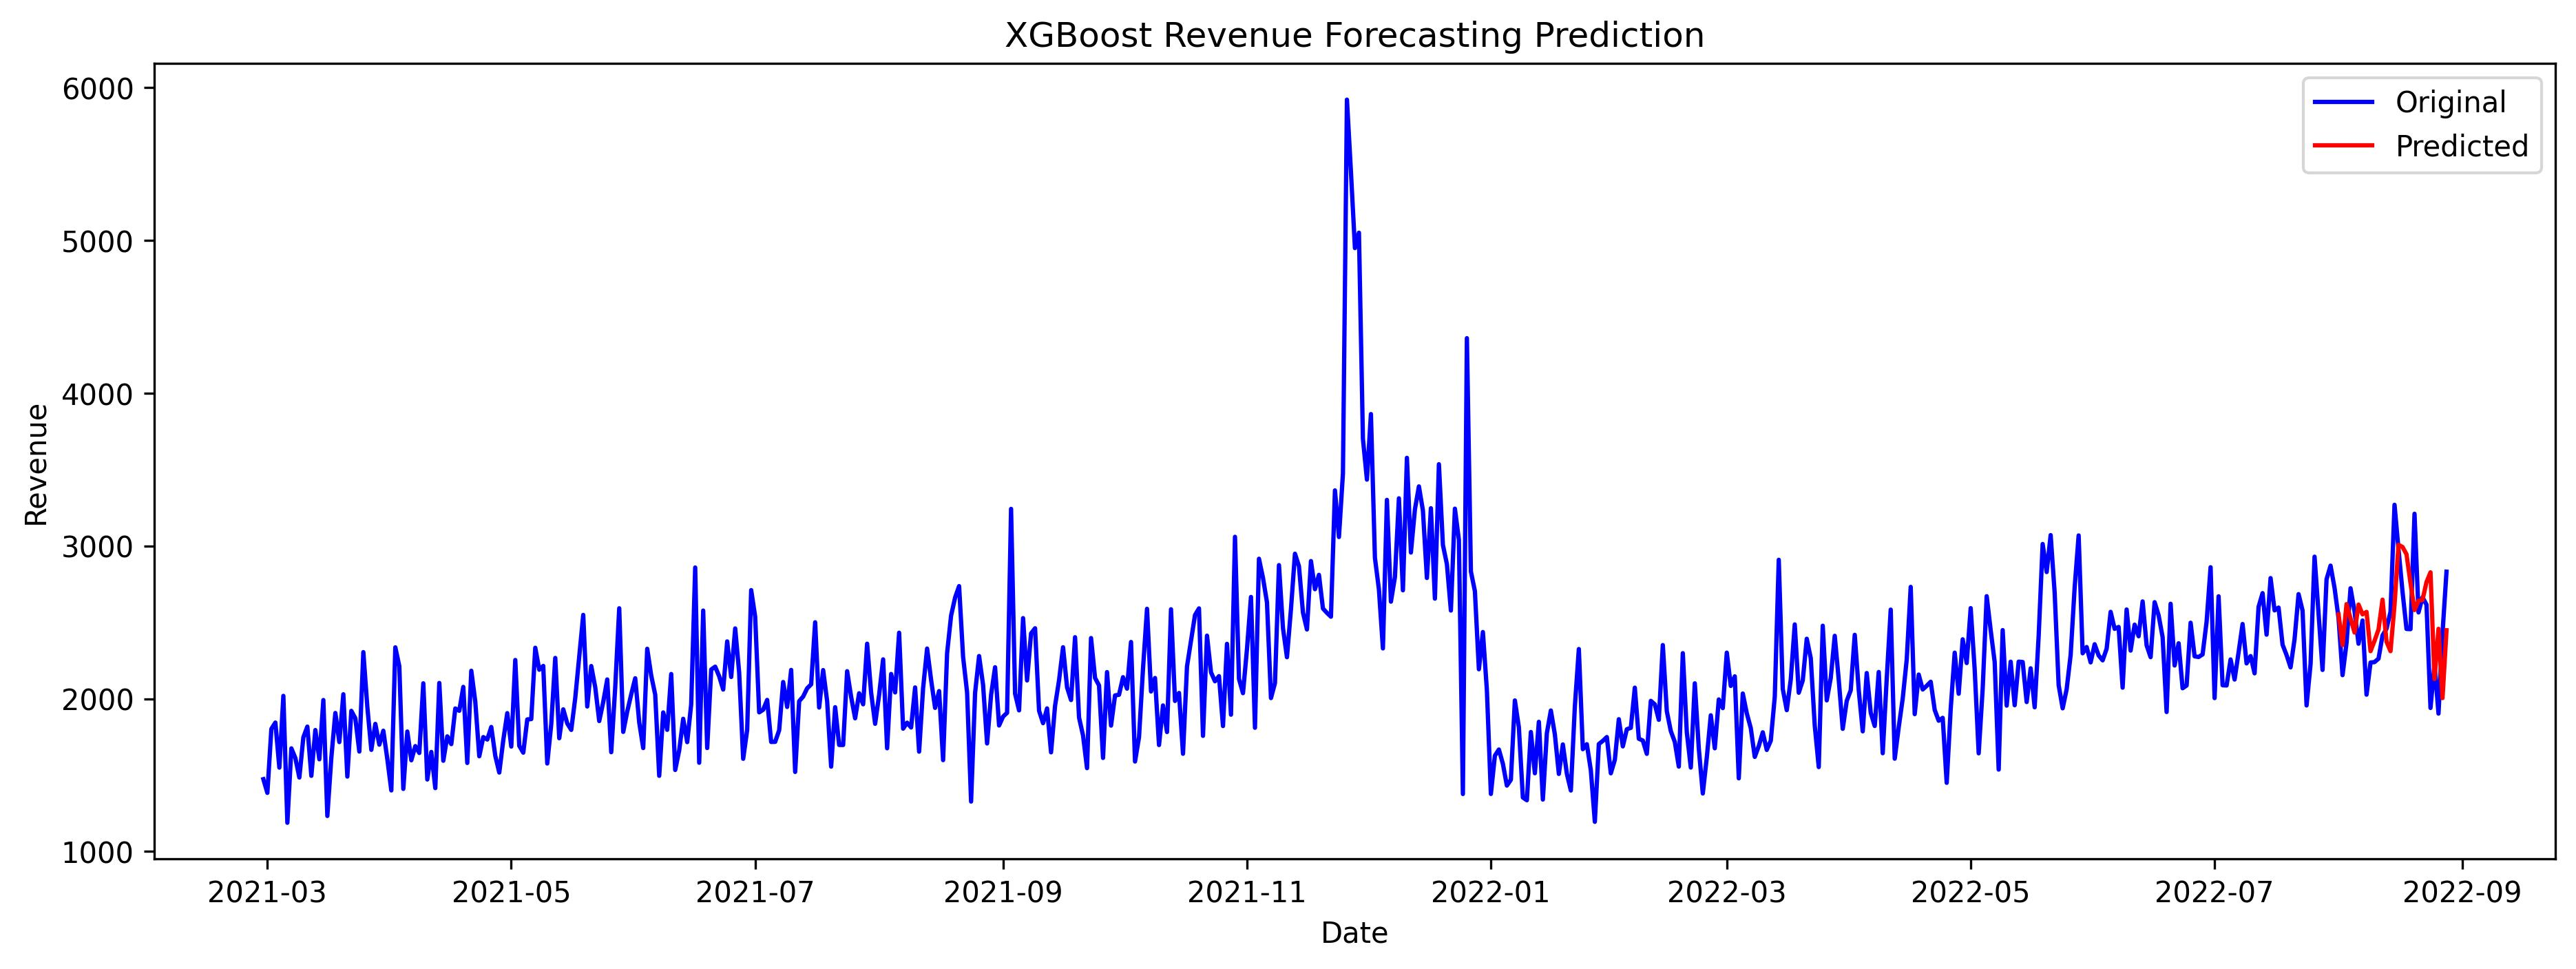

In [53]:
display.Image(f'{APPENDIX}/XGBoost_pred.jpg', width=700)

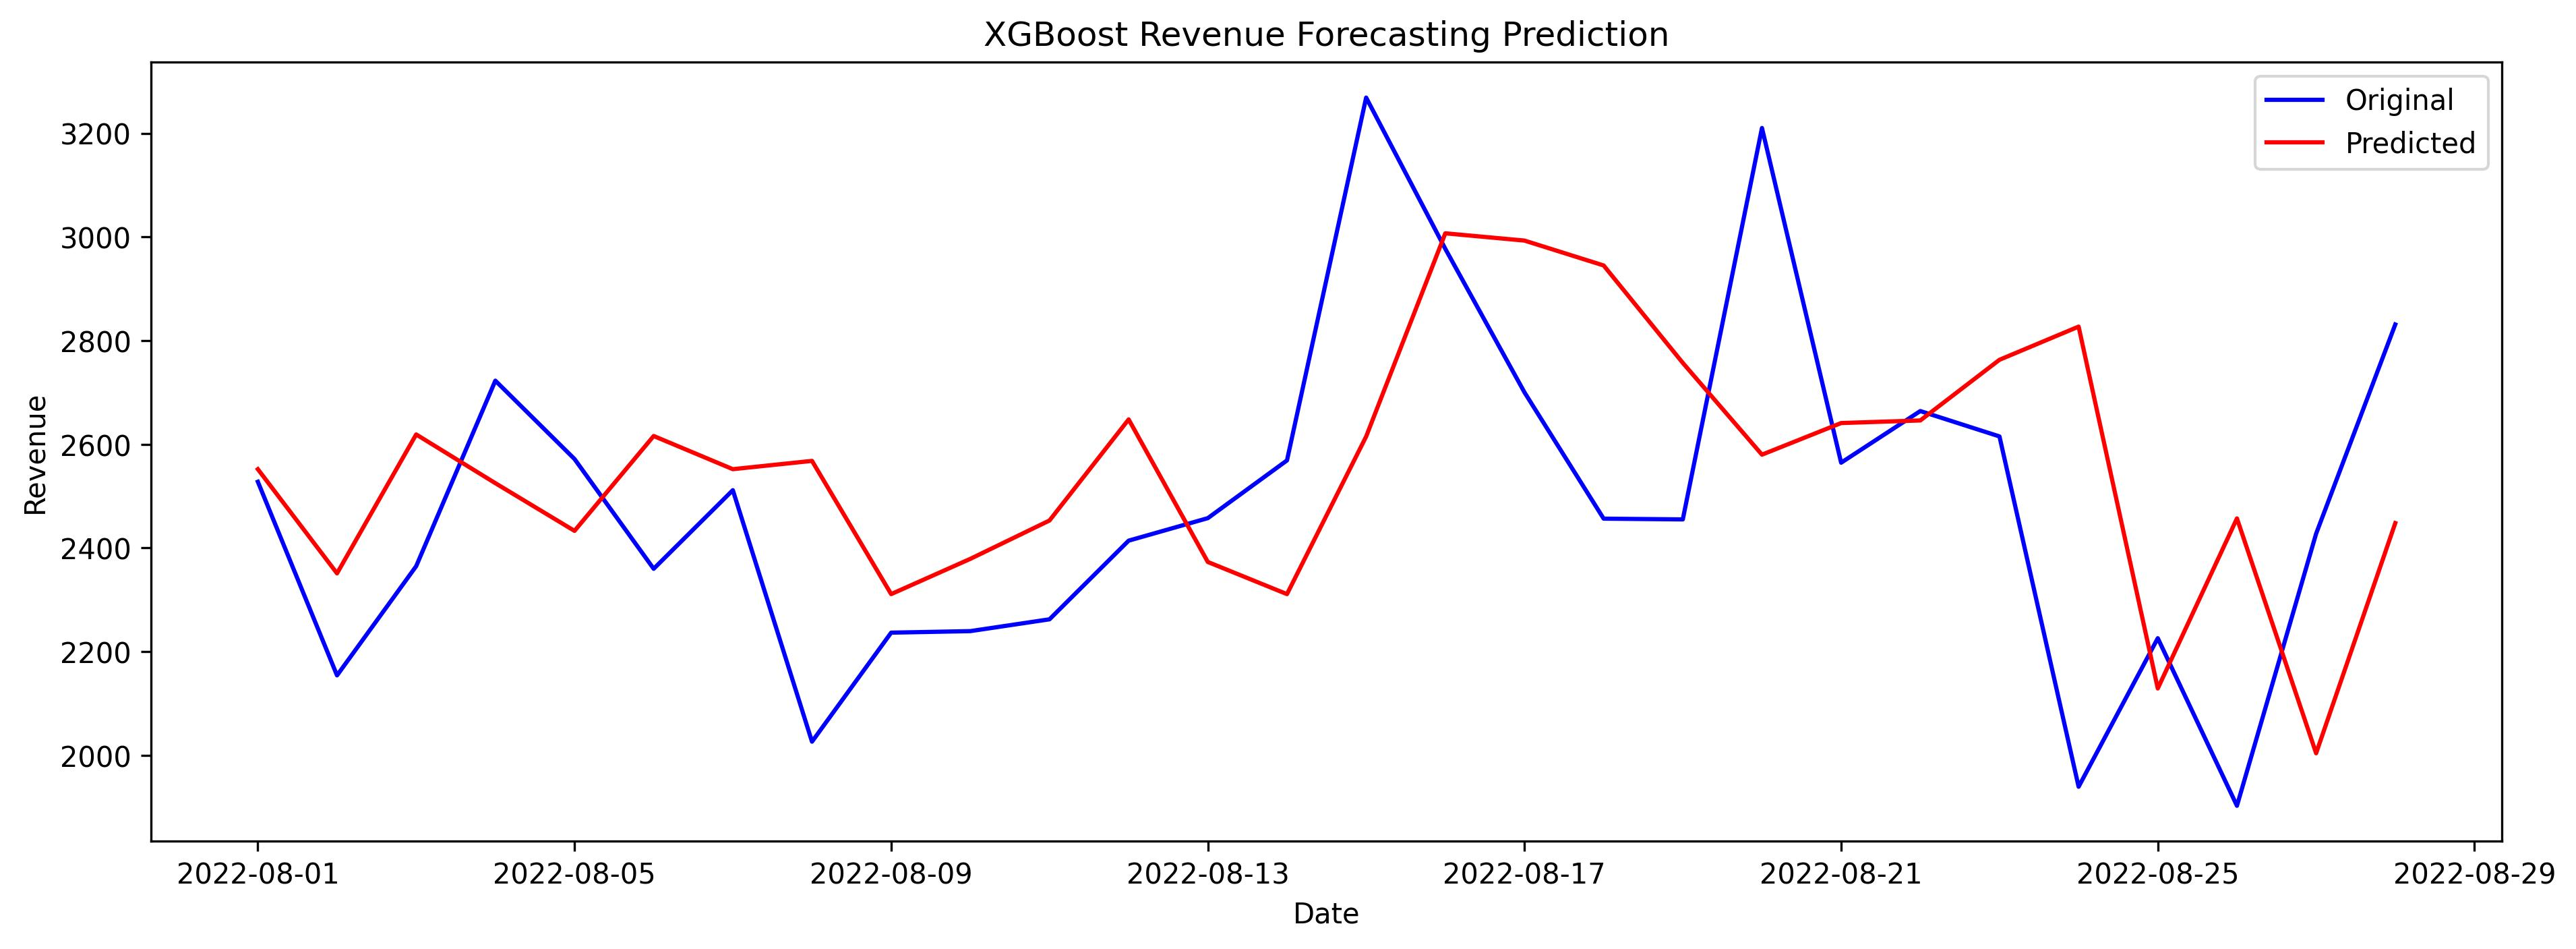

In [54]:
display.Image(f'{APPENDIX}/XGBoost_pred_zoomed.jpg', width=700)

#### SARIMAX 

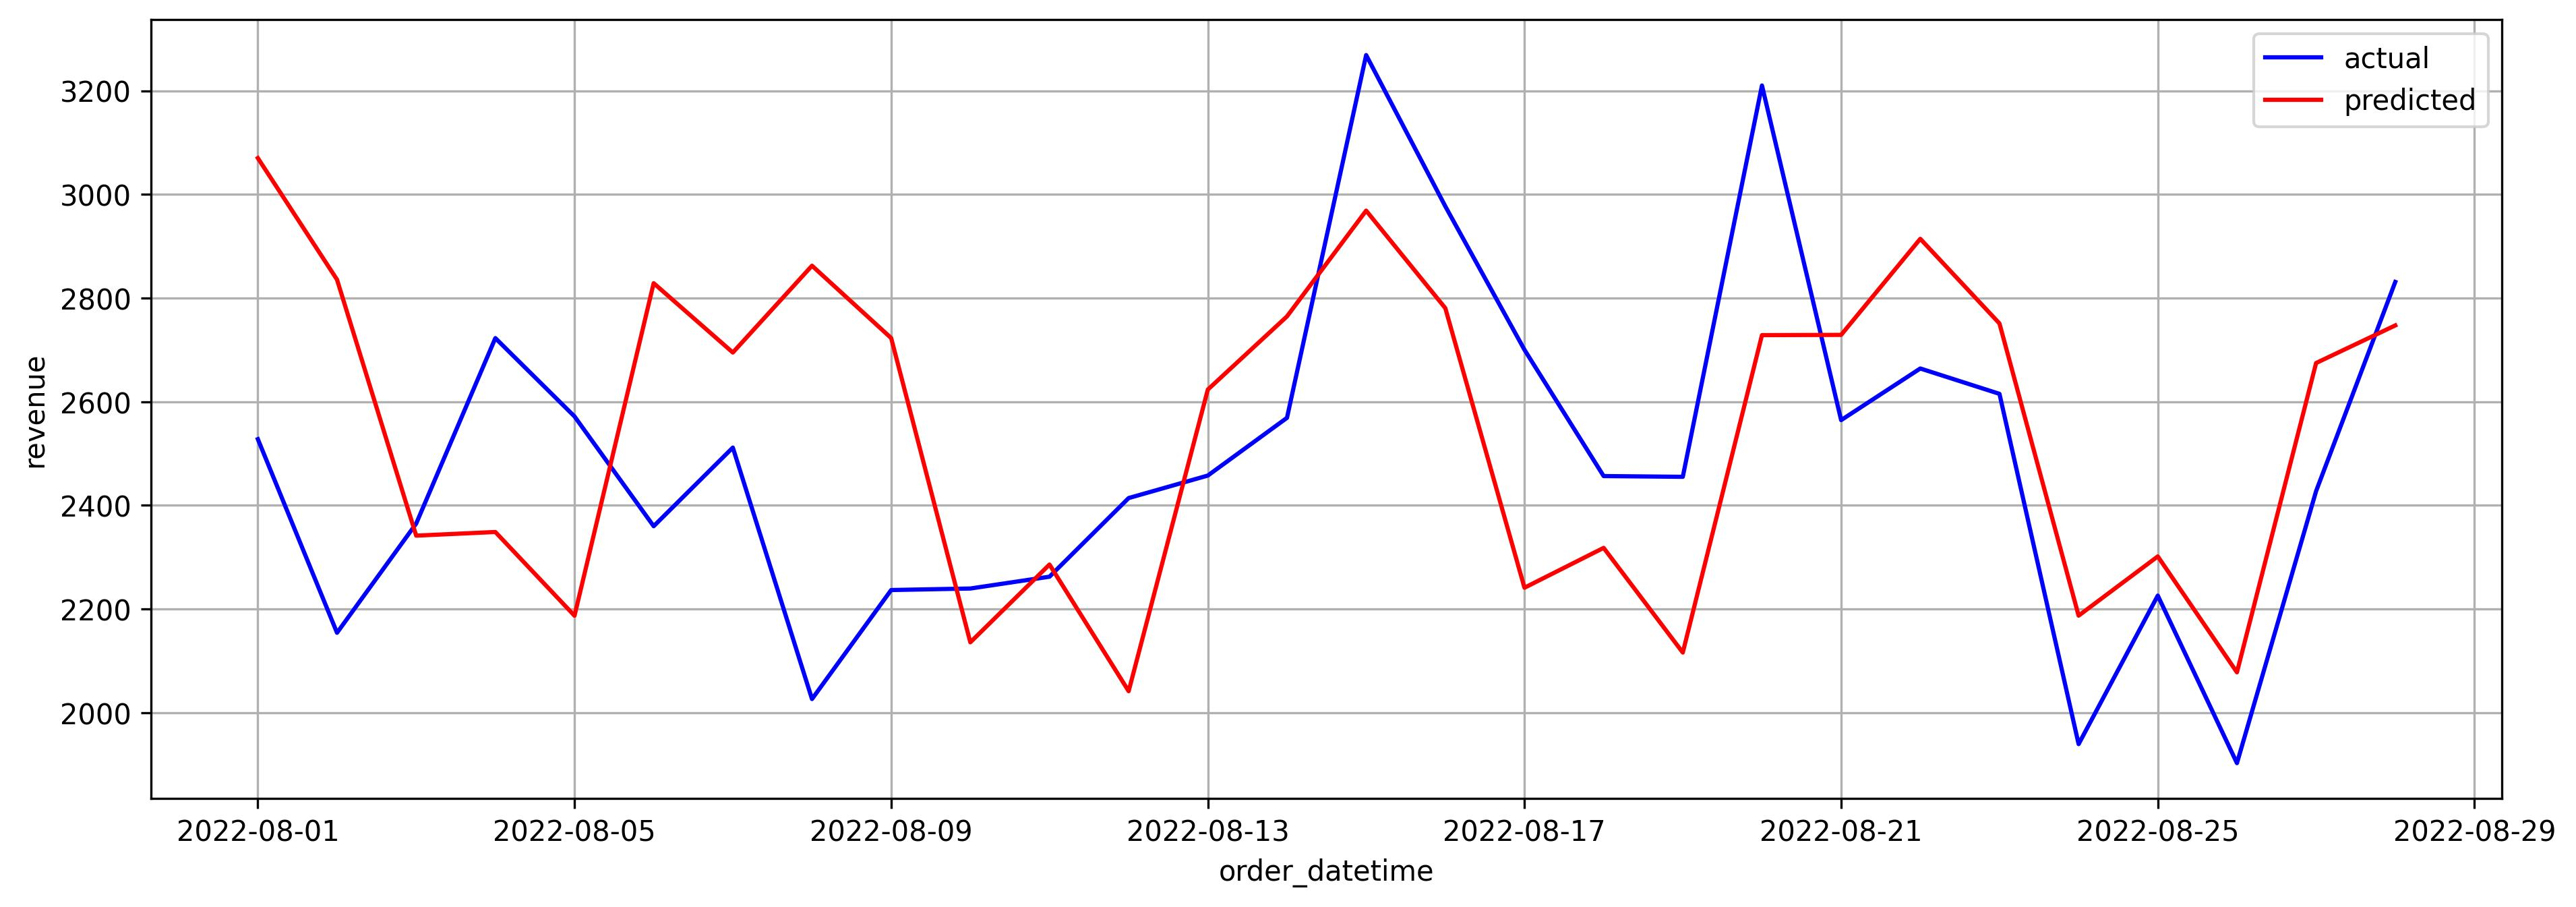

In [55]:
display.Image(f'{APPENDIX}/SARIMAX_pred_zoomed.jpg', width=700)

SARIMAX's predictions on next 365 days:

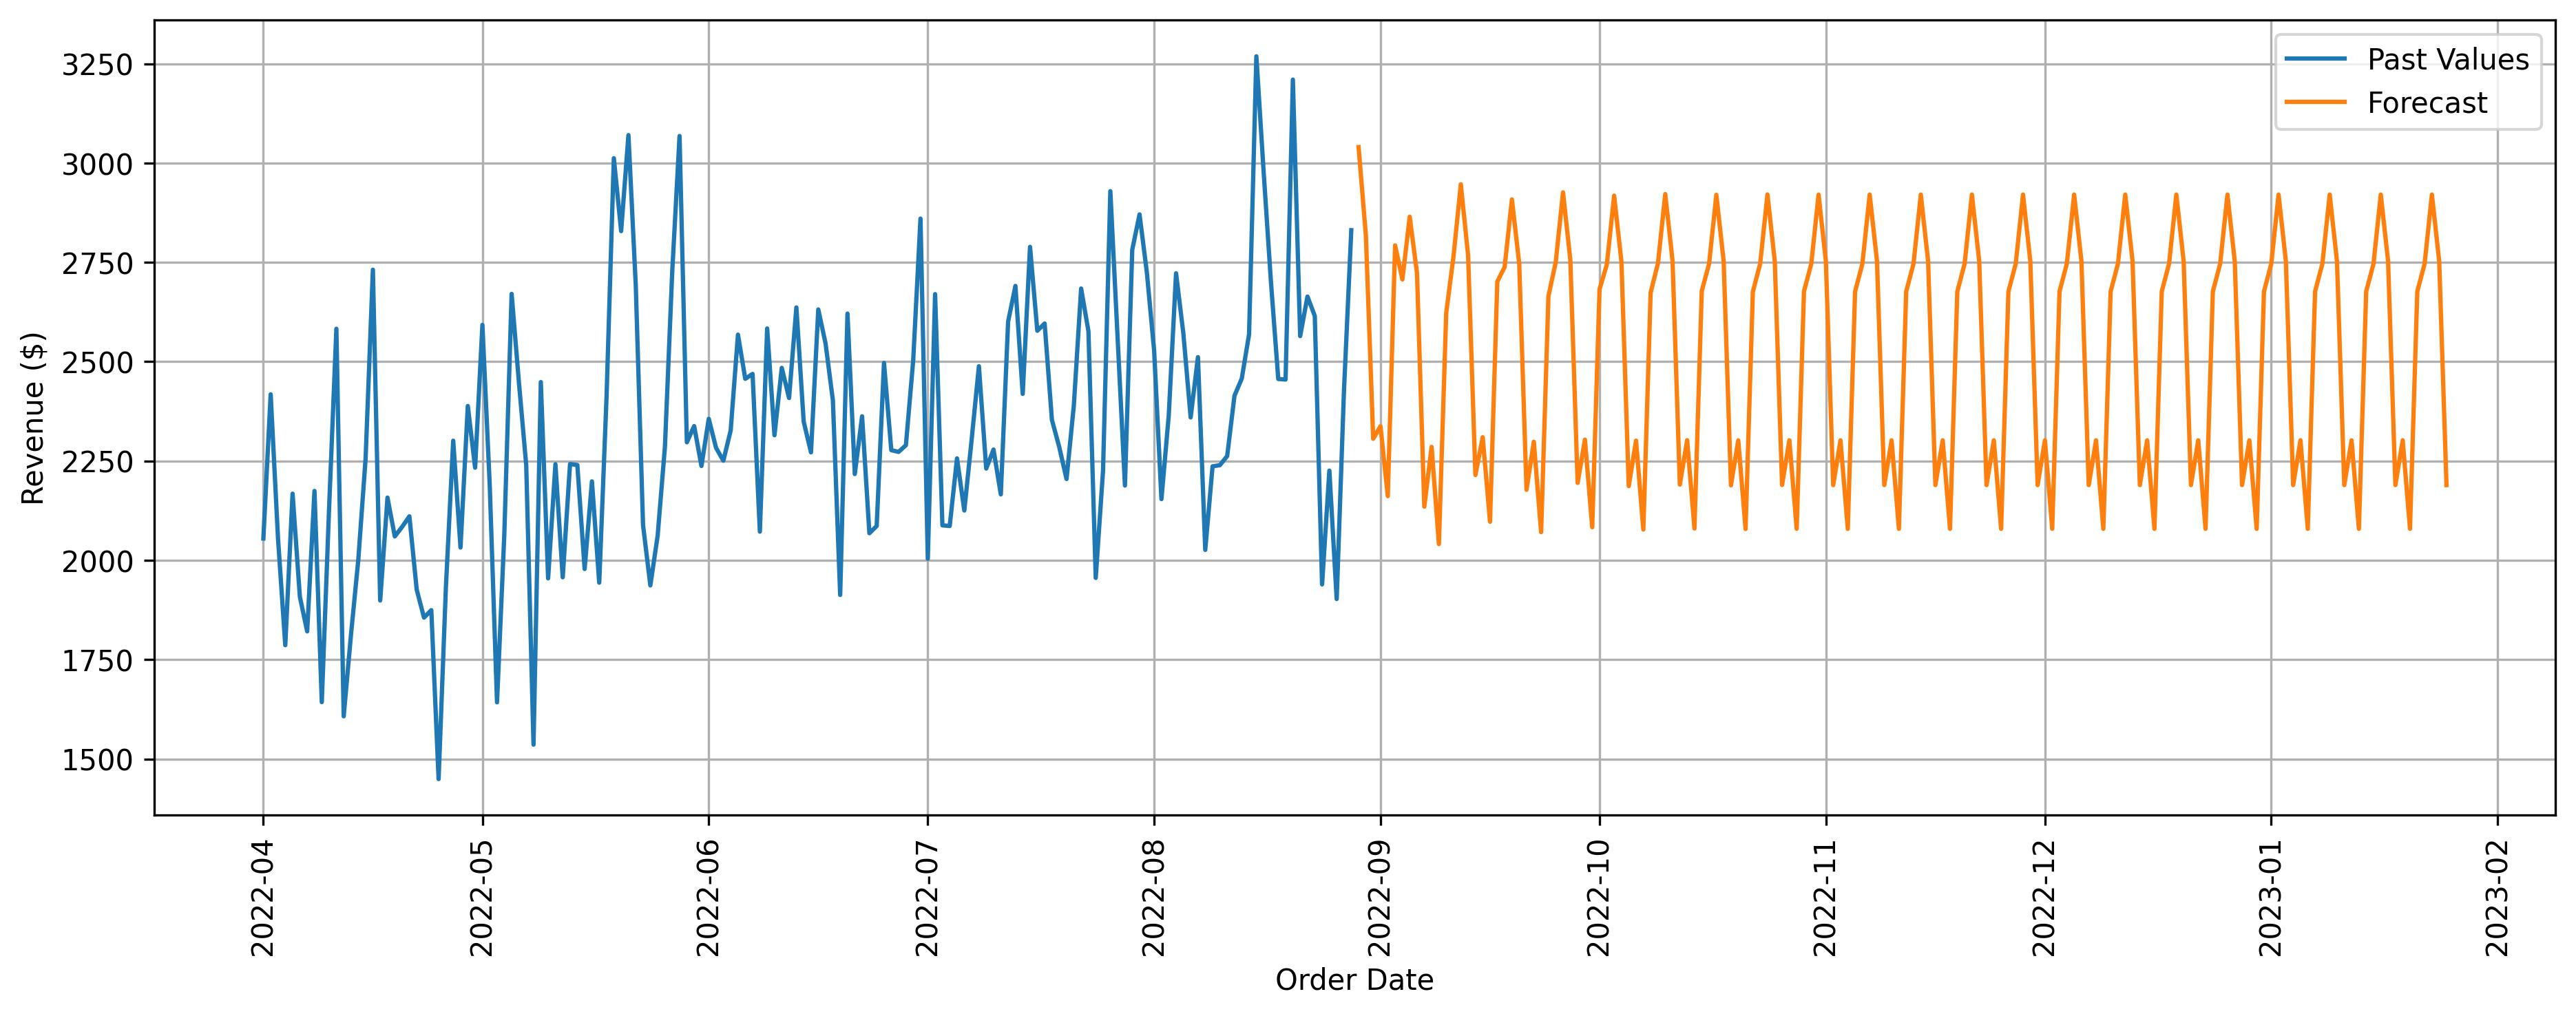

In [56]:
display.Image(f'{APPENDIX}/predictions_sarimax.jpg', width=700)

## 9. Conclusion 📨

Our ranking system provides the BNPL firm with a valuable guide for selecting merchants to partner with, taking into account three critical metrics with careful consideration of weighting and other factors. As long as our assumptions regarding future profitability remain valid, our system is certainly worth implementing.

Onboarding the top 100 merchants is estimated to result in a significant revenue increase of $\$288,181$, while onboarding the bottom 100 merchants would incur an expenditure of $\$23,064$.

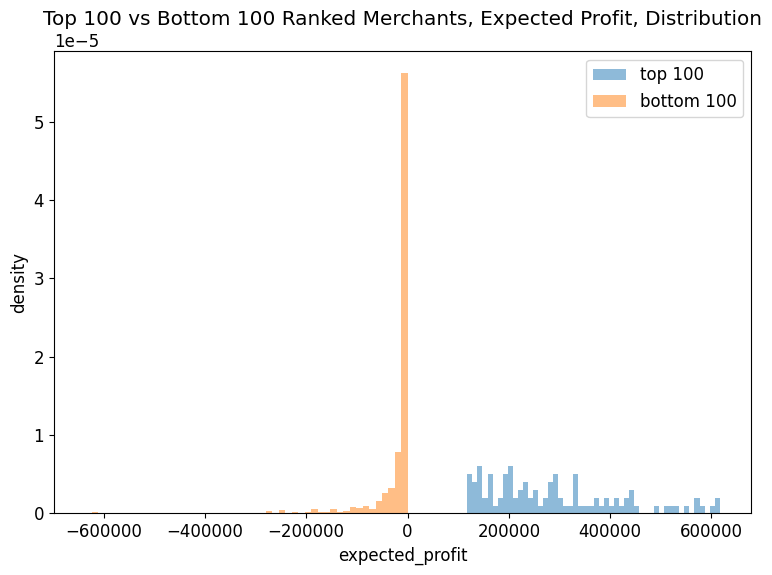

In [57]:
display.Image(f'{PLOTS}top_v_bottom.png', width=700)

Future work could involve aligning the system more closely with the firm's specific profile and standards. Further research and exploration of additional variables can lead to a more refined and tailored approach, ensuring that the firm's merchant onboarding strategy is optimized for long-term success.